In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import sys

RANDOM_SEED = 42
random.seed(RANDOM_SEED)

## GDrive setup
***- Only run if running on Google Colab***

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Set directory to location of OULAD dataset in google drive

In [3]:
cd 'drive/My Drive/Colab Notebooks/4th year project/OULAD dataset'

/content/drive/My Drive/Colab Notebooks/4th year project/OULAD dataset


In [4]:
ls

anonymisedOUDataSet/  Deadline/  StudentAssessmentDaysDeadline.csv


### Load dataset and split by module

In [5]:
if 'google.colab' in sys.modules:
  path = 'Deadline'
else:
  path = '../../dataset/Deadline'

# Module BBB

## Setup

### Load dataset and remove column features that are not used in module

In [6]:
deadline_list = [0, 50, 100, 150, 200, 250]
df = {}

for i in deadline_list:
  temp = pd.read_csv(f'{path}/{i}/oulad_BBB_{i}.csv')
  temp = temp.drop(['code_module'], axis = 1)
  temp = temp.loc[:, (temp != 0).any(axis=0)]
  # fail course = 0 | pass course = 1
  temp['final_result'] = temp['final_result'].replace({1:0, 2:1, 3:1})
  df[i] = temp

sns.set(rc={'figure.figsize':(11.7,8.27)})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [ ]:
df[0].head()

code_presentation  id_student gender  ... subpage    url mean_click
0             2013B       23629      F  ...    0.00  0.000   0.444444
1             2013B       25107      F  ...    0.00  0.000   0.111111
2             2013B       29144      M  ...    1.00  2.000   0.555556
3             2013B       31663      M  ...    2.75  3.125   1.349410
4             2013B       34229      F  ...    2.00  1.500   0.564815

[5 rows x 22 columns]

In [ ]:
df[0].final_result.value_counts()

1    2939
0    1055
Name: final_result, dtype: int64

In [ ]:
df[0].code_presentation.value_counts()

2014J    1151
2013J    1144
2013B     910
2014B     789
Name: code_presentation, dtype: int64

## Helper functions

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, recall_score, precision_score, roc_auc_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

### Plotting

In [ ]:
def plot_confusion_matrix(result):

  if len(result)==5:
    count = 1
  else:
    count= 0

  fig, axes = plt.subplots((len(result)+count)//2,2, figsize=(25, 28))


  for value, ax in zip(result, axes.flatten()):

      sns.heatmap(value[4], annot=True, ax=ax, cmap=plt.cm.Reds)

      ax.set_title(f'\nDay {count*50}: Confusion Matrix\n');
      ax.set_xlabel('Predicted Values')
      ax.set_ylabel('Actual Values ');

      ax.set_xticklabels(['Fail','Pass'])
      ax.set_yticklabels(['Fail','Pass'])

      count+=1

  plt.tight_layout()

In [ ]:
def plot_days(deadline_list,result, title):
  result = np.array(result)
  plt_days = sns.lineplot(x=deadline_list,y=result[:,0],marker="o", label="Accuracy")
  plt_days = sns.lineplot(x=deadline_list,y=result[:,1],marker="o", label="F1 score")
  # plt_days = sns.lineplot(x=deadline_list,y=result[:,2],marker="o", label="Precision")
  # plt_days = sns.lineplot(x=deadline_list,y=result[:,3],marker="o", label="Recall")

  plt_days.set_xlabel("Days of course")
  plt_days.set_ylabel("Score")
  plt_days.set_title(title)

In [ ]:
def plot_days_compare(deadline_list,result,labels,title):
  for i in range(len(result)):
    result[i] = np.array(result[i])
    #plt_days = sns.lineplot(x=deadline_list,y=result[:,0],marker="o", label="Accuracy")
    plt_days = sns.lineplot(x=deadline_list,y=result[i][:,1],marker="o", label=labels[i])
    # plt_days = sns.lineplot(x=deadline_list,y=result[:,2],marker="o", label="Precision")
    # plt_days = sns.lineplot(x=deadline_list,y=result[:,3],marker="o", label="Recall")
    
  plt_days.set_xlabel("Days of course")
  plt_days.set_ylabel("F1 Score")
  plt_days.set_title(title)

In [ ]:
def plot_days_compare_npv(deadline_list,result,labels,title):
 
  for i in range(len(result)):   
    npv = []

    for j in result[i][:,4]:
      tn, fp, fn, tp = j.ravel()

      # Prevent zero division error
      if fn == 0:
        npv.append(0)
      else:
        npv.append(tn/(tn+fn))

    #plt_days = sns.lineplot(x=deadline_list,y=result[:,0],marker="o", label="Accuracy")
    plt_days = sns.lineplot(x=deadline_list,y=npv,marker="o", label=labels[i])
    # plt_days = sns.lineplot(x=deadline_list,y=result[:,2],marker="o", label="Precision")
    # plt_days = sns.lineplot(x=deadline_list,y=result[:,3],marker="o", label="Recall")
    
  plt_days.set_xlabel("Days of course")
  plt_days.set_ylabel("Negative Predictive Value")
  plt_days.set_title(title)

In [ ]:
def plot_correlation_matrix(result, Y_test= None):
  fig, axes = plt.subplots(len(result)//2,2, figsize=(25, 28))

  temp = {}
  for i in result.keys():
    temp[i] = result[i].copy()
    if Y_test:
      temp[i]['final_result'] = Y_train[i] 

  count= 0
  for value, ax in zip(temp, axes.flatten()):

      corr = temp[value].corr()

      sns.heatmap(corr, annot=True, ax=ax, cmap=plt.cm.Reds)

      ax.set_title(f'\nDay {count*50}: Correlation Matrix\n');

      count+=1

  plt.tight_layout()

In [ ]:
def plot_feature_importance(feature_results):

  if len(feature_results)==5:
    count = 1
  else:
    count= 0

  fig, axes = plt.subplots(len(feature_results)//2,2, figsize=(25, 33))

  for value, ax in zip(feature_results, axes.flatten()):
   
    importance = permutation_importance(value[0], value[1], value[2])

    feature_names = tuned_model.feature_names_in_

    ax.bar([x for x in range(len(importance['importances_mean']))], importance['importances_mean'], yerr=importance['importances_std'])
    ax.set_xticks(range(len(feature_names)))
    ax.set_xticklabels(feature_names, rotation='vertical')
    ax.set_title(f'\nDay {count*50}: Feature Importance\n');

    count+=1
  


### Split dataframe

In [ ]:
def split_dataset(df_day, train_code_presentation, test_code_presentation):   
  test_df = df_day.loc[df_day['code_presentation']==test_code_presentation]
  test_df = test_df.drop(['code_presentation','id_student'], axis = 1)

  Y_test = test_df['final_result']
  X_test = test_df.drop('final_result', axis=1)

  train_df = df_day.loc[df_day['code_presentation'].isin(train_code_presentation)]
  train_df = train_df.drop(['code_presentation','id_student'], axis = 1)

  Y_train = train_df['final_result']
  X_train = train_df.drop('final_result', axis=1)

  
  return X_train, X_test, Y_train, Y_test


In [ ]:

def split_dataset_single_presentation(df_day, code_presentation):

  df_cp = df_day.loc[df_day['code_presentation']==code_presentation]
  df_cp = df_cp.drop(['code_presentation','id_student'], axis = 1)
  
  Y = df_cp['final_result']
  X = df_cp.drop('final_result', axis=1)

  return train_test_split(X,Y, random_state=RANDOM_SEED)


### Evaluate models

In [ ]:
def evaluation_summary(y_pred, y_test):
  acc = accuracy_score(y_test,y_pred)
  f1 = f1_score(y_test,y_pred)
  prec = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  
  conf_matrix = confusion_matrix(y_test,y_pred)

  return acc, f1, prec, recall, conf_matrix   

In [ ]:
def evaluate_search(model, test_features, test_labels):
    predictions = model.predict(test_features)
    
    acc, f1, prec, recall, conf = evaluation_summary(predictions, test_labels)
    print('Accuracy = {:0.2f}%, F1 Score = {:0.2f}%.'.format(acc, f1))
    
    return acc

### Split dataframe by demographic data | performance data | learning behaviour data

In [ ]:
df[0].columns

Index(['code_presentation', 'id_student', 'gender', 'region',
       'highest_education', 'imd_band', 'age_band', 'num_of_prev_attempts',
       'studied_credits', 'disability', 'final_result', 'forumng', 'glossary',
       'homepage', 'oucontent', 'ouelluminate', 'quiz', 'resource',
       'sharedsubpage', 'subpage', 'url', 'mean_click'],
      dtype='object')

In [ ]:
def split_dataframe_by_data_type(input_df, column_types, include_final_result=True):
  demographic_columns = ['gender', 'region', 'highest_education', 'imd_band','age_band', 'disability']
  prev_uni_experience_columns = ['num_of_prev_attempts','studied_credits']
  all_performance_columns = ['score','weighted_score']
  performance_columns = set(input_df.columns).intersection(set(all_performance_columns))
  all_learning_behaviour_columns = ['mean_click','resource','subpage','oucontent','url','forumng','quiz','page','oucollaborate','questionnaire','ouwiki','dataplus','externalquiz','homepage','ouelluminate','glossary','dualpane','repeatactivity','htmlactivity','sharedsubpage','folder']
  learning_behaviour_columns = set(input_df.columns).intersection(set(all_learning_behaviour_columns))

  final_result_column = ['final_result']

  type_dict = {"demographic":demographic_columns, "prev_uni_experience":prev_uni_experience_columns, "performance":performance_columns,"learning_behaviour":learning_behaviour_columns, "final_result":final_result_column}

  columns_used = ['code_presentation', 'id_student']
  for i in column_types:
    columns_used.extend(type_dict[i])
  
  if include_final_result:
    columns_used.extend(final_result_column)

  output_df = input_df[columns_used]

  return output_df

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline

### Encode data

In [ ]:
def encode_data(df, train, test=None):
  X_train, X_test, Y_train, Y_test = {},{},{},{}

  for i in df.keys():
    if test != None:
      X_train[i], X_test[i], Y_train[i], Y_test[i] = split_dataset(df[i], train, test)
    else:
      X_train[i], X_test[i], Y_train[i], Y_test[i] = split_dataset_single_presentation(df[i], train)
    
    
    cols_to_drop = X_train[i].nunique()
    cols_to_drop = list(cols_to_drop.loc[cols_to_drop.values==1].index)


    X_train[i] = X_train[i].drop(cols_to_drop, axis=1)
    X_test[i] = X_test[i].drop(cols_to_drop, axis=1)

  for i in df.keys():
    categorical_features = X_train[i].select_dtypes(include="object").columns
    numerical_features = X_train[i].select_dtypes(exclude="object").columns
    print(categorical_features, numerical_features)
    preprocessing_transformer = make_column_transformer(
      (OneHotEncoder(), categorical_features),
      (MinMaxScaler(), numerical_features))  

    try:
      X_train[i] = pd.DataFrame(preprocessing_transformer.fit_transform(X_train[i]).toarray(),
                columns=list(map(lambda x: x.split("__")[1],preprocessing_transformer.get_feature_names_out().tolist())),
                index=X_train[i].index)

      X_test[i] = pd.DataFrame(preprocessing_transformer.transform(X_test[i]).toarray(),
                columns=list(map(lambda x: x.split("__")[1],preprocessing_transformer.get_feature_names_out().tolist())),
                index=X_test[i].index)
    except:
      X_train[i] = pd.DataFrame(preprocessing_transformer.fit_transform(X_train[i]),
          columns=list(map(lambda x: x.split("__")[1],preprocessing_transformer.get_feature_names_out().tolist())),
          index=X_train[i].index)

      X_test[i] = pd.DataFrame(preprocessing_transformer.transform(X_test[i]),
                columns=list(map(lambda x: x.split("__")[1],preprocessing_transformer.get_feature_names_out().tolist())),
                index=X_test[i].index)

  return X_train, X_test, Y_train, Y_test

## Feature correlation
 

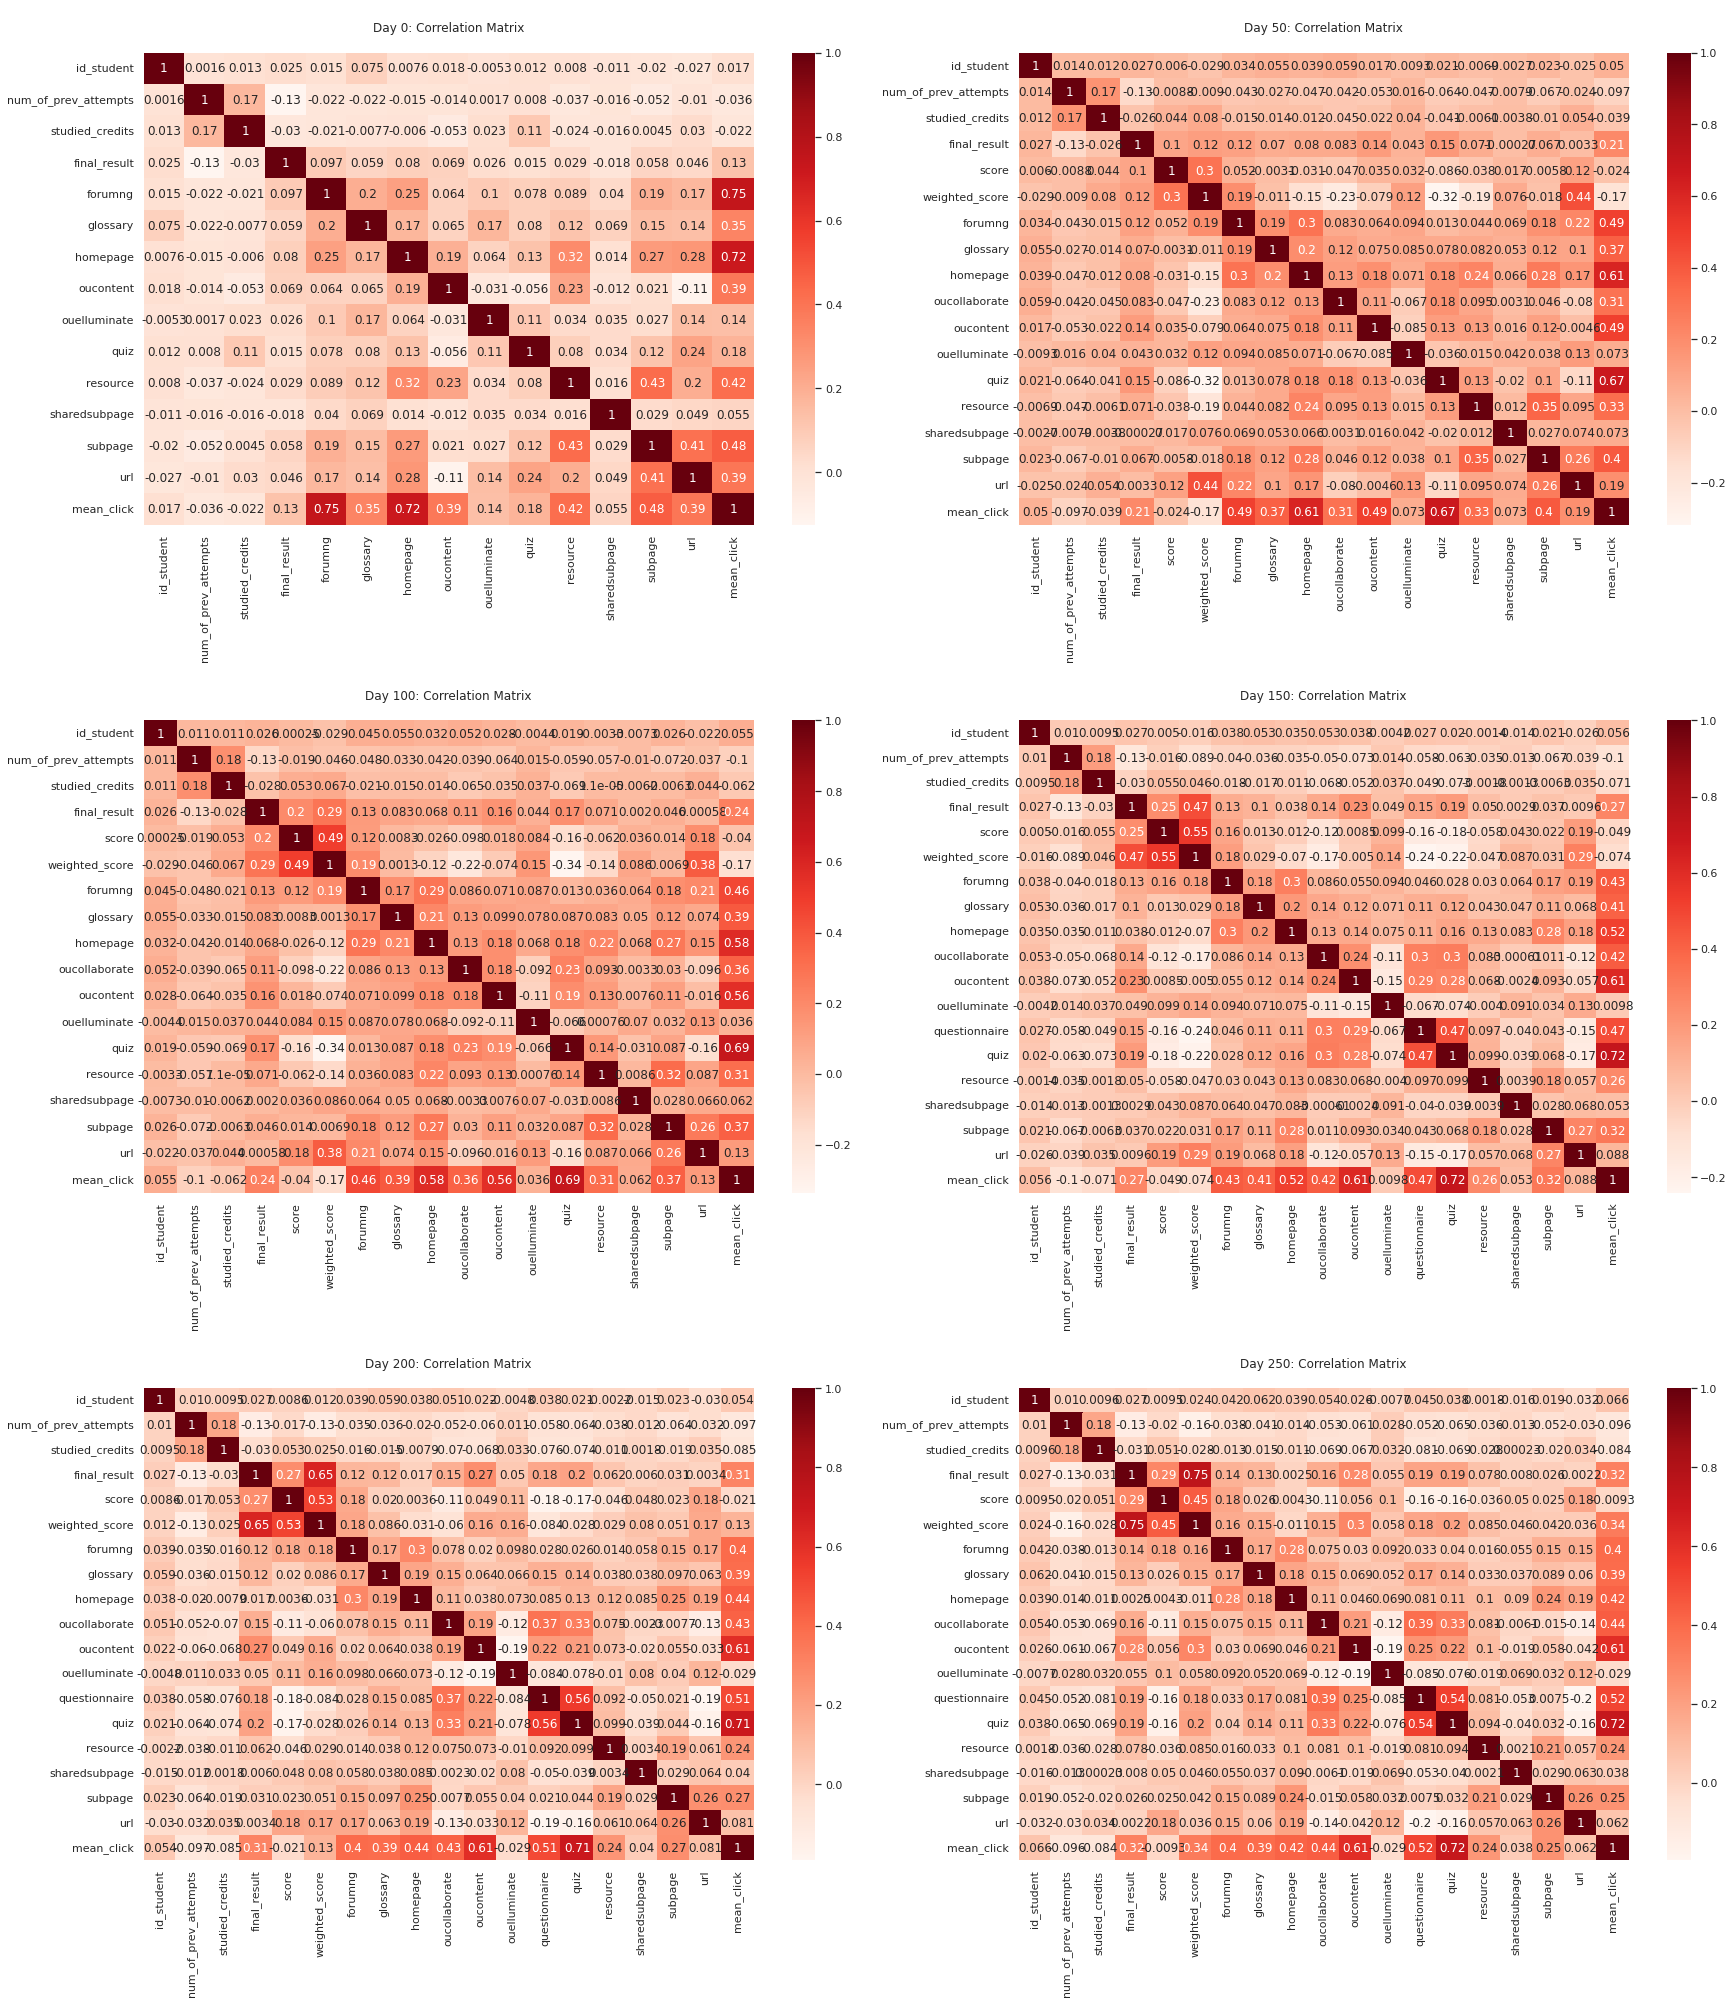

In [ ]:
plot_correlation_matrix(df)

## Make predictions

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2, f_classif, SelectFdr, SelectFpr
from sklearn.decomposition import PCA

### 2013J | 2014J predictions

#### Demographic data

##### Prepare data for prediction

In [ ]:
demographic_df = {}
for i in df.keys():
  demographic_df[i] = split_dataframe_by_data_type(df[i], ['demographic'], include_final_result=True)

###### Encode data

In [ ]:
X_train, X_test, Y_train, Y_test = encode_data(demographic_df, ["2013J"], "2014J")

Index(['gender', 'region', 'highest_education', 'imd_band', 'age_band',
       'disability'],
      dtype='object') Index([], dtype='object')
Index(['gender', 'region', 'highest_education', 'imd_band', 'age_band',
       'disability'],
      dtype='object') Index([], dtype='object')
Index(['gender', 'region', 'highest_education', 'imd_band', 'age_band',
       'disability'],
      dtype='object') Index([], dtype='object')
Index(['gender', 'region', 'highest_education', 'imd_band', 'age_band',
       'disability'],
      dtype='object') Index([], dtype='object')
Index(['gender', 'region', 'highest_education', 'imd_band', 'age_band',
       'disability'],
      dtype='object') Index([], dtype='object')
Index(['gender', 'region', 'highest_education', 'imd_band', 'age_band',
       'disability'],
      dtype='object') Index([], dtype='object')


In [ ]:
X_train[0].shape

(1144, 35)

###### Undersampling

In [ ]:
Y_train[0].value_counts()

1    841
0    303
Name: final_result, dtype: int64

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

from collections import Counter

X_train_sample, Y_train_sample = {},{}

for i in df.keys():

  sampler = RandomUnderSampler() # fit predictor and target variable
  X_train_sample[i], Y_train_sample[i] = sampler.fit_resample(X_train[i], Y_train[i])

  print(f"Sampling for day {i}")
  print('Original dataset shape:', Counter(Y_train[i]))
  print('Resample dataset shape', Counter(Y_train_sample[i]))

Sampling for day 0
Original dataset shape: Counter({1: 841, 0: 303})
Resample dataset shape Counter({0: 303, 1: 303})
Sampling for day 50
Original dataset shape: Counter({1: 1053, 0: 414})
Resample dataset shape Counter({0: 414, 1: 414})
Sampling for day 100
Original dataset shape: Counter({1: 1060, 0: 417})
Resample dataset shape Counter({0: 417, 1: 417})
Sampling for day 150
Original dataset shape: Counter({1: 1063, 0: 421})
Resample dataset shape Counter({0: 421, 1: 421})
Sampling for day 200
Original dataset shape: Counter({1: 1063, 0: 421})
Resample dataset shape Counter({0: 421, 1: 421})
Sampling for day 250
Original dataset shape: Counter({1: 1064, 0: 421})
Resample dataset shape Counter({0: 421, 1: 421})


###### Feature selection

In [ ]:
for i in df.keys():
  feature_selection_transformer = SelectKBest(score_func=chi2, k=20)

  X_train[i] = pd.DataFrame(feature_selection_transformer.fit_transform(X_train[i], Y_train[i]))
  
  X_test[i] = pd.DataFrame(feature_selection_transformer.transform(X_test[i]))

In [ ]:
X_train[250]

0    1    2    3    4    5    6   ...   13   14   15   16   17   18   19
0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  1.0  0.0  0.0
1     0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  1.0  1.0
2     0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  1.0  0.0  0.0  1.0  0.0  1.0
3     0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  1.0  0.0
4     0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  1.0  0.0  0.0
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
1480  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  1.0  0.0  0.0
1481  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  1.0  0.0
1482  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...  0.0  0.0  0.0  0.0  1.0  0.0  1.0
1483  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  1.0  0.0  0.0  0.0  1.0  0.0  0.0
1484  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...  1.0  0.0  0.0  0.0  1.0  0.0  0.0

[1485 rows x 20 columns]

##### DummyClassifier

In [ ]:
from sklearn.dummy import DummyClassifier

demographic_results_du = []

pipeline = Pipeline([
    ('clf', DummyClassifier(strategy="uniform",random_state=RANDOM_SEED)),
])

params = {
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  demographic_results_du.append([acc, f1, prec, recall, conf])
  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.466
Best parameters set:
Accuracy: 0.48218940052128584, F1 Score: 0.5945578231292517, Precision: 0.76, Recall: 0.488268156424581


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.516
Best parameters set:
Accuracy: 0.49176954732510286, F1 Score: 0.6022544283413849, Precision: 0.7684931506849315, Recall: 0.49514563106796117


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.497
Best parameters set:
Accuracy: 0.491869918699187, F1 Score: 0.6014877789585547, Precision: 0.7658998646820027, Recall: 0.49518810148731407


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.481
Best parameters 

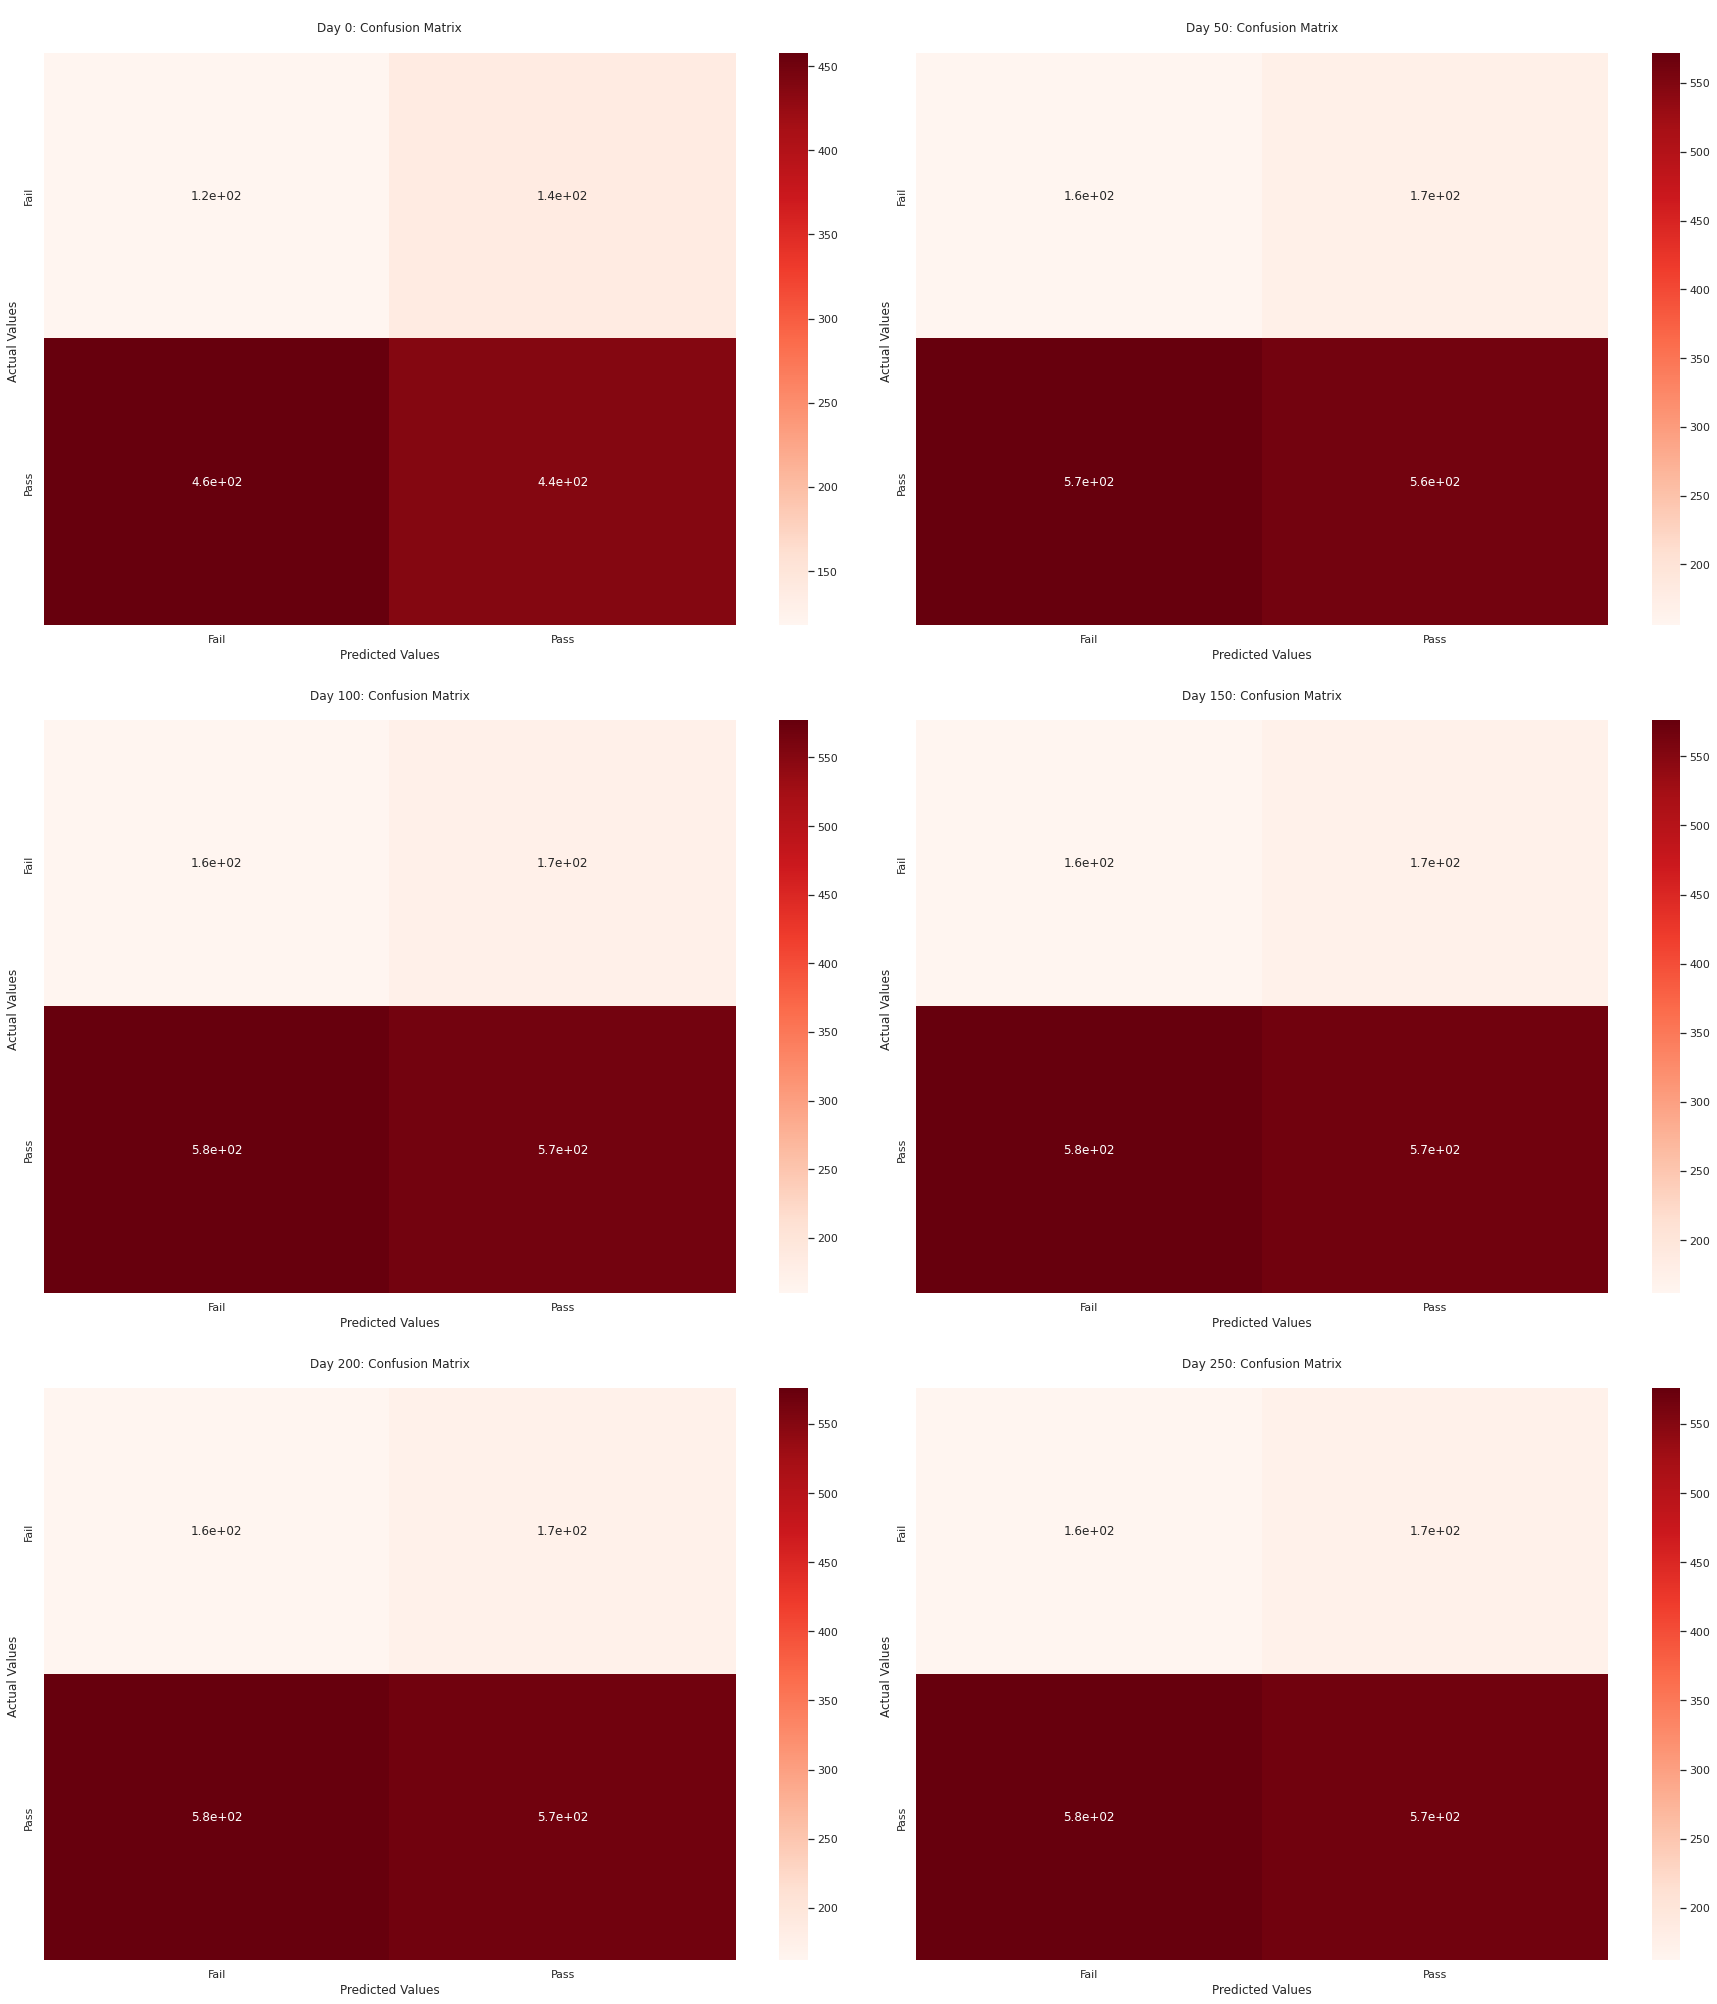

In [ ]:
plot_confusion_matrix(demographic_results_du)

##### NaiveBayes

BernoulliNB is used as it is specfically designed for binary/boolean features.

In [ ]:
from sklearn.naive_bayes import GaussianNB,ComplementNB,BernoulliNB

demographic_results_nb = []

pipeline = Pipeline([
    ('clf', BernoulliNB(binarize=None)),
])

params = {
  #'clf__class_weight':({0:2,1:1},{0:3,1:1},{0:1.5,1:1})
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  demographic_results_nb.append([acc, f1, prec, recall, conf])
  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.601
Best parameters set:
Accuracy: 0.73501303214596, F1 Score: 0.8343291689299295, Precision: 0.8118393234672304, Recall: 0.8581005586592179


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.561
Best parameters set:
Accuracy: 0.7304526748971193, F1 Score: 0.8318356867779204, Precision: 0.8073089700996677, Recall: 0.8578993821712269


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.558
Best parameters set:
Accuracy: 0.7303523035230353, F1 Score: 0.8313559322033898, Precision: 0.8060805258833197, Recall: 0.8582677165354331


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.556
Best p

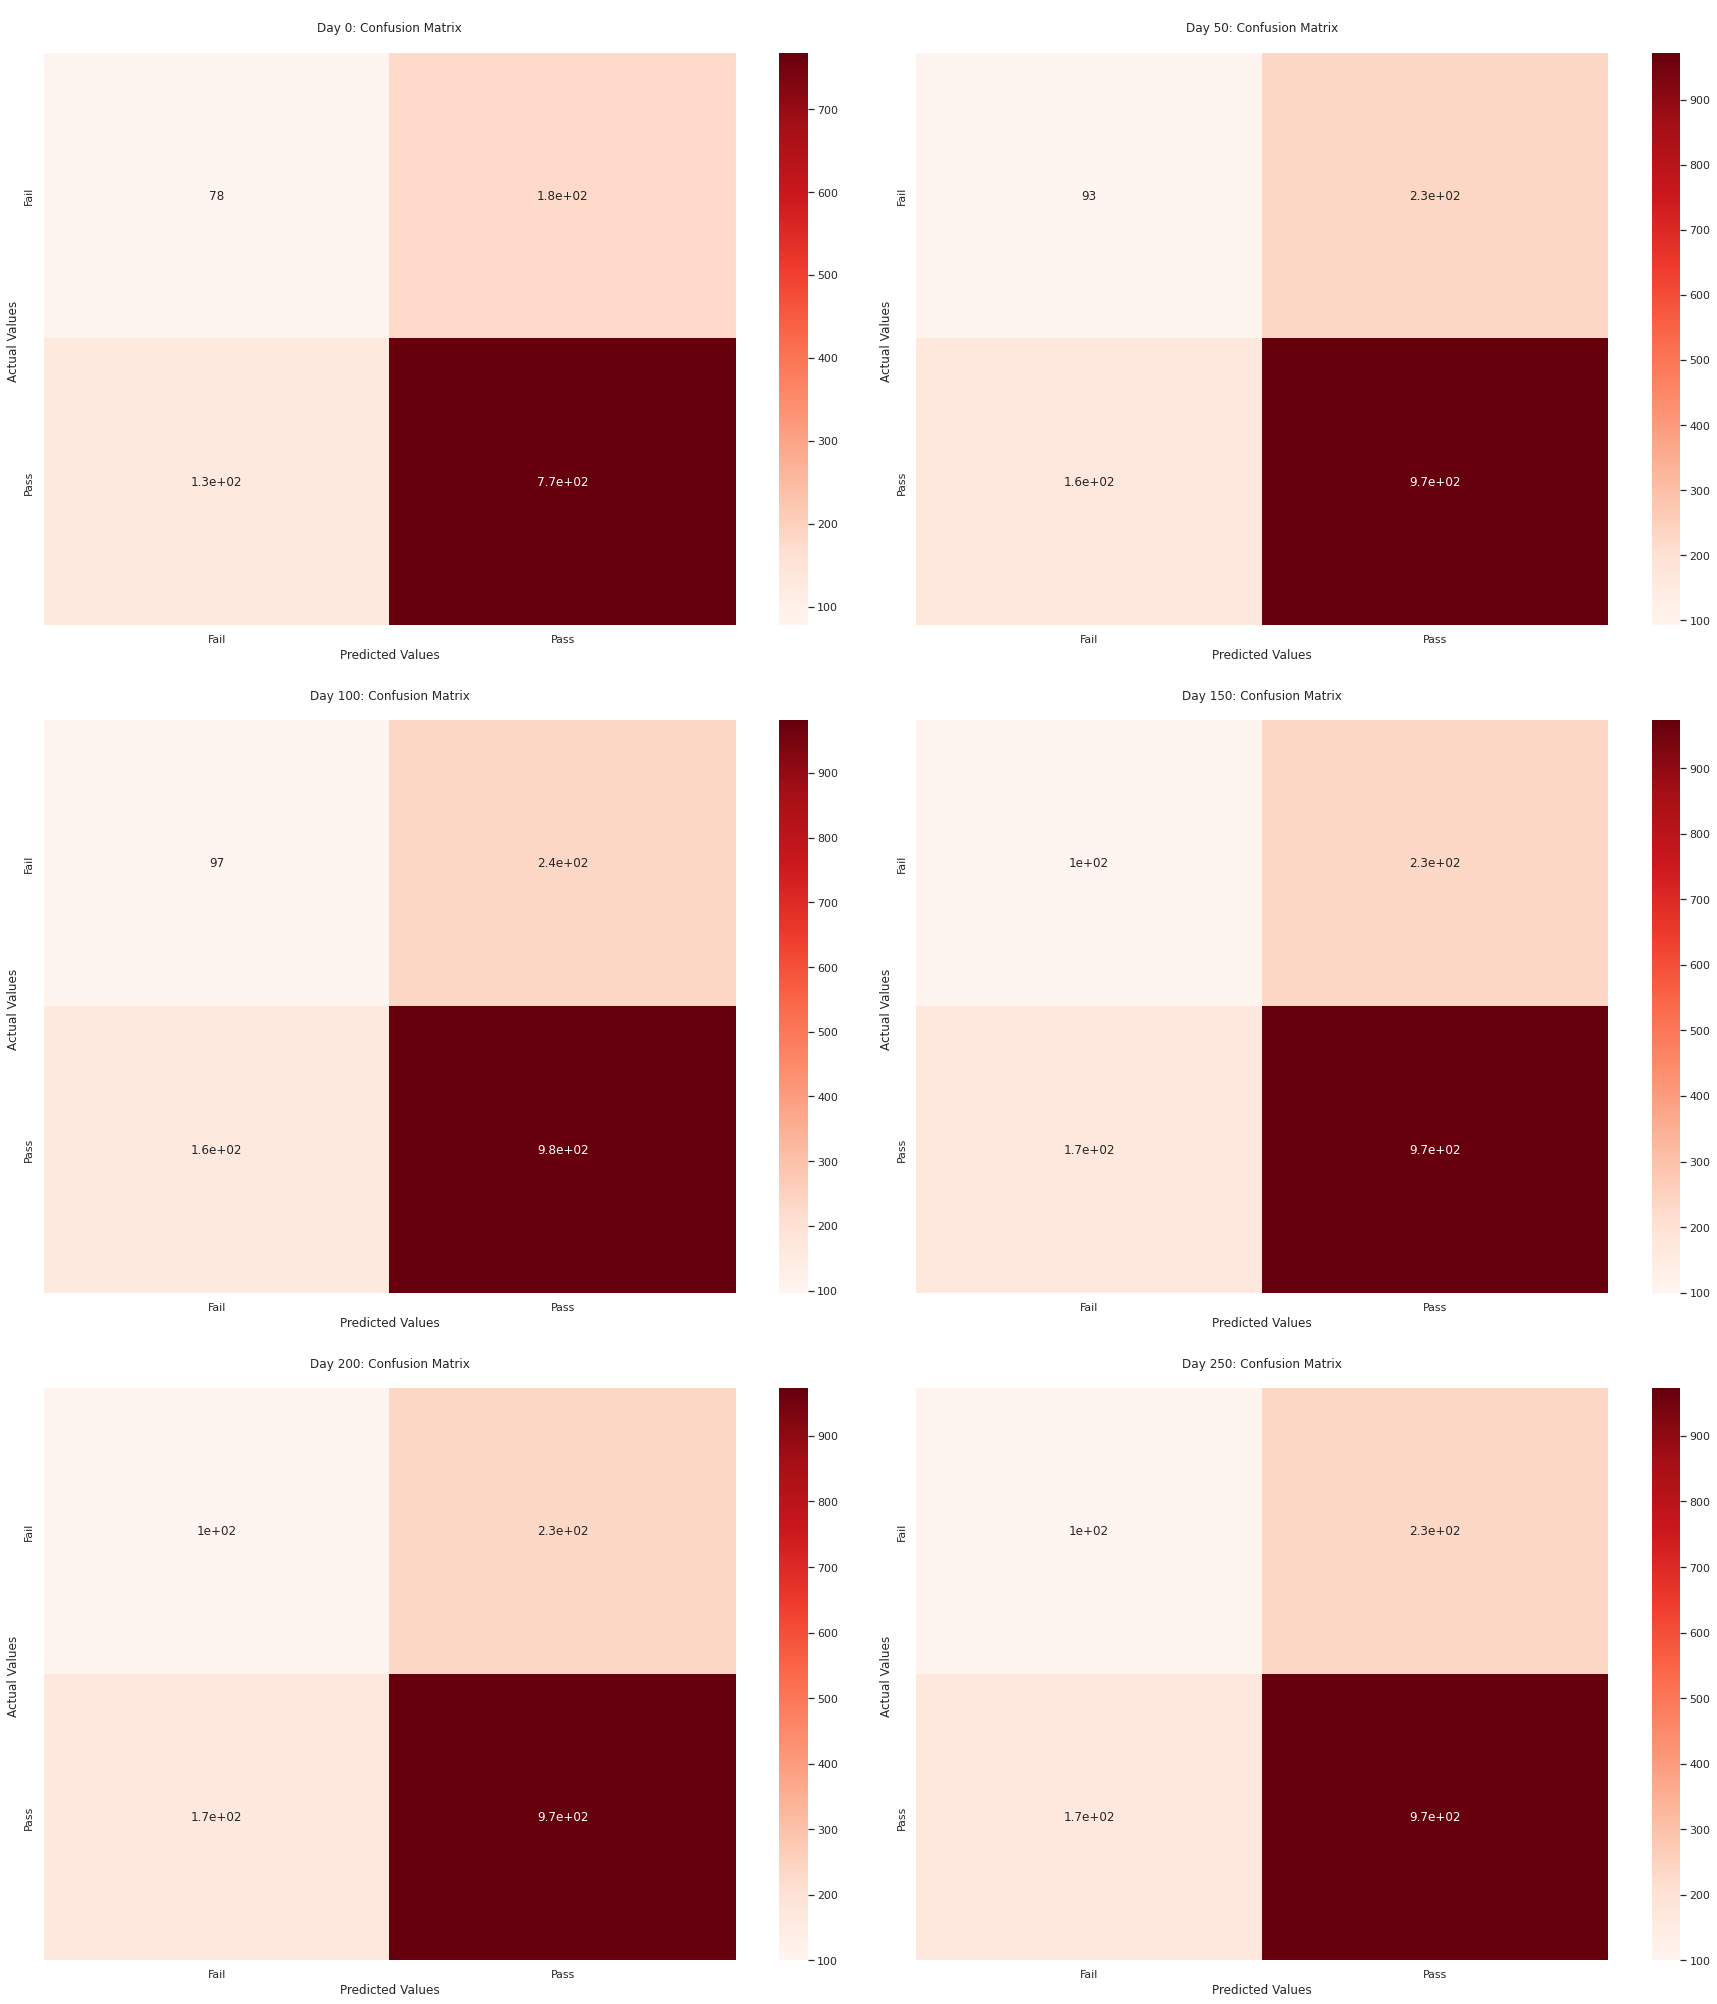

In [ ]:
plot_confusion_matrix(demographic_results_nb)

##### LogisticRegression

ovr is used for binary problems

In [ ]:
from sklearn.linear_model import LogisticRegression

demographic_results_lr = []

pipeline = Pipeline([
    ('clf', LogisticRegression(multi_class='ovr')),
])

params = {
  'clf__penalty': ['l2', 'none']
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  demographic_results_lr.append([acc, f1, prec, recall, conf])
  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.567
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.7584708948740226, F1 Score: 0.8585961342828077, Precision: 0.7880485527544351, Recall: 0.9430167597765363


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.522
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.7517146776406035, F1 Score: 0.85426731078905, Precision: 0.7853441894892672, Recall: 0.9364518976169461


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.517
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.7506775067750677, F1 Score: 0.853386454183267, Precision: 0.783467446964155, Recall: 0.937007874015748

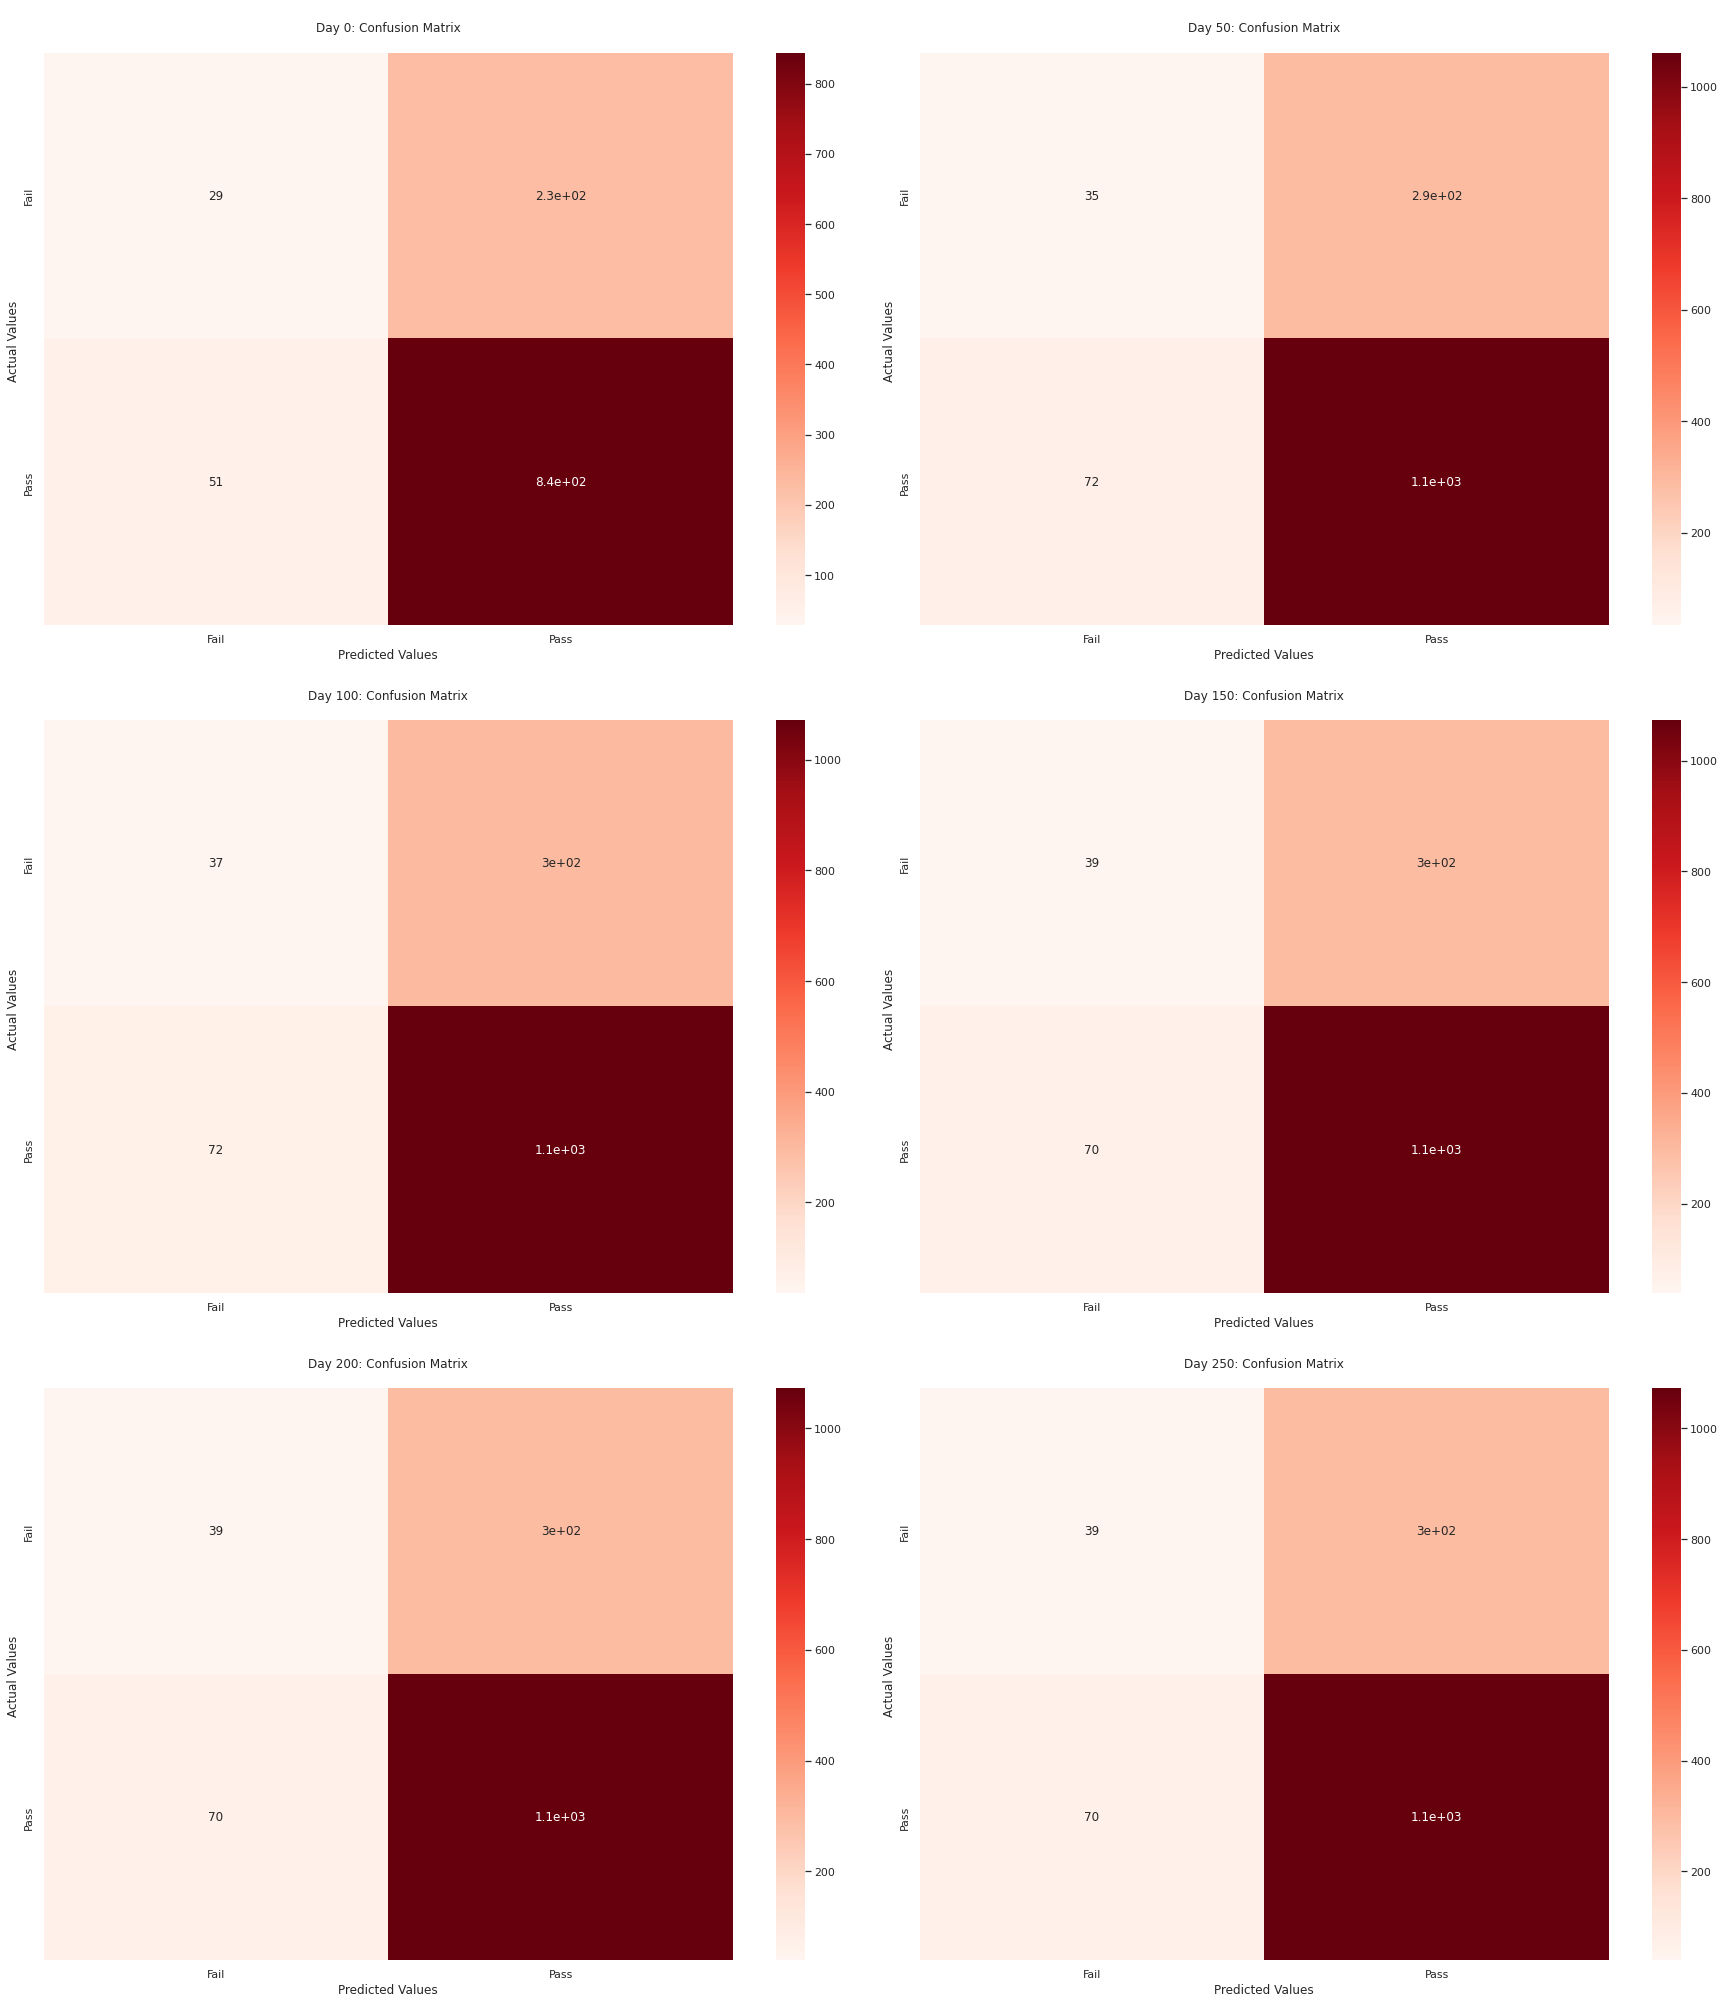

In [ ]:
plot_confusion_matrix(demographic_results_lr)

##### WeightedLogisticRegression

In [ ]:
demographic_results_lrw = []

pipeline = Pipeline([
    ('clf', LogisticRegression(multi_class='ovr', class_weight = 'balanced')),
])

params = {
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  demographic_results_lrw.append([acc, f1, prec, recall, conf])
  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.578
Best parameters set:
Accuracy: 0.6133796698523023, F1 Score: 0.7149263292761051, Precision: 0.8378378378378378, Recall: 0.623463687150838


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.569
Best parameters set:
Accuracy: 0.5946502057613169, F1 Score: 0.69954245043213, Precision: 0.8249400479616307, Recall: 0.6072374227714034


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.574
Best parameters set:
Accuracy: 0.5968834688346883, F1 Score: 0.6996466431095406, Precision: 0.8269689737470167, Recall: 0.6062992125984252


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.564
Best pa

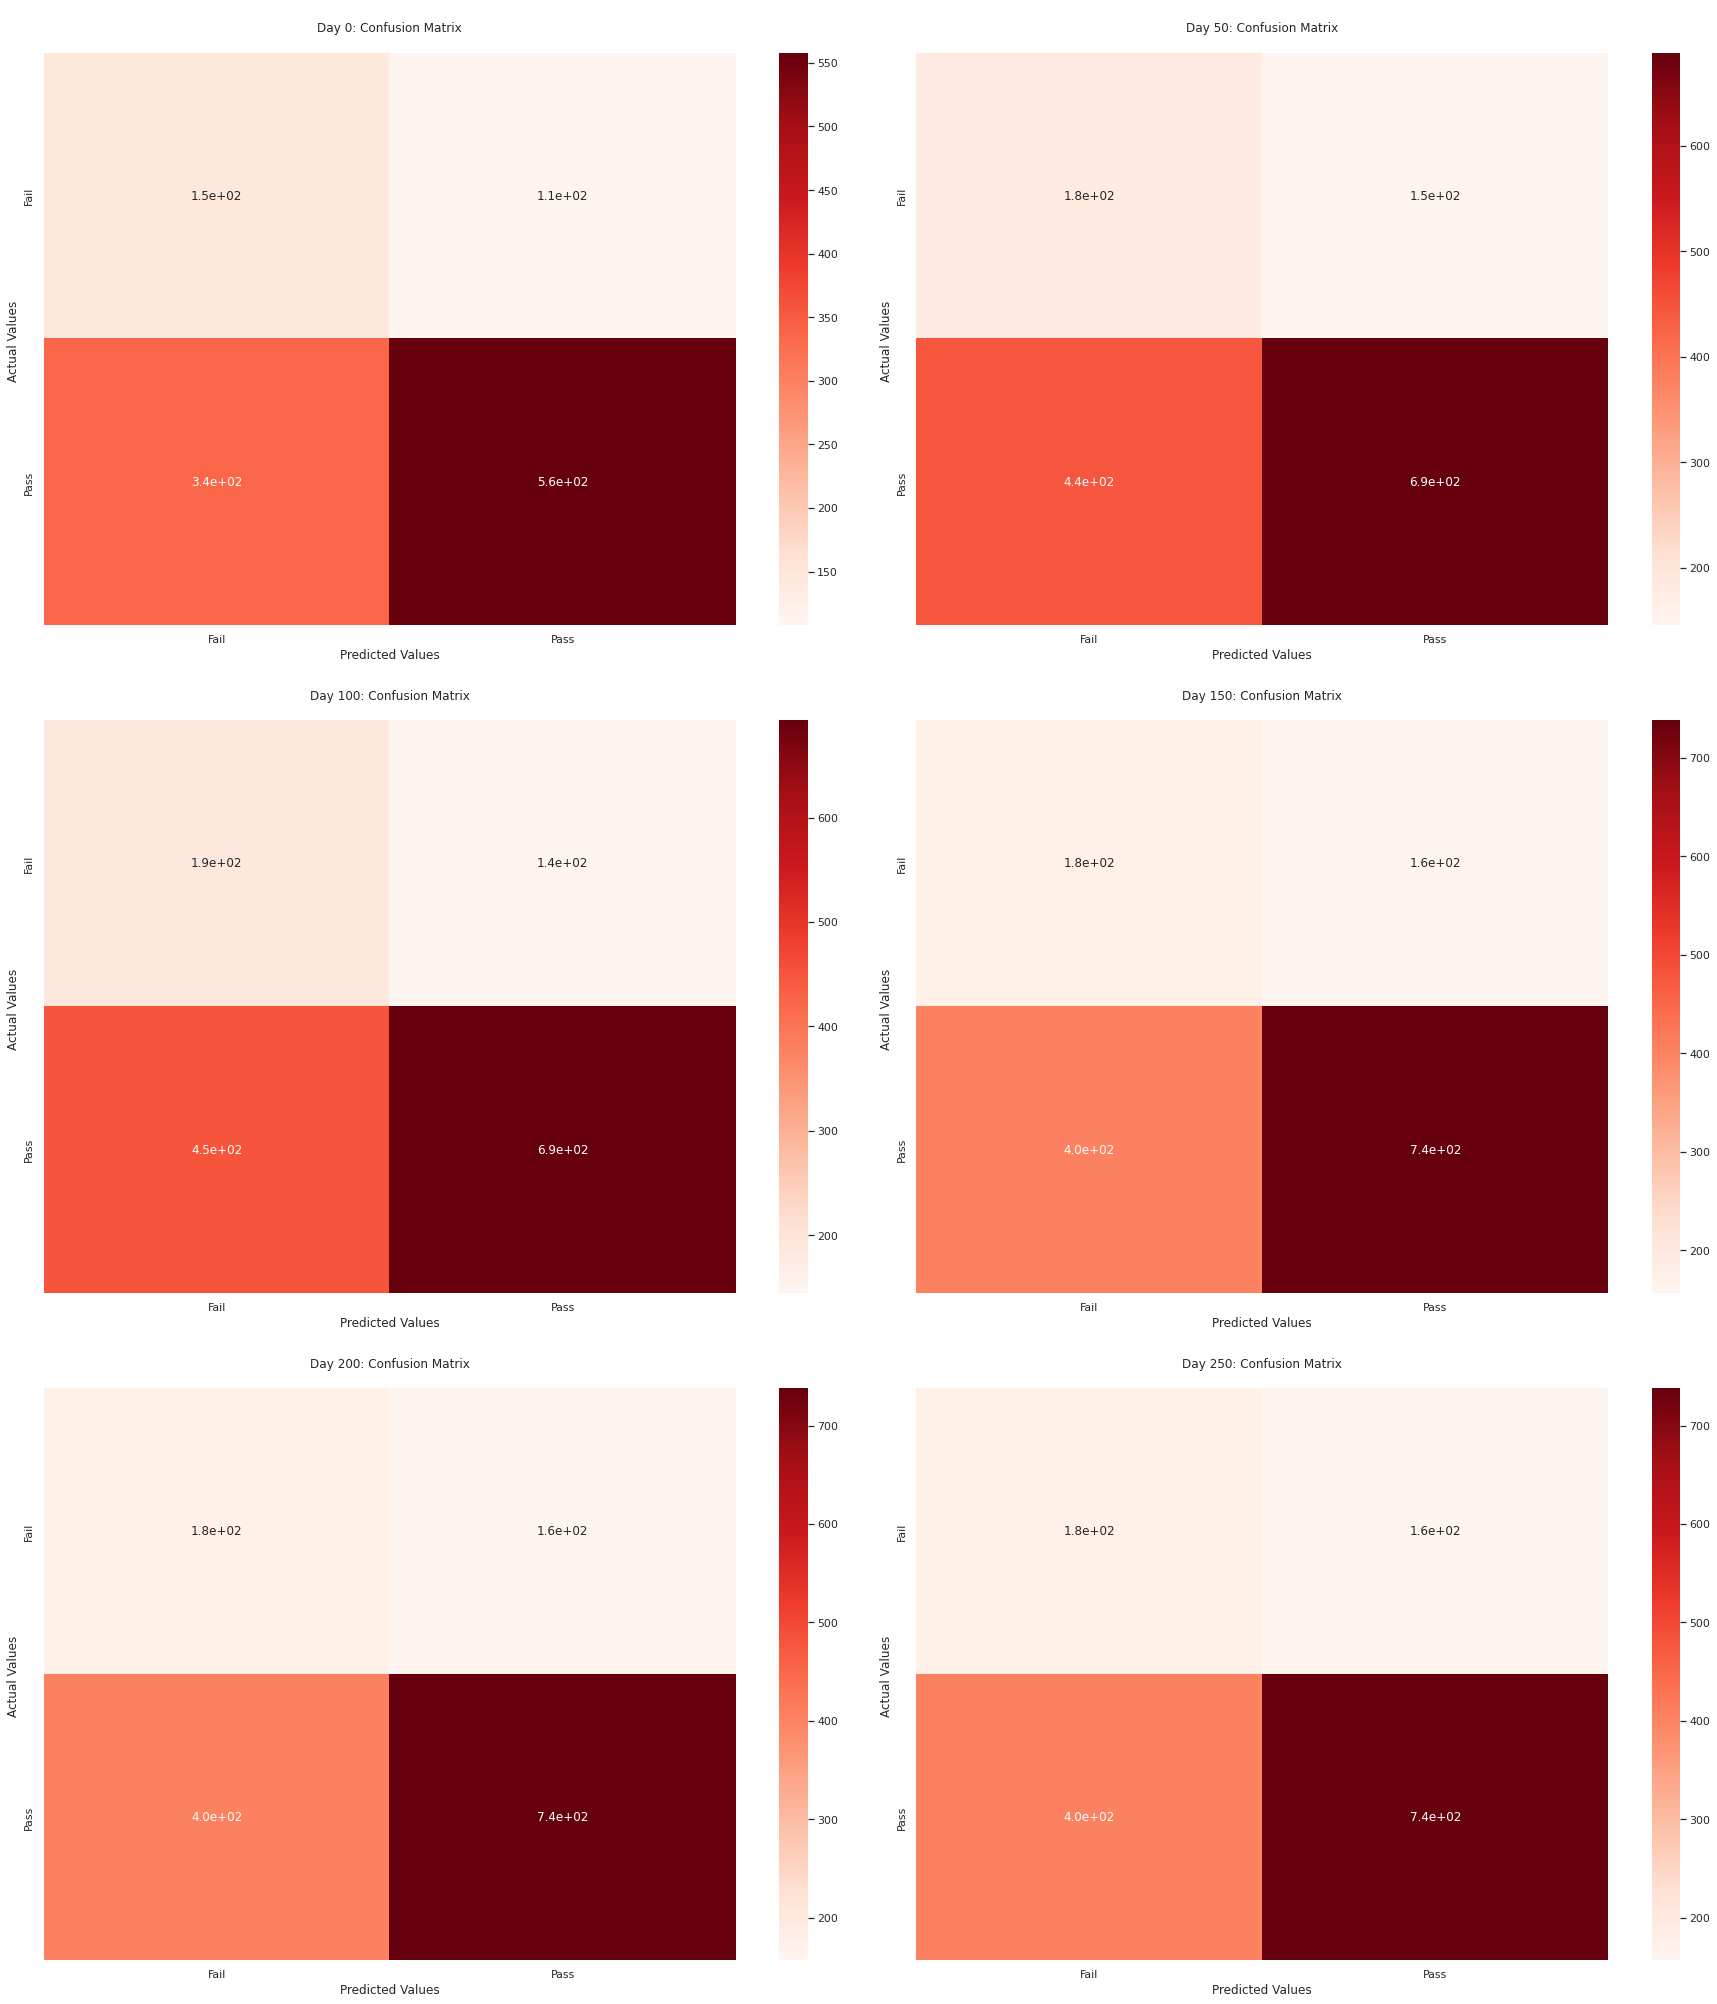

In [ ]:
plot_confusion_matrix(demographic_results_lrw)

##### RandomForest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

demographic_results_rf = []

pipeline = Pipeline([
    ('clf', RandomForestClassifier(random_state=RANDOM_SEED)),
])

params = {
  'clf__n_estimators': [x for x in range(50,150,10)]
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  demographic_results_rf.append([acc, f1, prec, recall, conf])
  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.563
Best parameters set:
	clf__n_estimators: 80
Accuracy: 0.7124239791485665, F1 Score: 0.8217555196553581, Precision: 0.7931392931392931, Recall: 0.852513966480447


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.543
Best parameters set:
	clf__n_estimators: 50
Accuracy: 0.7359396433470508, F1 Score: 0.8413679439637413, Precision: 0.7890262751159196, Recall: 0.9011473962930273


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.541
Best parameters set:
	clf__n_estimators:

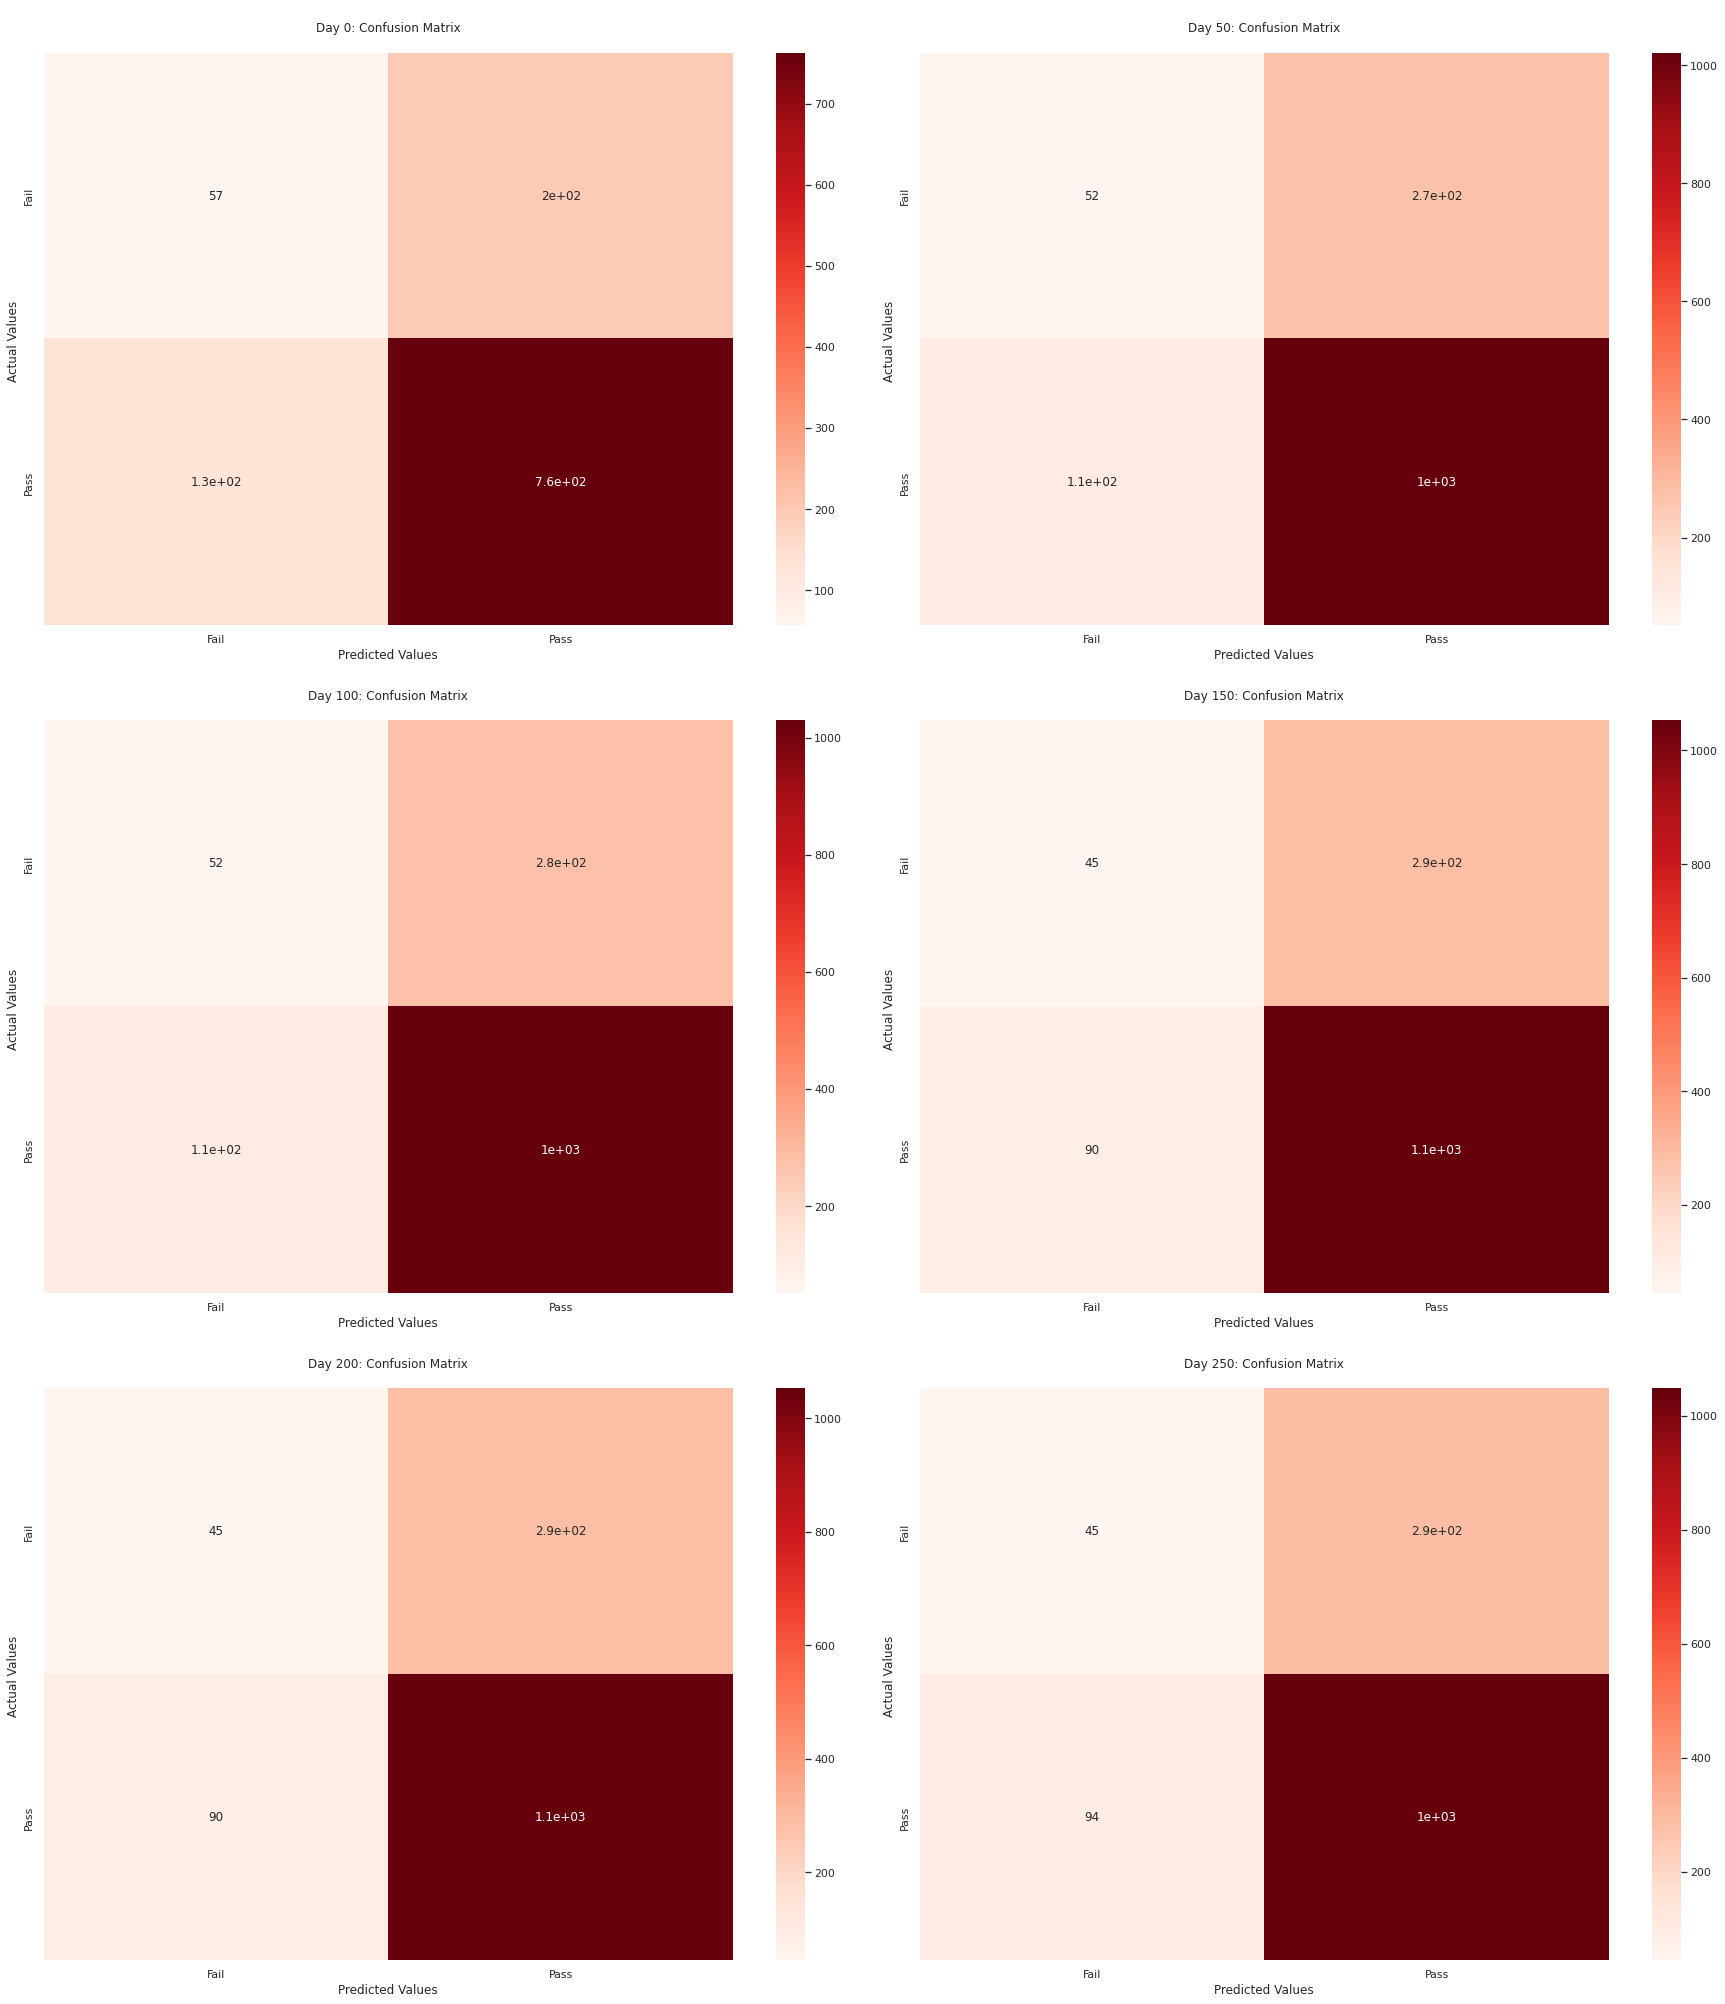

In [ ]:
plot_confusion_matrix(demographic_results_rf)

##### AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

demographic_results_ab = []

pipeline = Pipeline([
    ('clf', AdaBoostClassifier(random_state=RANDOM_SEED)),
])

params = {
  'clf__learning_rate':(0.5,0.85,1,1.25,1.5,1.75)
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  demographic_results_ab.append([acc, f1, prec, recall, conf])
  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.572
Best parameters set:
	clf__learning_rate: 1.5
Accuracy: 0.7471763683753258, F1 Score: 0.8503856041131106, Precision: 0.7876190476190477, Recall: 0.924022346368715


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.525
Best parameters set:
	clf__learning_rate: 1.75
Accuracy: 0.7599451303155007, F1 Score: 0.8610007942811756, Precision: 0.7826714801444044, Recall: 0.9567519858781994


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.522
Best parameters set:
	clf__learning_rate: 0.85
Accuracy: 0.7513550135501355, 

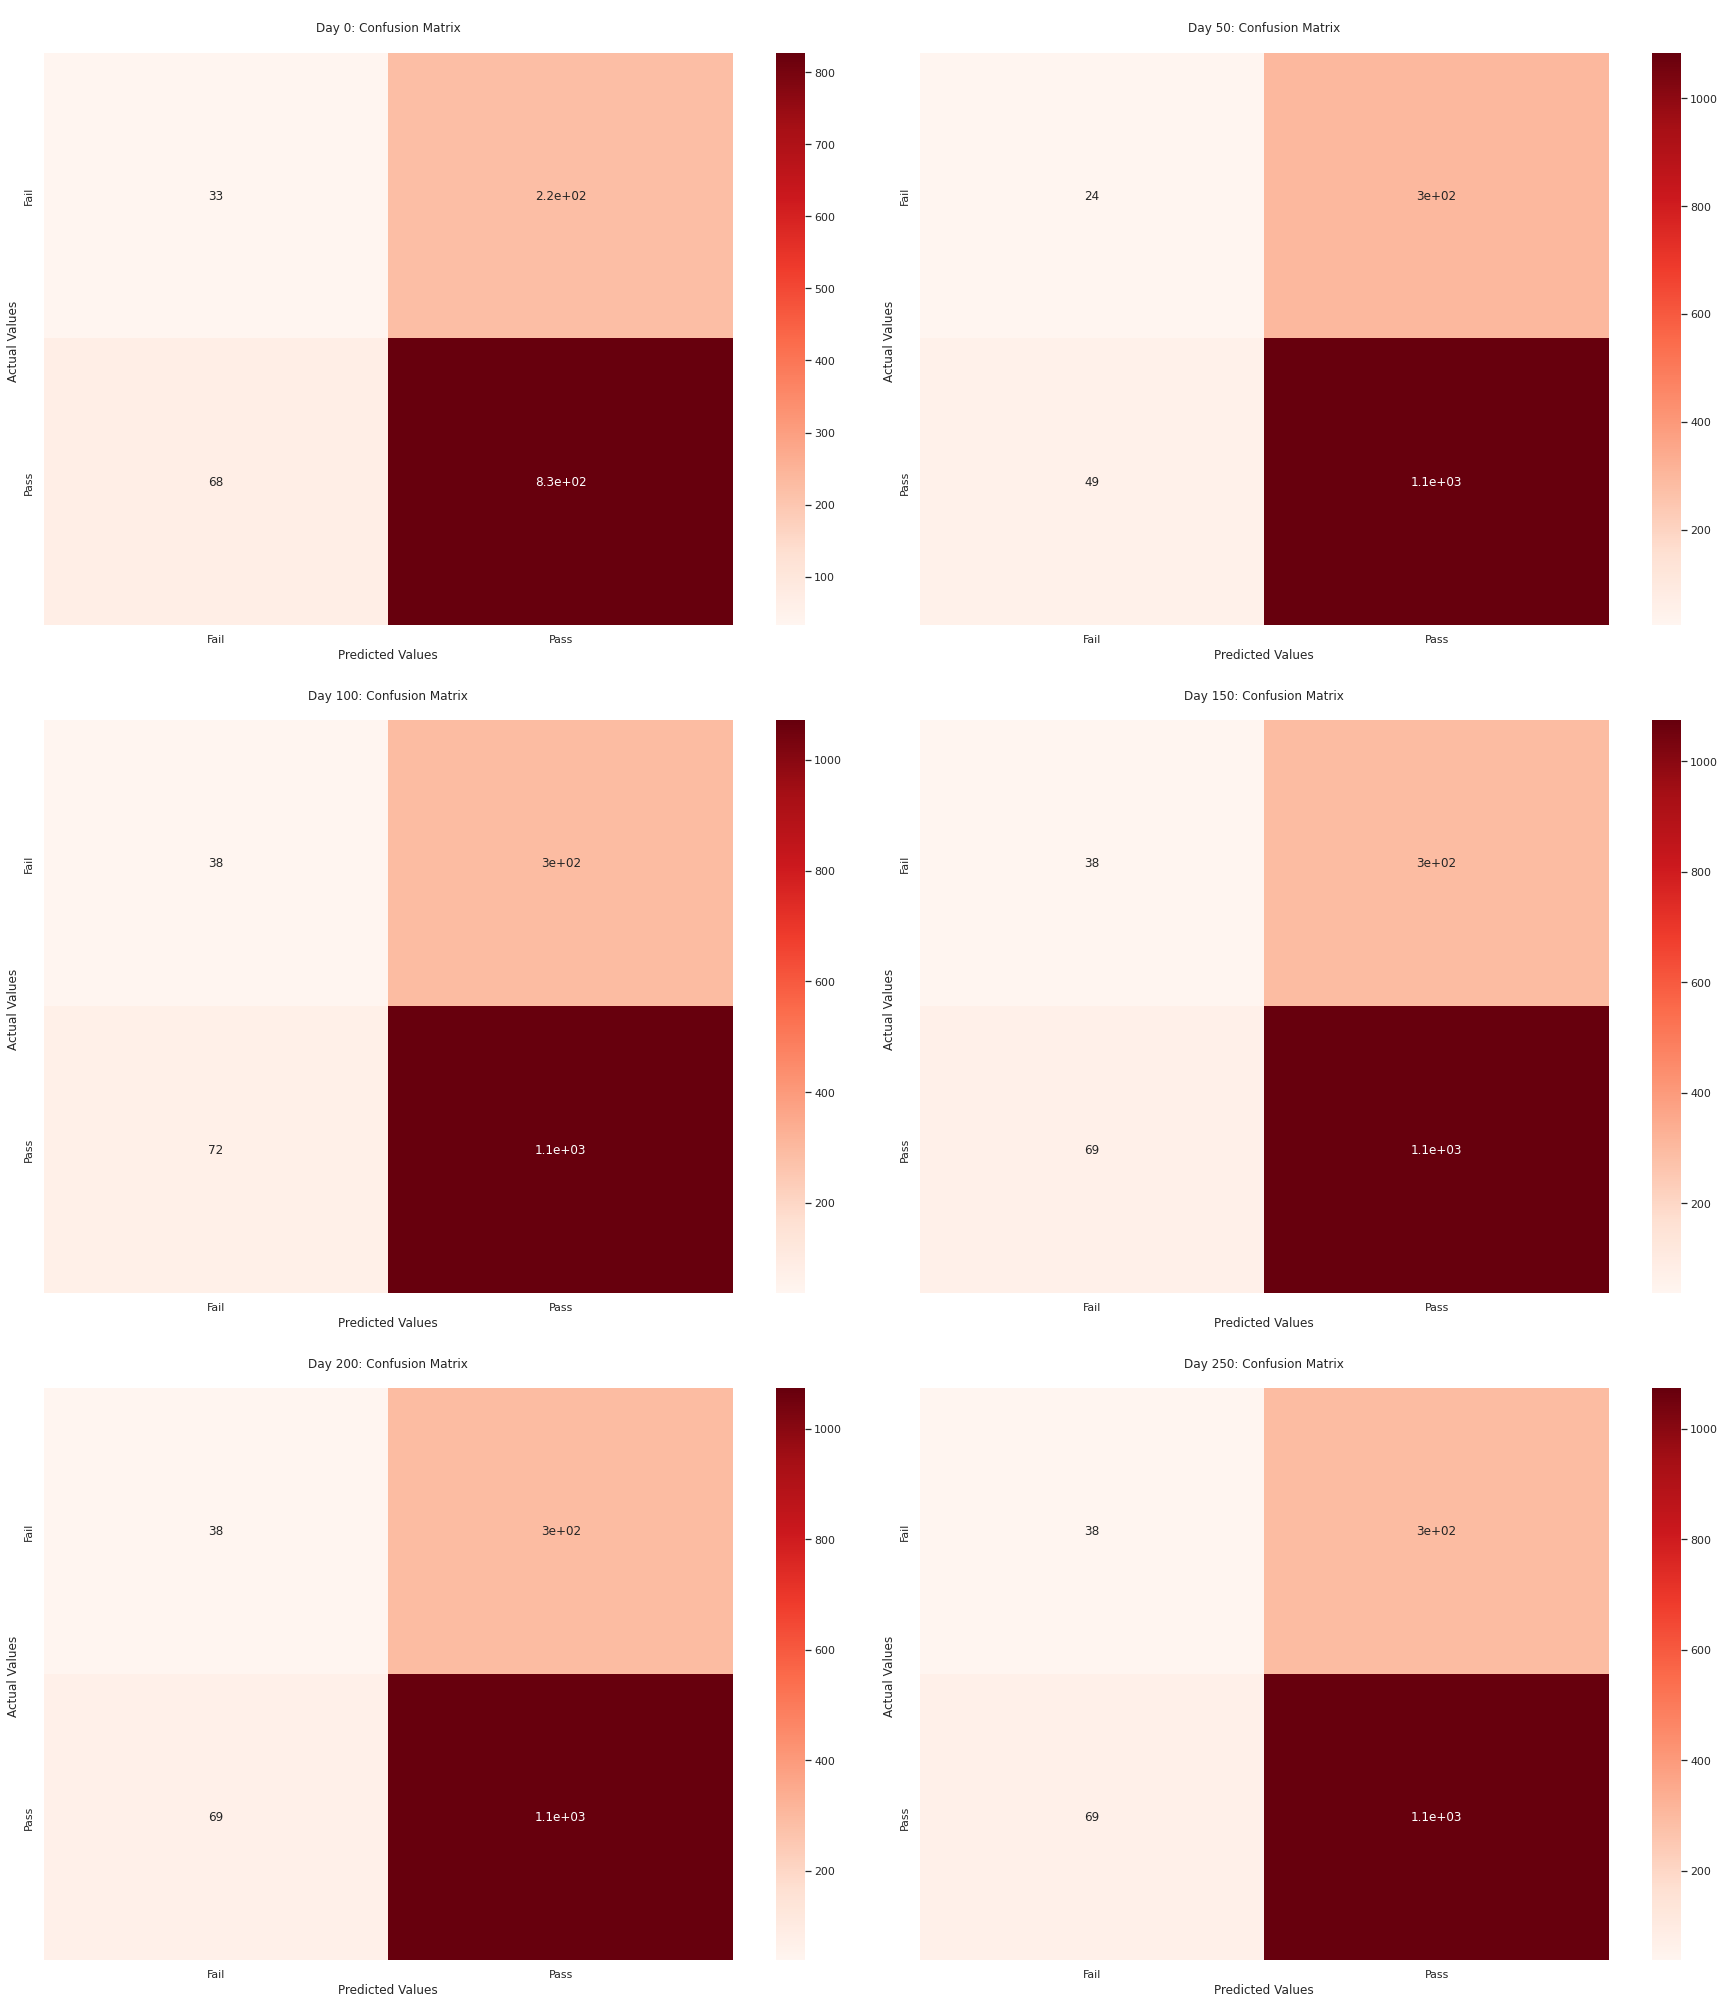

In [ ]:
plot_confusion_matrix(demographic_results_ab)

##### Plot results overview

In [ ]:
demographic_classifier_results = [demographic_results_du, demographic_results_nb, demographic_results_lr, demographic_results_lrw, demographic_results_rf, demographic_results_ab]
demographic_classifier_labels = ["Dummy Classifier","Naive Bayes", "Logistic Regression", "Logistic Regression Weighted", "Random Forest", "AdaBoost"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-

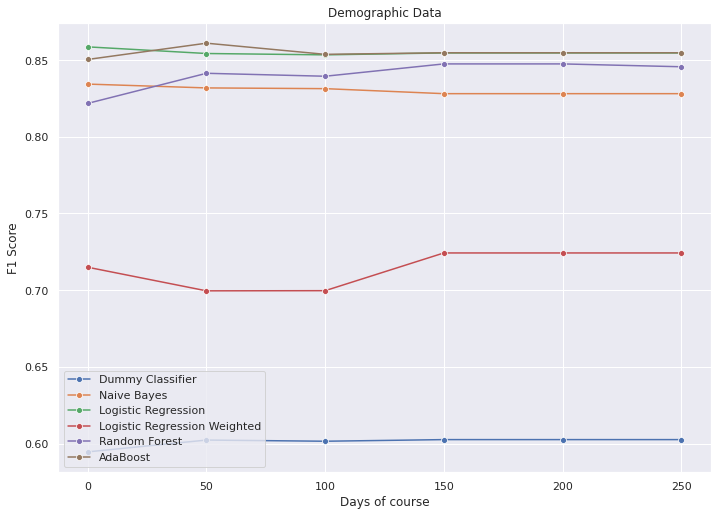

In [ ]:
plot_days_compare(deadline_list,demographic_classifier_results,demographic_classifier_labels, "Demographic Data")

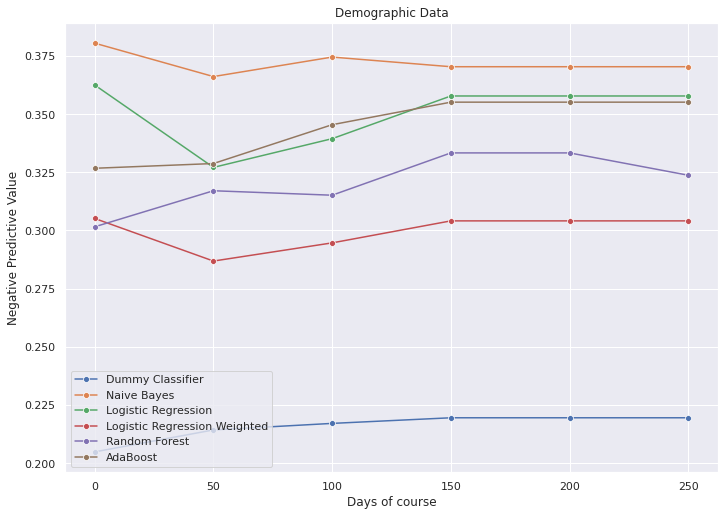

In [ ]:
plot_days_compare_npv(deadline_list,demographic_classifier_results,demographic_classifier_labels, "Demographic Data")

#### Learning behaviour data

##### Prepare data for prediction

In [ ]:
learning_behaviour_df = {}
for i in df.keys():
  learning_behaviour_df[i] = split_dataframe_by_data_type(df[i], ['learning_behaviour'], include_final_result=True)

In [ ]:
learning_behaviour_df[250]

code_presentation  id_student  ...   forumng  final_result
0                2013B       23629  ...  3.863636             0
1                2013B       25107  ...  5.303448             1
2                2013B       29144  ...  3.223140             0
3                2013B       31663  ...  4.207955             1
4                2013B       34229  ...  3.324675             1
...                ...         ...  ...       ...           ...
5130             2014J     2688945  ...  1.000000             1
5131             2014J     2692969  ...  2.582192             1
5132             2014J     2694919  ...  7.588235             1
5133             2014J     2698577  ...  5.150000             0
5134             2014J     2698588  ...  2.695652             1

[5135 rows x 16 columns]

###### Encode data

In [ ]:
X_train, X_test, Y_train, Y_test = encode_data(learning_behaviour_df, ["2013J"], "2014J")

Index([], dtype='object') Index(['quiz', 'resource', 'glossary', 'mean_click', 'homepage',
       'sharedsubpage', 'subpage', 'url', 'oucontent', 'forumng'],
      dtype='object')
Index([], dtype='object') Index(['quiz', 'resource', 'glossary', 'mean_click', 'homepage',
       'sharedsubpage', 'subpage', 'oucollaborate', 'url', 'oucontent',
       'forumng'],
      dtype='object')
Index([], dtype='object') Index(['quiz', 'resource', 'glossary', 'mean_click', 'homepage',
       'sharedsubpage', 'subpage', 'oucollaborate', 'url', 'oucontent',
       'forumng'],
      dtype='object')
Index([], dtype='object') Index(['quiz', 'resource', 'glossary', 'mean_click', 'homepage',
       'sharedsubpage', 'subpage', 'oucollaborate', 'url', 'oucontent',
       'forumng'],
      dtype='object')
Index([], dtype='object') Index(['quiz', 'resource', 'glossary', 'mean_click', 'homepage',
       'sharedsubpage', 'subpage', 'oucollaborate', 'url', 'oucontent',
       'forumng'],
      dtype='object')
Inde

###### Undersampling

In [ ]:
Y_train[0].value_counts()

1    841
0    303
Name: final_result, dtype: int64

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

from collections import Counter

X_train_sample, Y_train_sample = {},{}

for i in df.keys():

  sampler = RandomUnderSampler() # fit predictor and target variable
  X_train_sample[i], Y_train_sample[i] = sampler.fit_resample(X_train[i], Y_train[i])

  print(f"Sampling for day {i}")
  print('Original dataset shape:', Counter(Y_train[i]))
  print('Resample dataset shape', Counter(Y_train_sample[i]))

Sampling for day 0
Original dataset shape: Counter({1: 841, 0: 303})
Resample dataset shape Counter({0: 303, 1: 303})
Sampling for day 50
Original dataset shape: Counter({1: 1053, 0: 414})
Resample dataset shape Counter({0: 414, 1: 414})
Sampling for day 100
Original dataset shape: Counter({1: 1060, 0: 417})
Resample dataset shape Counter({0: 417, 1: 417})
Sampling for day 150
Original dataset shape: Counter({1: 1063, 0: 421})
Resample dataset shape Counter({0: 421, 1: 421})
Sampling for day 200
Original dataset shape: Counter({1: 1063, 0: 421})
Resample dataset shape Counter({0: 421, 1: 421})
Sampling for day 250
Original dataset shape: Counter({1: 1064, 0: 421})
Resample dataset shape Counter({0: 421, 1: 421})


###### Feature selection

In [ ]:
for i in df.keys():
  feature_selection_transformer = SelectKBest(score_func=f_classif, k=5)

  X_train[i] = pd.DataFrame(feature_selection_transformer.fit_transform(X_train[i], Y_train[i]),
          columns=list(feature_selection_transformer.get_feature_names_out().tolist()),
          index=X_train[i].index)
  
  X_test[i] = pd.DataFrame(feature_selection_transformer.transform(X_test[i]),
          columns=list(feature_selection_transformer.get_feature_names_out().tolist()),
          index=X_test[i].index)

In [ ]:
X_train[250]

quiz  glossary  mean_click  oucontent   forumng
1135  0.236594  0.090909    0.407342   0.244444  0.105587
1136  0.330045  0.181818    0.345807   0.094444  0.077320
1137  0.242653  0.000000    0.429784   0.125000  0.384545
1138  0.268950  0.000000    0.402270   0.133333  0.180859
1139  0.285884  0.000000    0.497011   0.333333  0.159693
...        ...       ...         ...        ...       ...
2615  0.000000  0.000000    0.042079   0.000000  0.000000
2616  0.274031  0.227273    0.503093   0.176190  0.175356
2617  0.262974  0.000000    0.376955   0.283333  0.134021
2618  0.273548  0.000000    0.372525   0.122222  0.122423
2619  0.357007  0.000000    0.598541   0.550000  0.092047

[1485 rows x 5 columns]

##### DummyClassifier

In [ ]:
from sklearn.dummy import DummyClassifier

learning_behaviour_results_du = []
learning_behaviour_features_du = []

pipeline = Pipeline([
    ('clf', DummyClassifier(strategy="uniform",random_state=RANDOM_SEED)),
])

params = {
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  learning_behaviour_results_du.append([acc, f1, prec, recall, conf])
  learning_behaviour_features_du.append([tuned_model, X_test[i], Y_test[i]])
  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.466
Best parameters set:
Accuracy: 0.48218940052128584, F1 Score: 0.5945578231292517, Precision: 0.76, Recall: 0.488268156424581


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.516
Best parameters set:
Accuracy: 0.49176954732510286, F1 Score: 0.6022544283413849, Precision: 0.7684931506849315, Recall: 0.49514563106796117


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.497
Best parameters set:
Accuracy: 0.491869918699187, F1 Score: 0.6014877789585547, Precision: 0.7658998646820027, Recall: 0.49518810148731407


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.481
Best parameters 

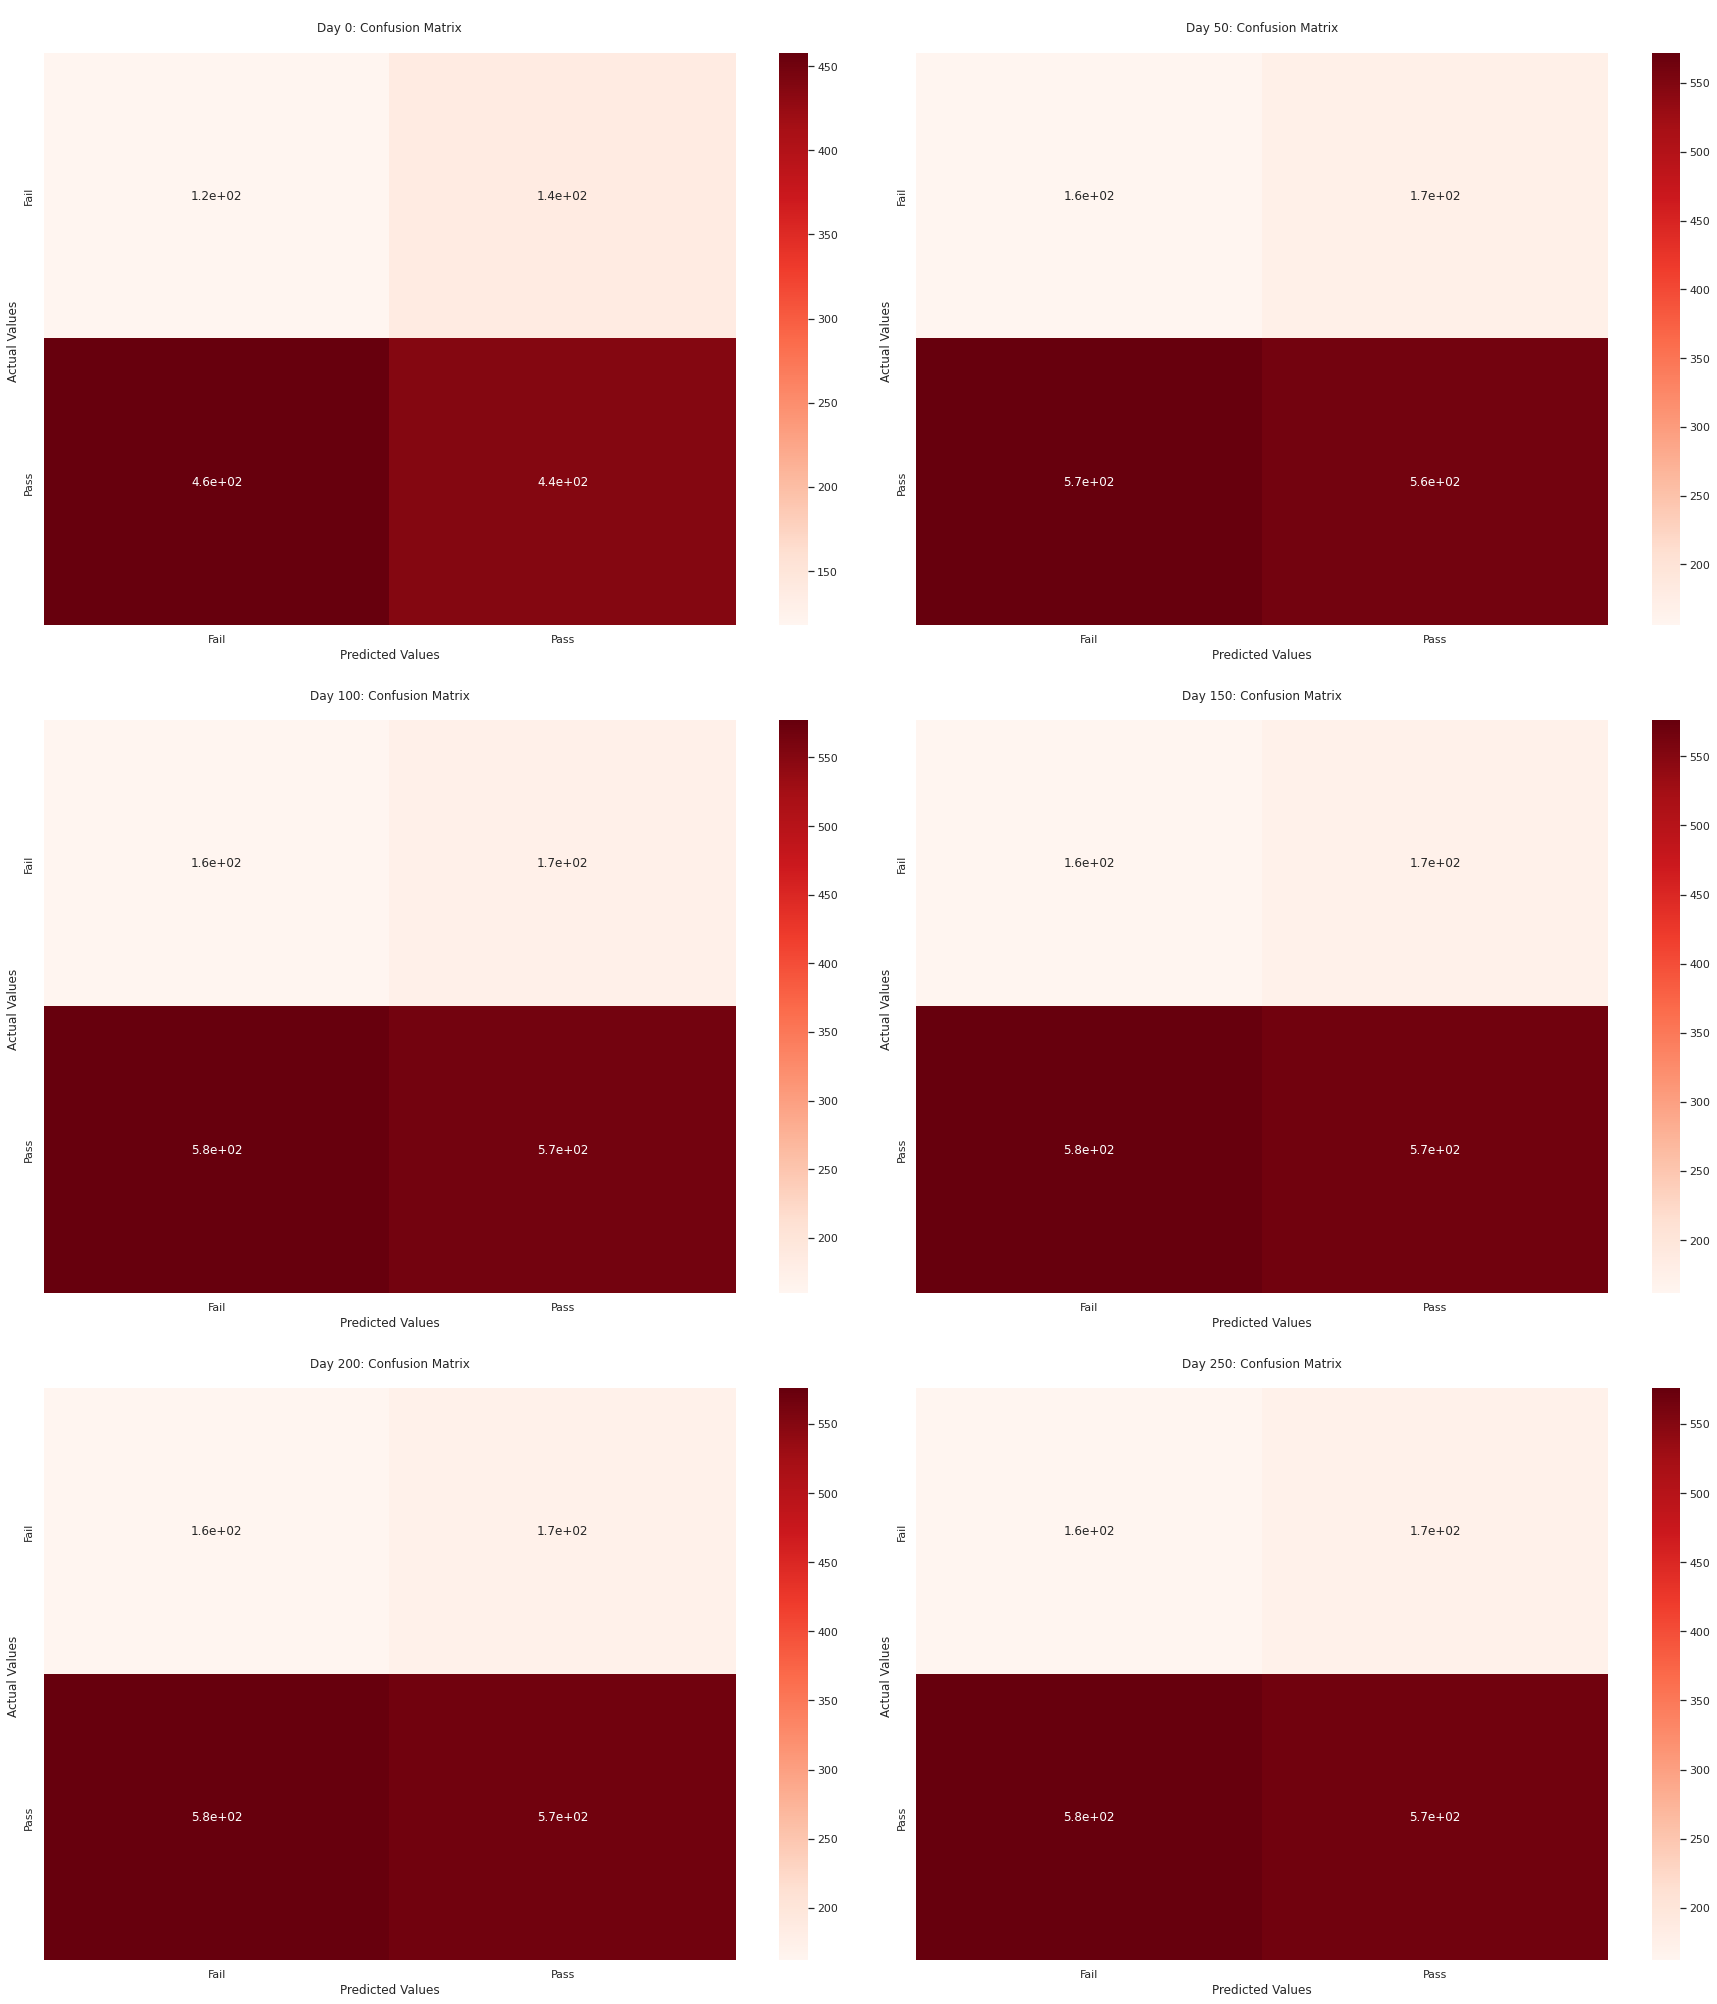

In [ ]:
plot_confusion_matrix(learning_behaviour_results_du)

##### NaiveBayes

In [ ]:
from sklearn.naive_bayes import GaussianNB,ComplementNB,BernoulliNB,MultinomialNB

learning_behaviour_results_nb = []
learning_behaviour_features_nb = []

pipeline = Pipeline([
    ('clf', ComplementNB()),
])

params = {
  #'clf__class_weight':({0:2,1:1},{0:3,1:1},{0:1.5,1:1})
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  learning_behaviour_results_nb.append([acc, f1, prec, recall, conf])
  learning_behaviour_features_nb.append([tuned_model, X_test[i], Y_test[i]])
  print("\n")


Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.468
Best parameters set:
Accuracy: 0.5056472632493484, F1 Score: 0.6018194541637508, Precision: 0.8052434456928839, Recall: 0.48044692737430167


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.516
Best parameters set:
Accuracy: 0.6412894375857339, F1 Score: 0.7541137752703339, Precision: 0.806841046277666, Recall: 0.707855251544572


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.484
Best parameters set:
Accuracy: 0.4911924119241192, F1 Score: 0.6057742782152231, Precision: 0.7572178477690289, Recall: 0.5048118985126859


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.502
Best 

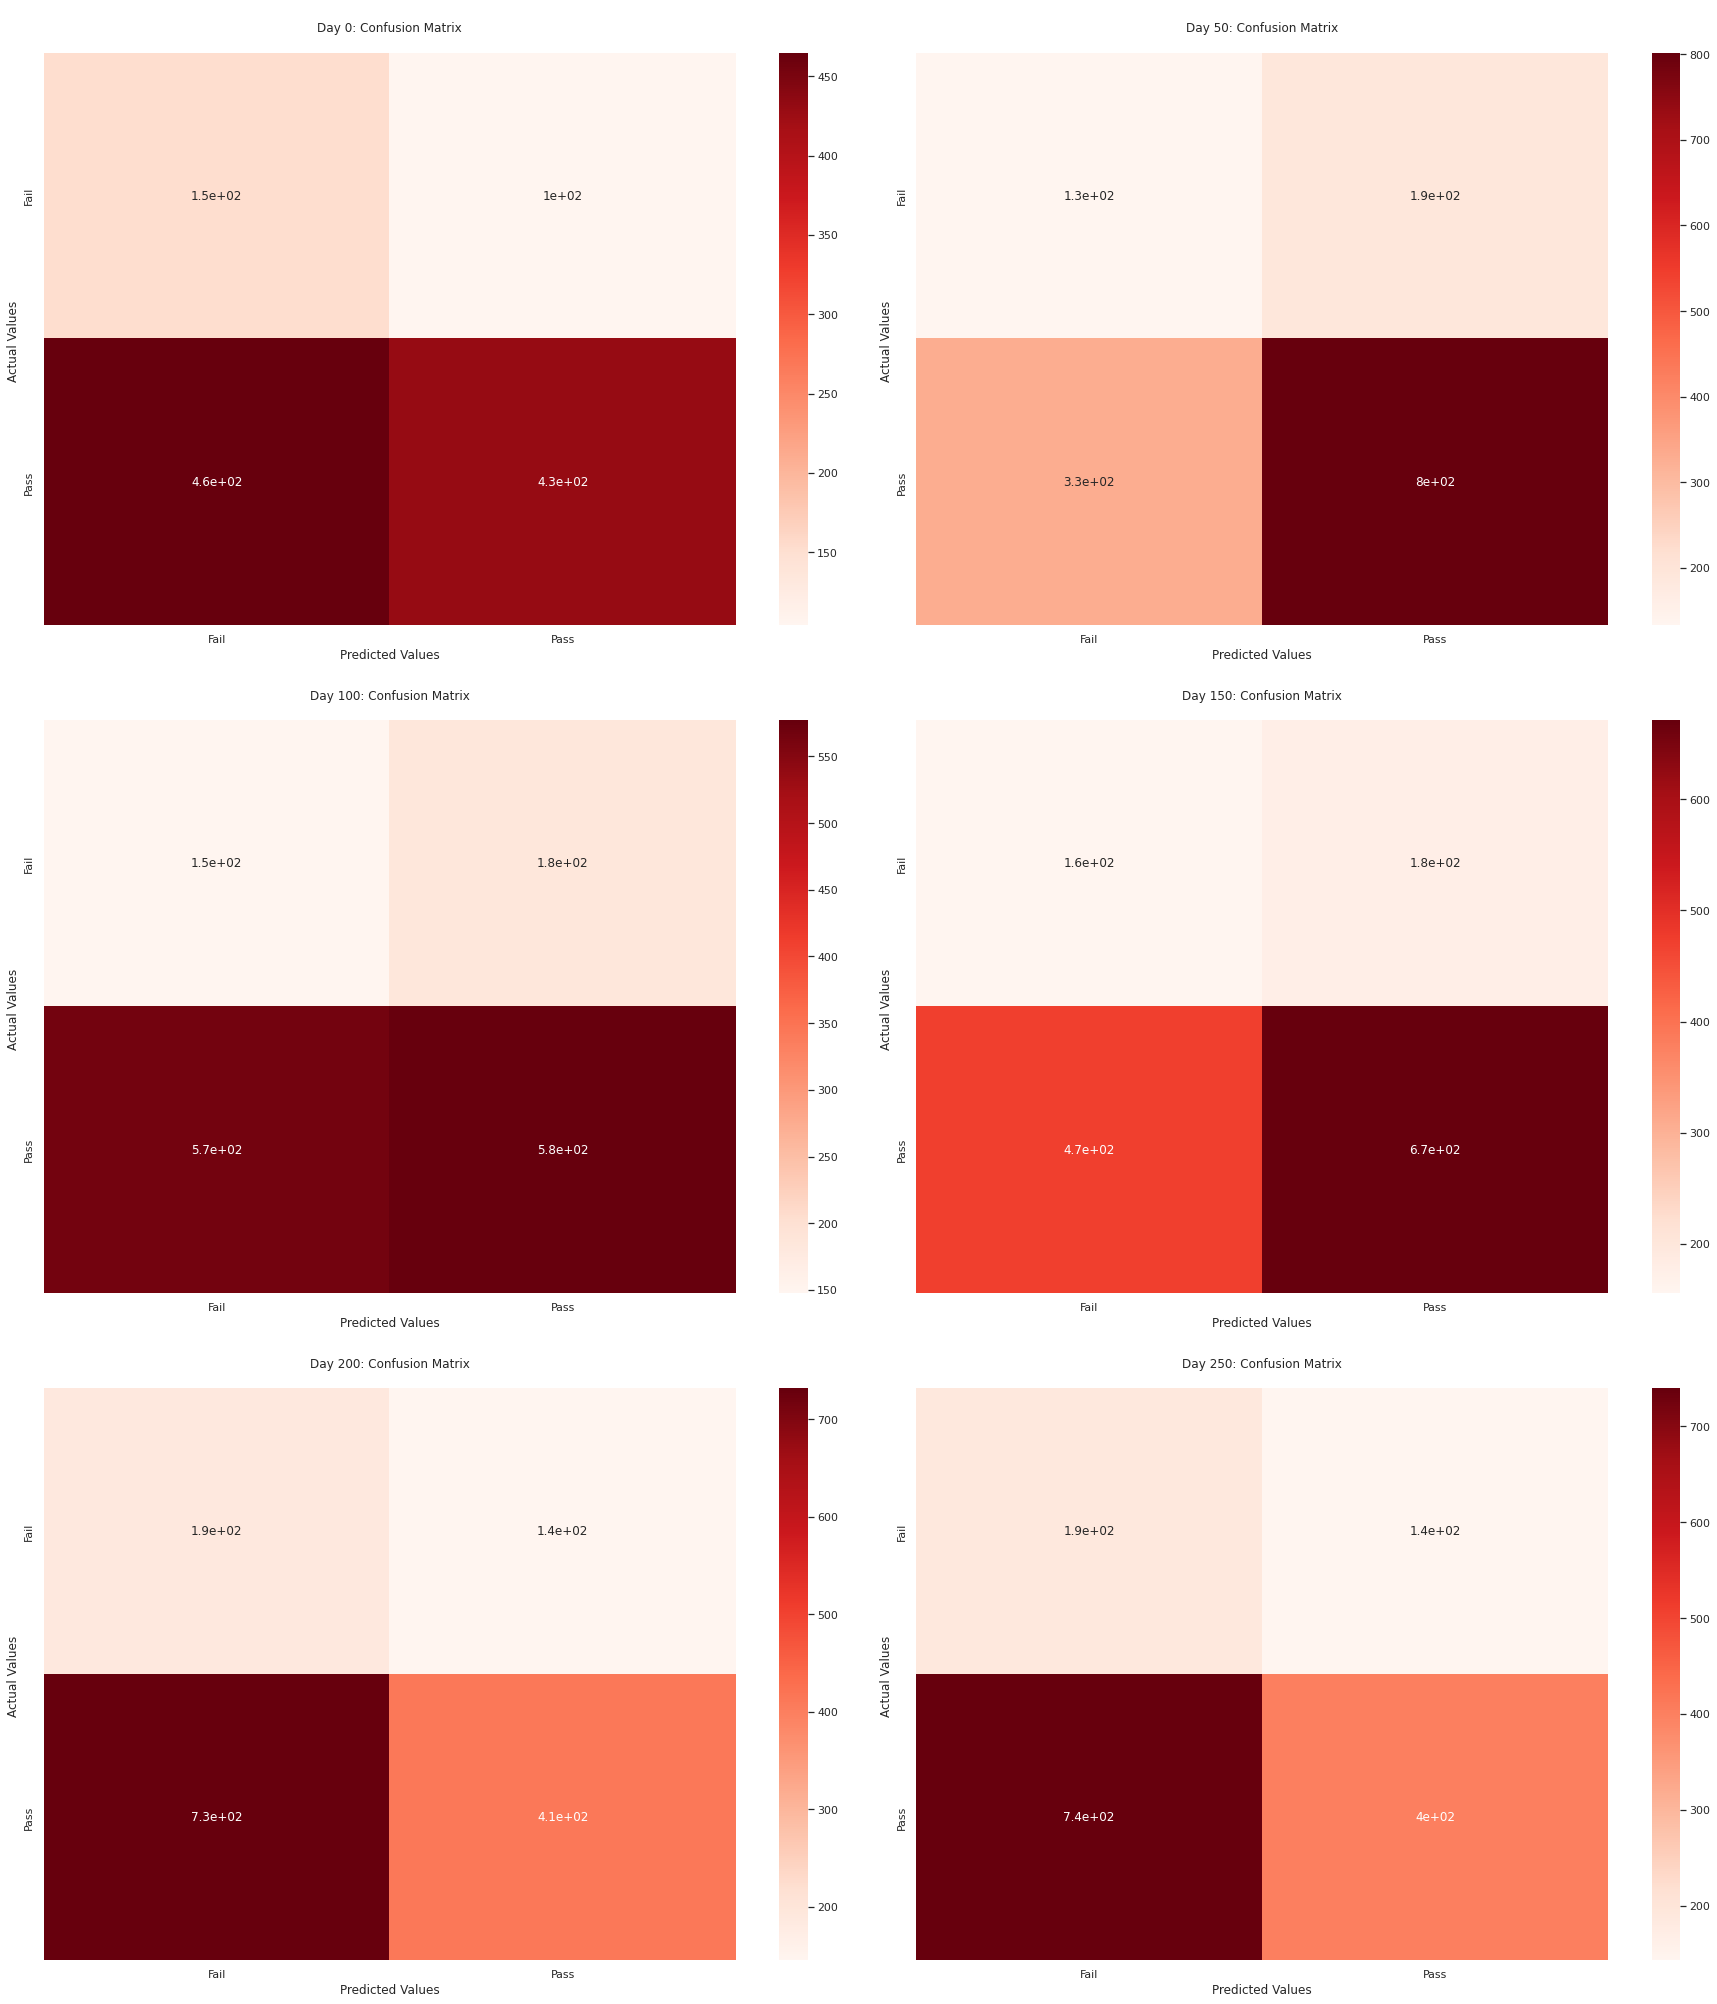

In [ ]:
plot_confusion_matrix(learning_behaviour_results_nb)

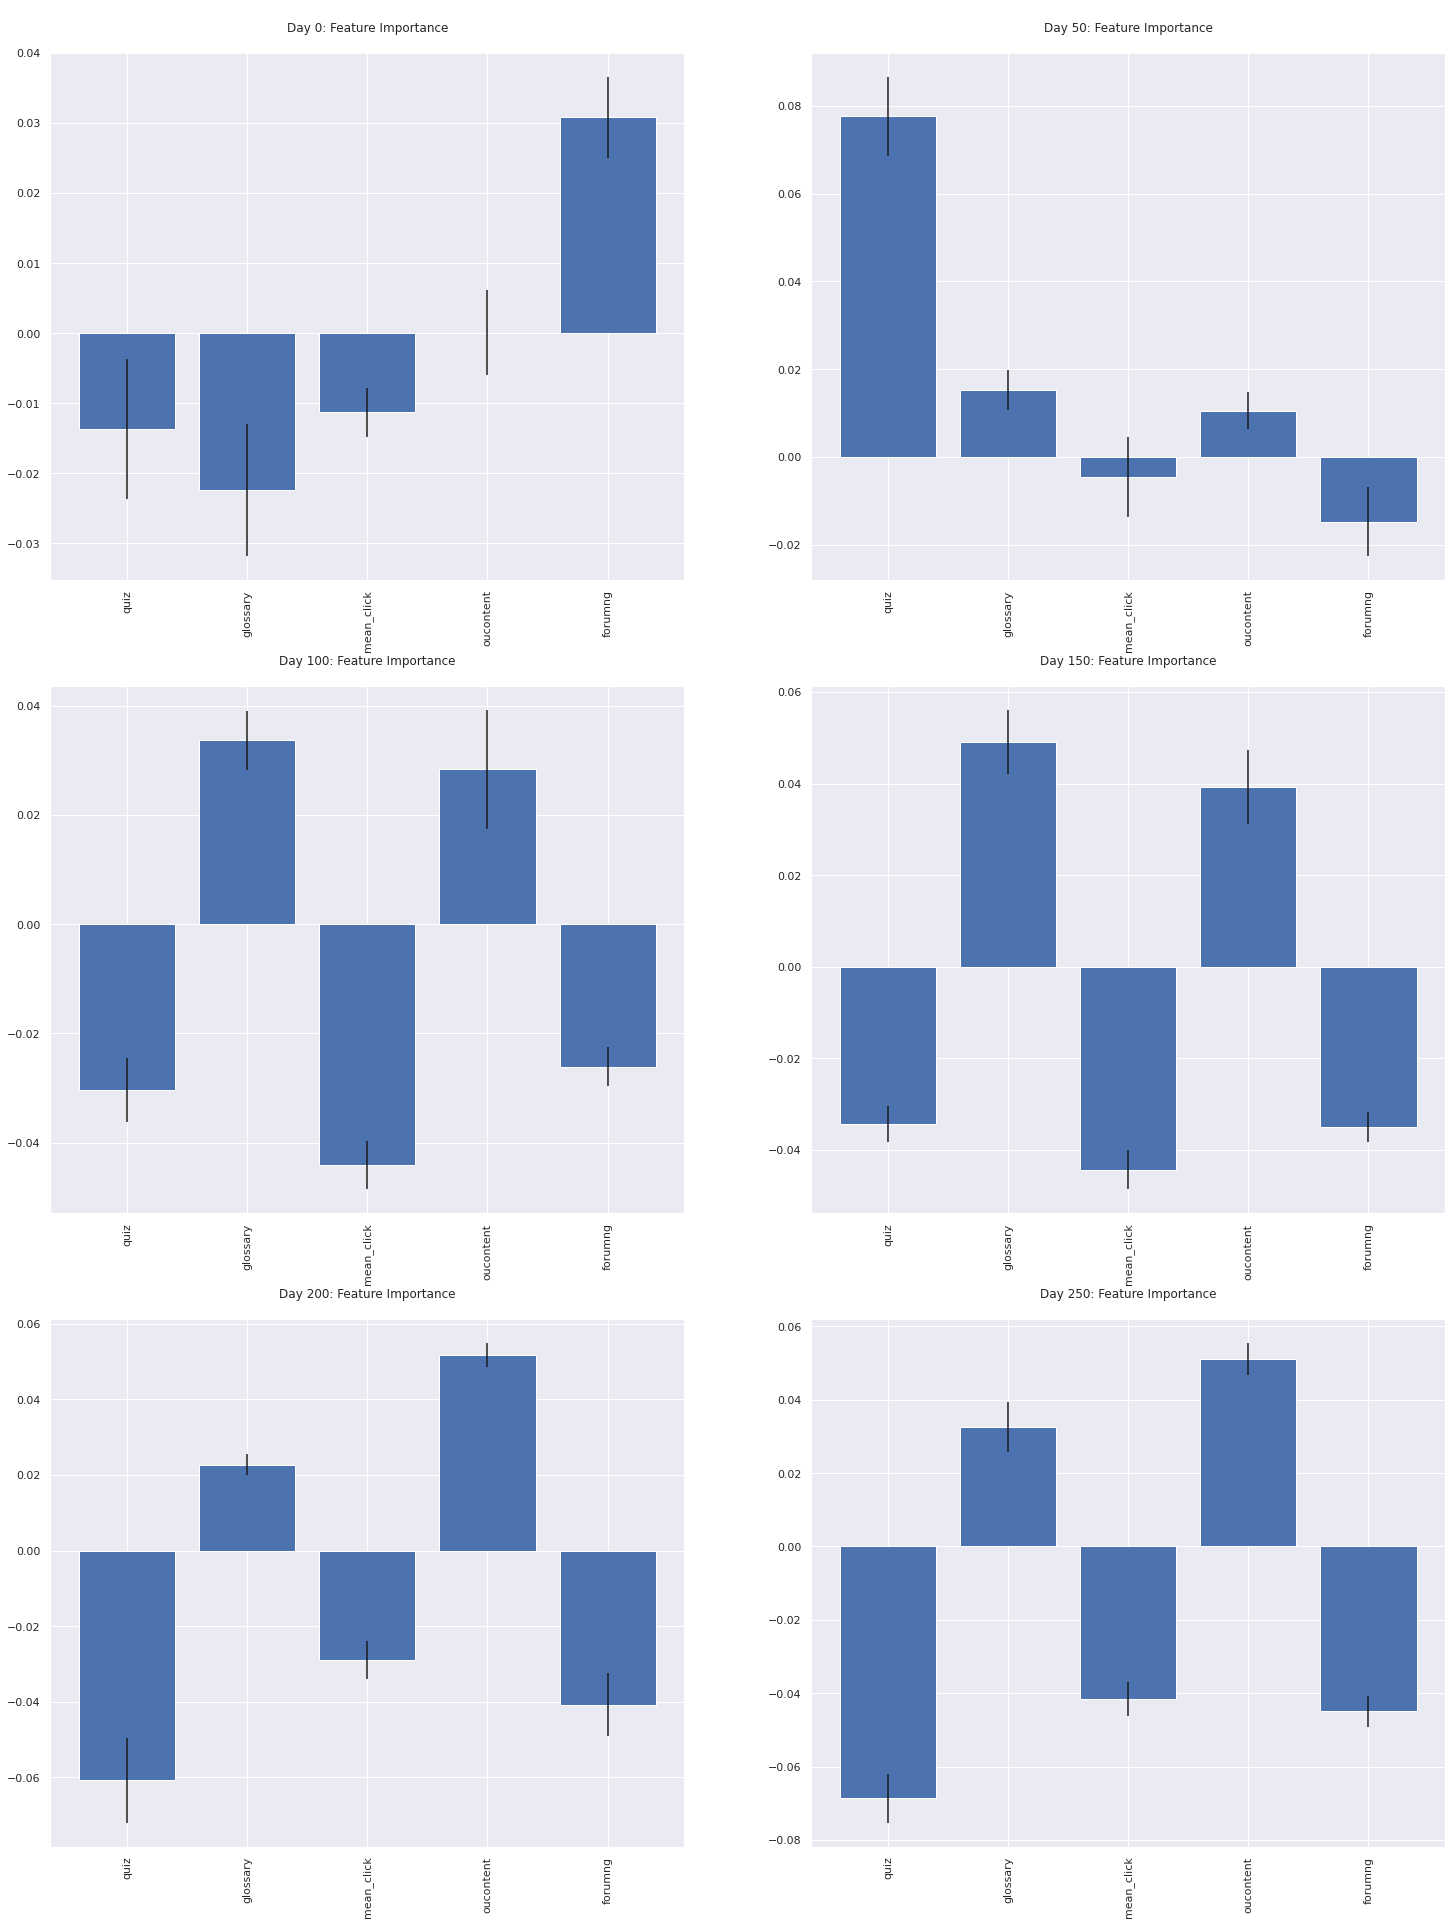

In [ ]:
plot_feature_importance(learning_behaviour_features_nb)

##### LogisticRegression

In [ ]:
from sklearn.linear_model import LogisticRegression

learning_behaviour_results_lr = []
learning_behiviour_features_lr = []

pipeline = Pipeline([
    ('clf', LogisticRegression()),
])

params = {
  'clf__penalty': ['l2', 'none']
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  learning_behaviour_results_lr.append([acc, f1, prec, recall, conf])
  learning_behiviour_features_lr.append([tuned_model, X_test[i], Y_test[i]])
  print("\n")


Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.424
Best parameters set:
	clf__penalty: 'l2'
Accuracy: 0.7775847089487402, F1 Score: 0.8748778103616813, Precision: 0.7775847089487402, Recall: 1.0


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.539
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.7318244170096022, F1 Score: 0.8336877924287538, Precision: 0.8045977011494253, Recall: 0.8649602824360106


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.600
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.7113821138211383, F1 Score: 0.8099910793933988, Precision: 0.8262056414922657, Recall: 0.7944006999125109


Day 150
P

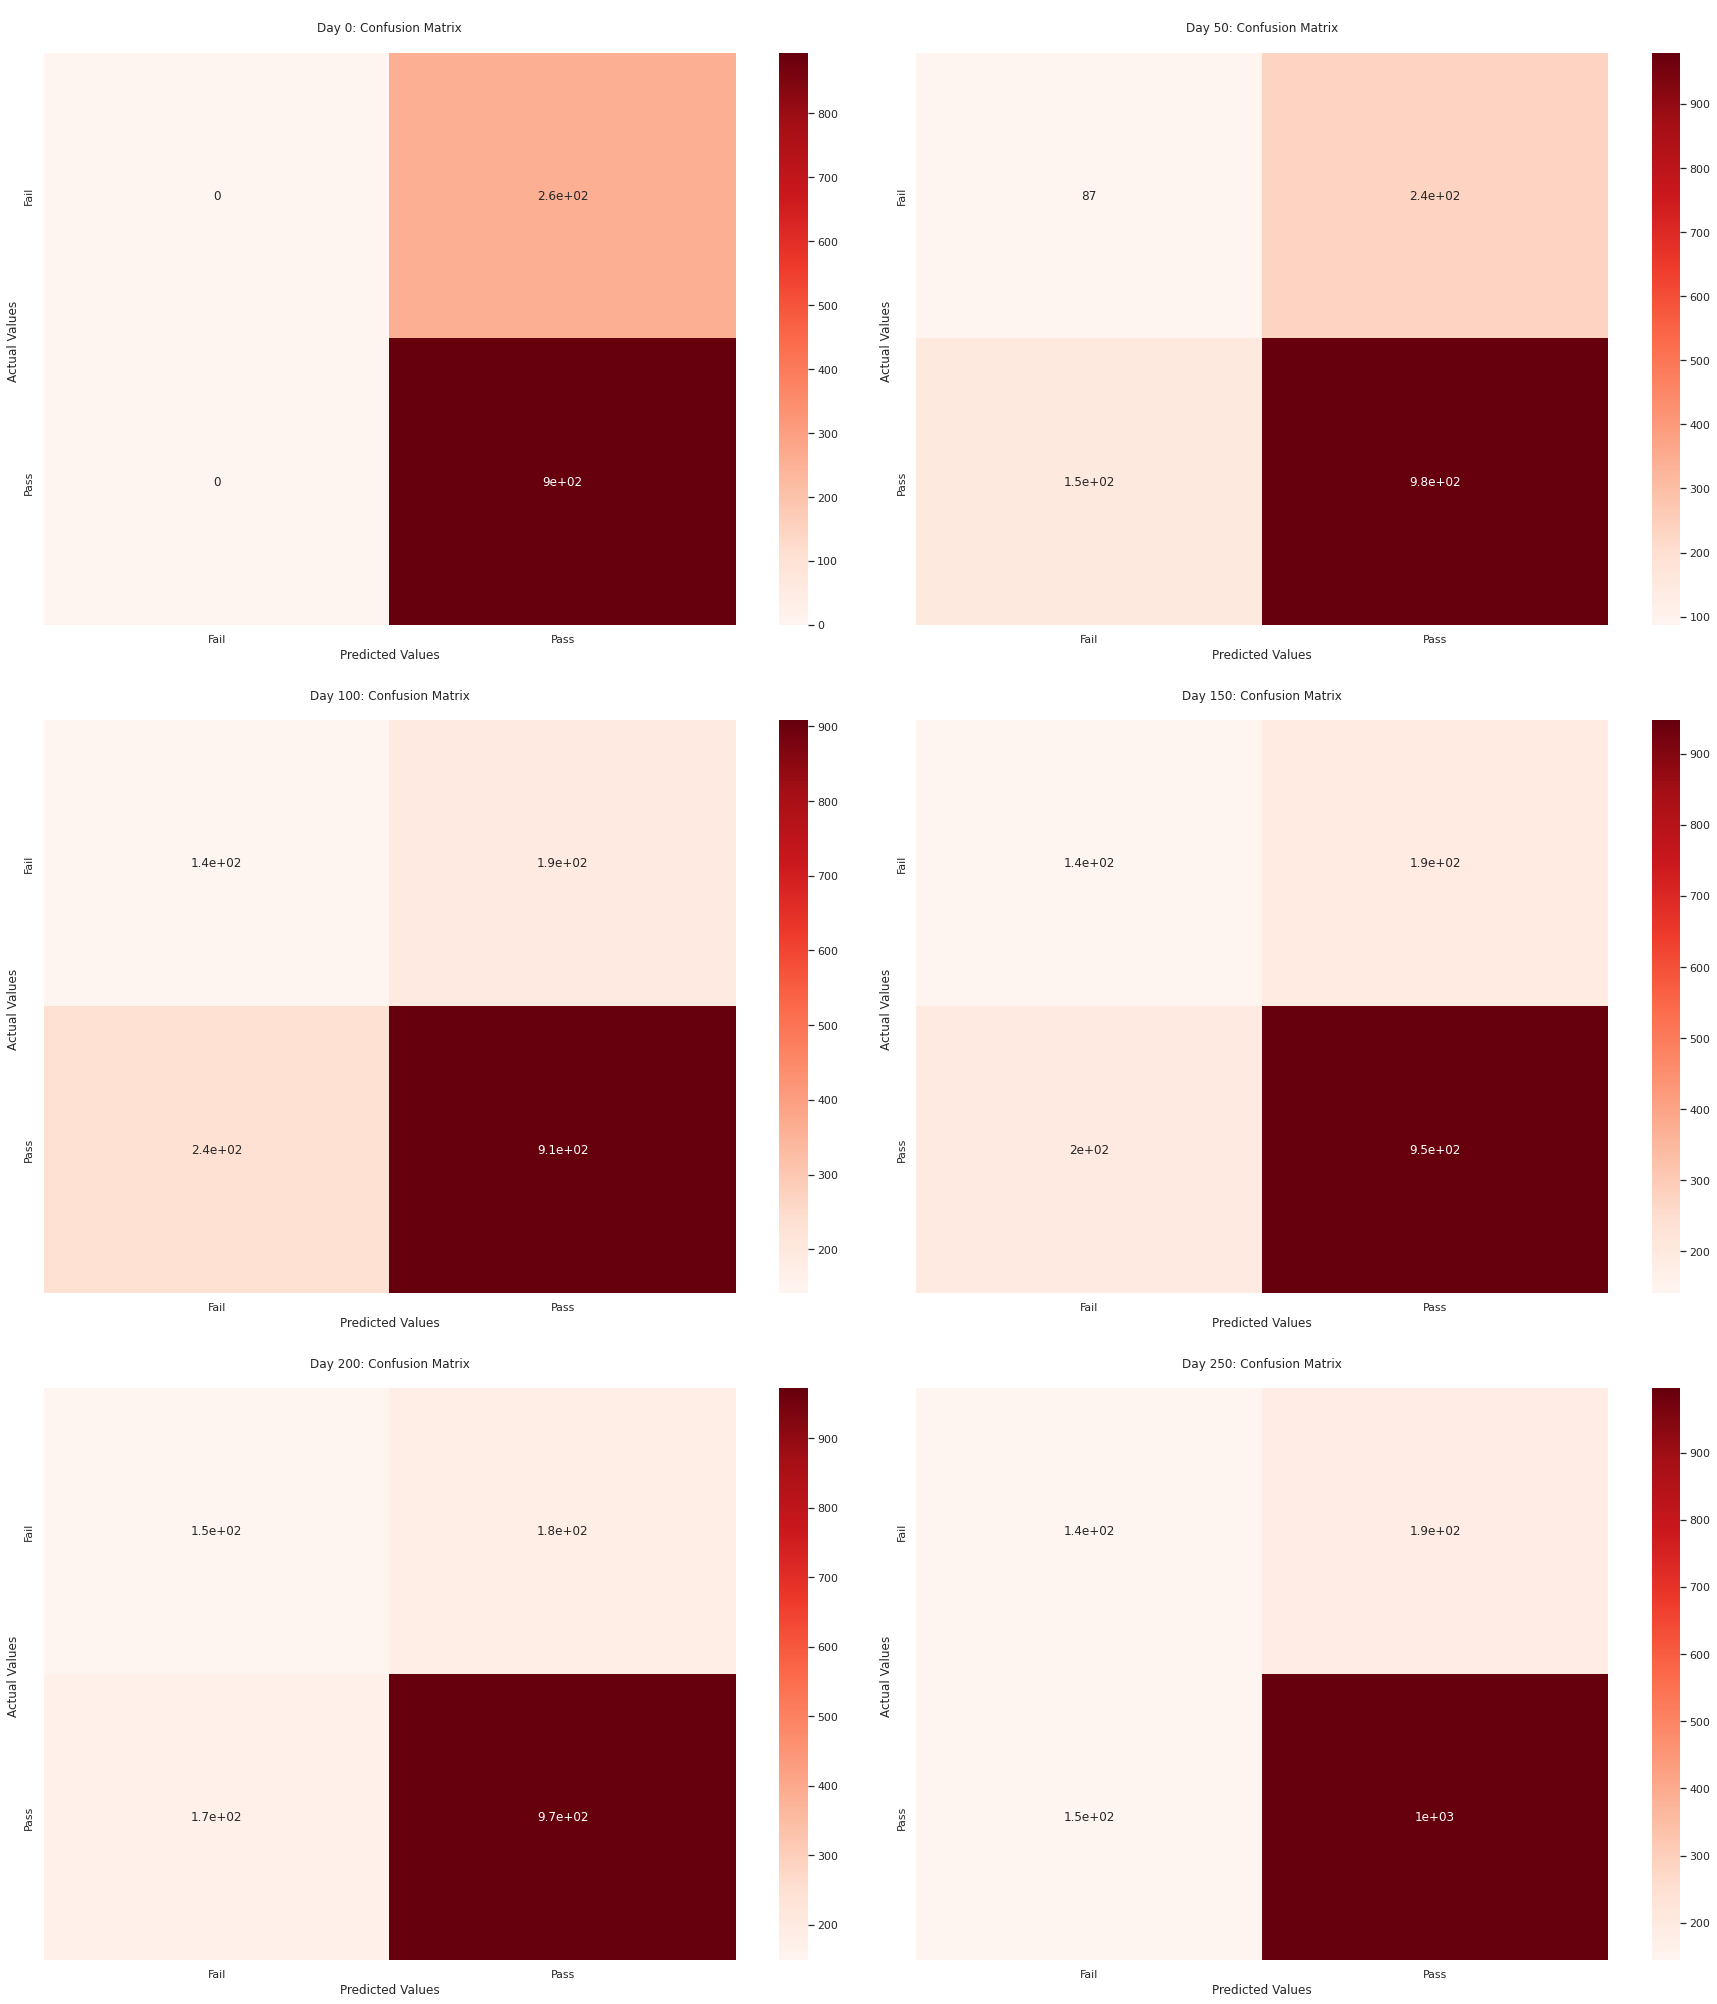

In [ ]:
plot_confusion_matrix(learning_behaviour_results_lr)

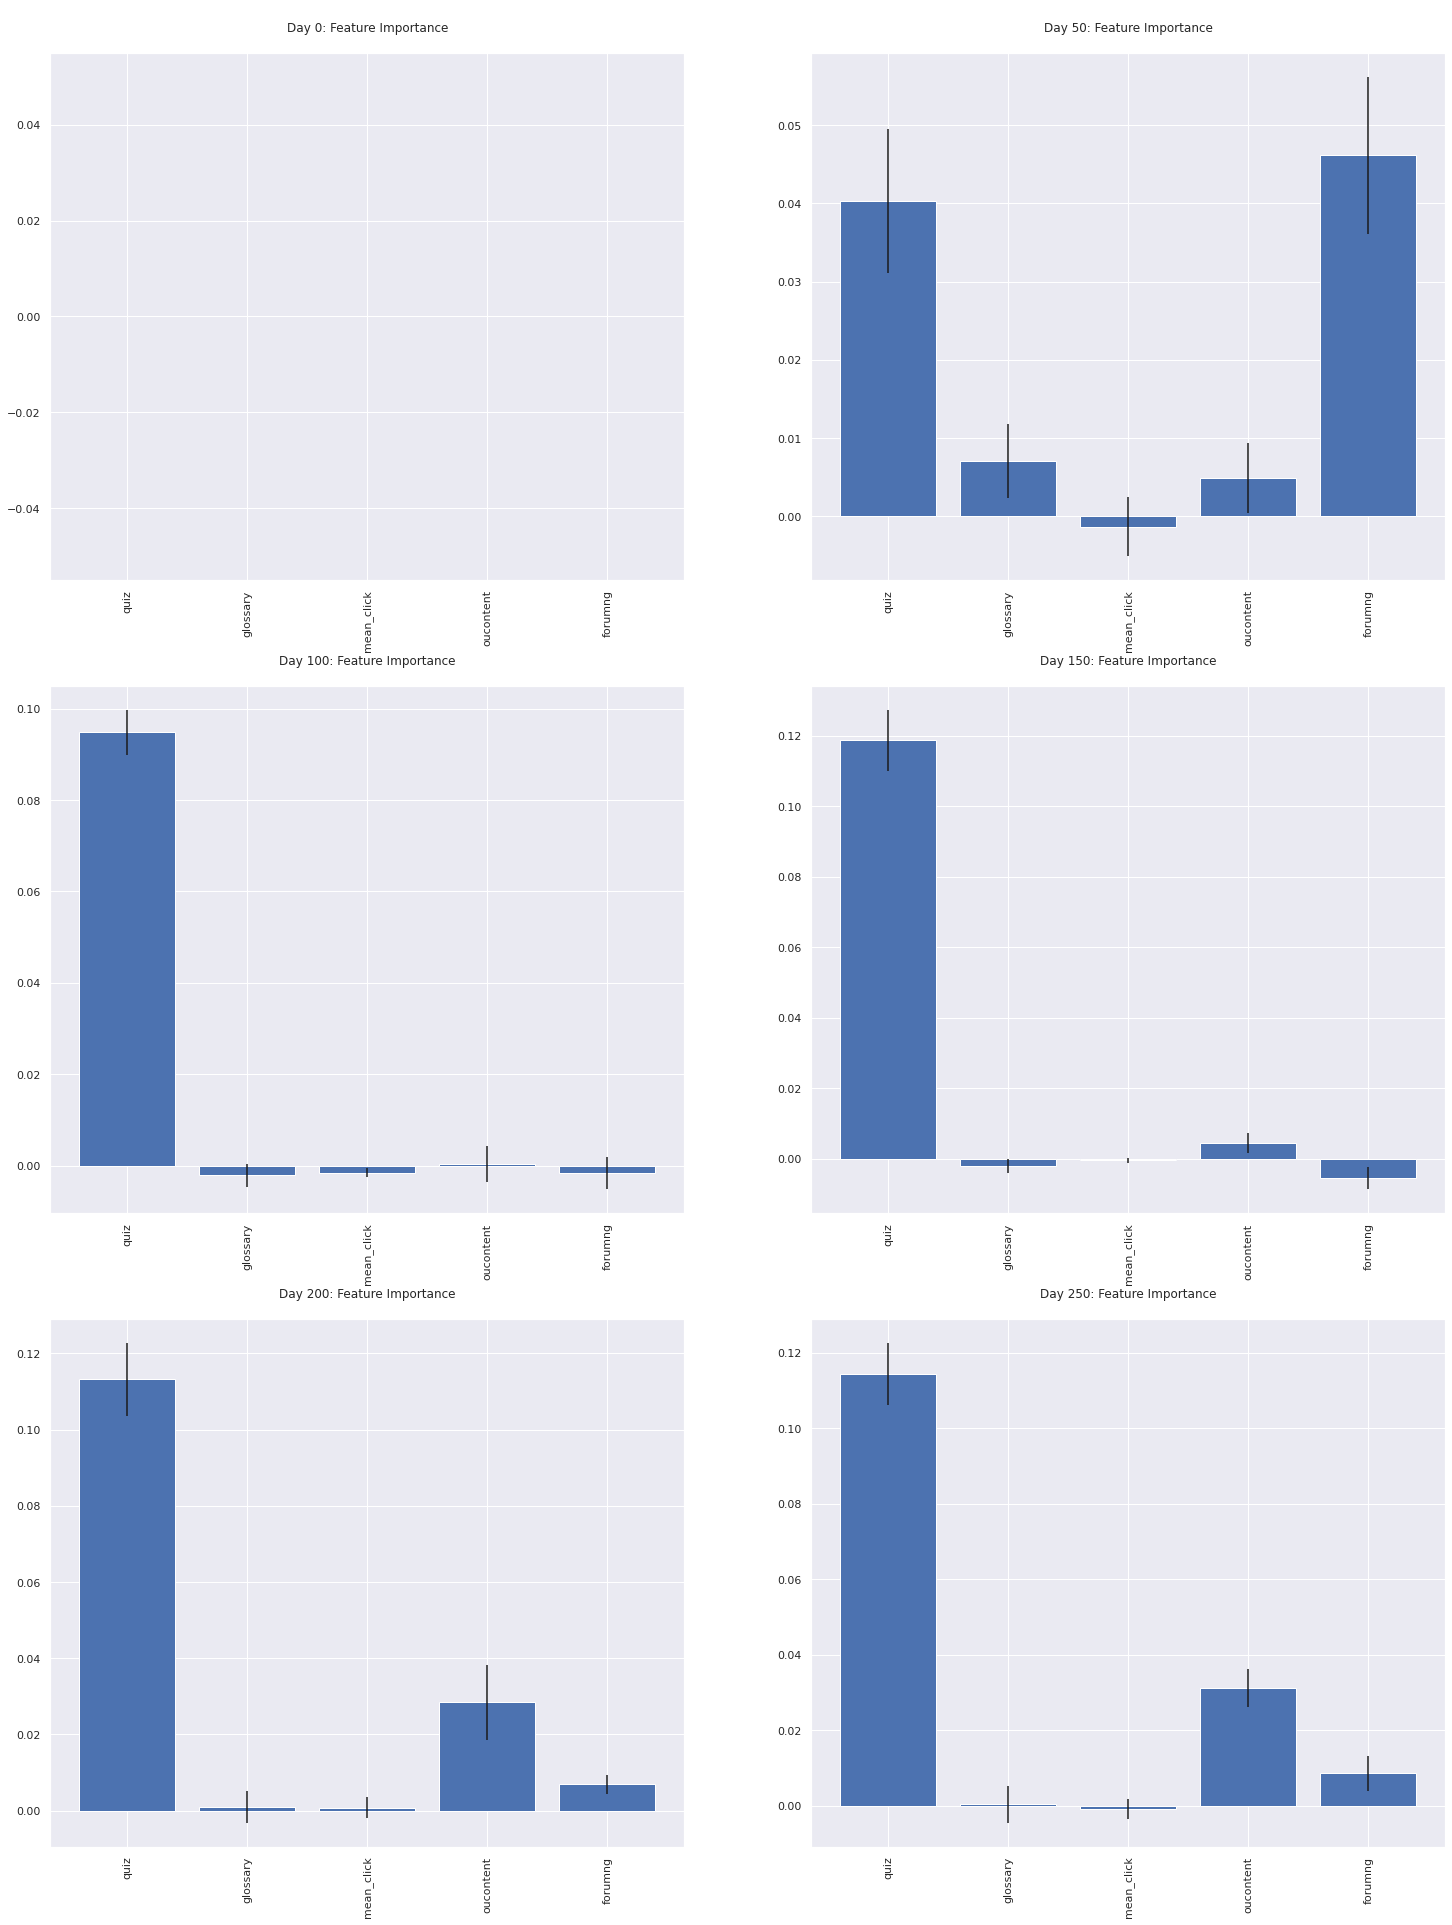

In [ ]:
plot_feature_importance(learning_behiviour_features_lr)

##### WeightedLogisticRegression

In [ ]:
learning_behaviour_results_lrw = []
learning_behaviour_features_lrw = []

pipeline = Pipeline([
    ('clf', LogisticRegression(class_weight = 'balanced')),
])

params = {
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  learning_behaviour_results_lrw.append([acc, f1, prec, recall, conf])
  learning_behaviour_features_lrw.append([tuned_model, X_test[i], Y_test[i]])

  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.506
Best parameters set:
Accuracy: 0.45351867940920937, F1 Score: 0.5142857142857142, Precision: 0.8325, Recall: 0.37206703910614525


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.612
Best parameters set:
Accuracy: 0.6042524005486969, F1 Score: 0.7087329631499243, Precision: 0.8278301886792453, Recall: 0.6195939982347749


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.602
Best parameters set:
Accuracy: 0.7025745257452575, F1 Score: 0.7976025818349469, Precision: 0.8430799220272904, Recall: 0.7567804024496938


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.624
Best parameter

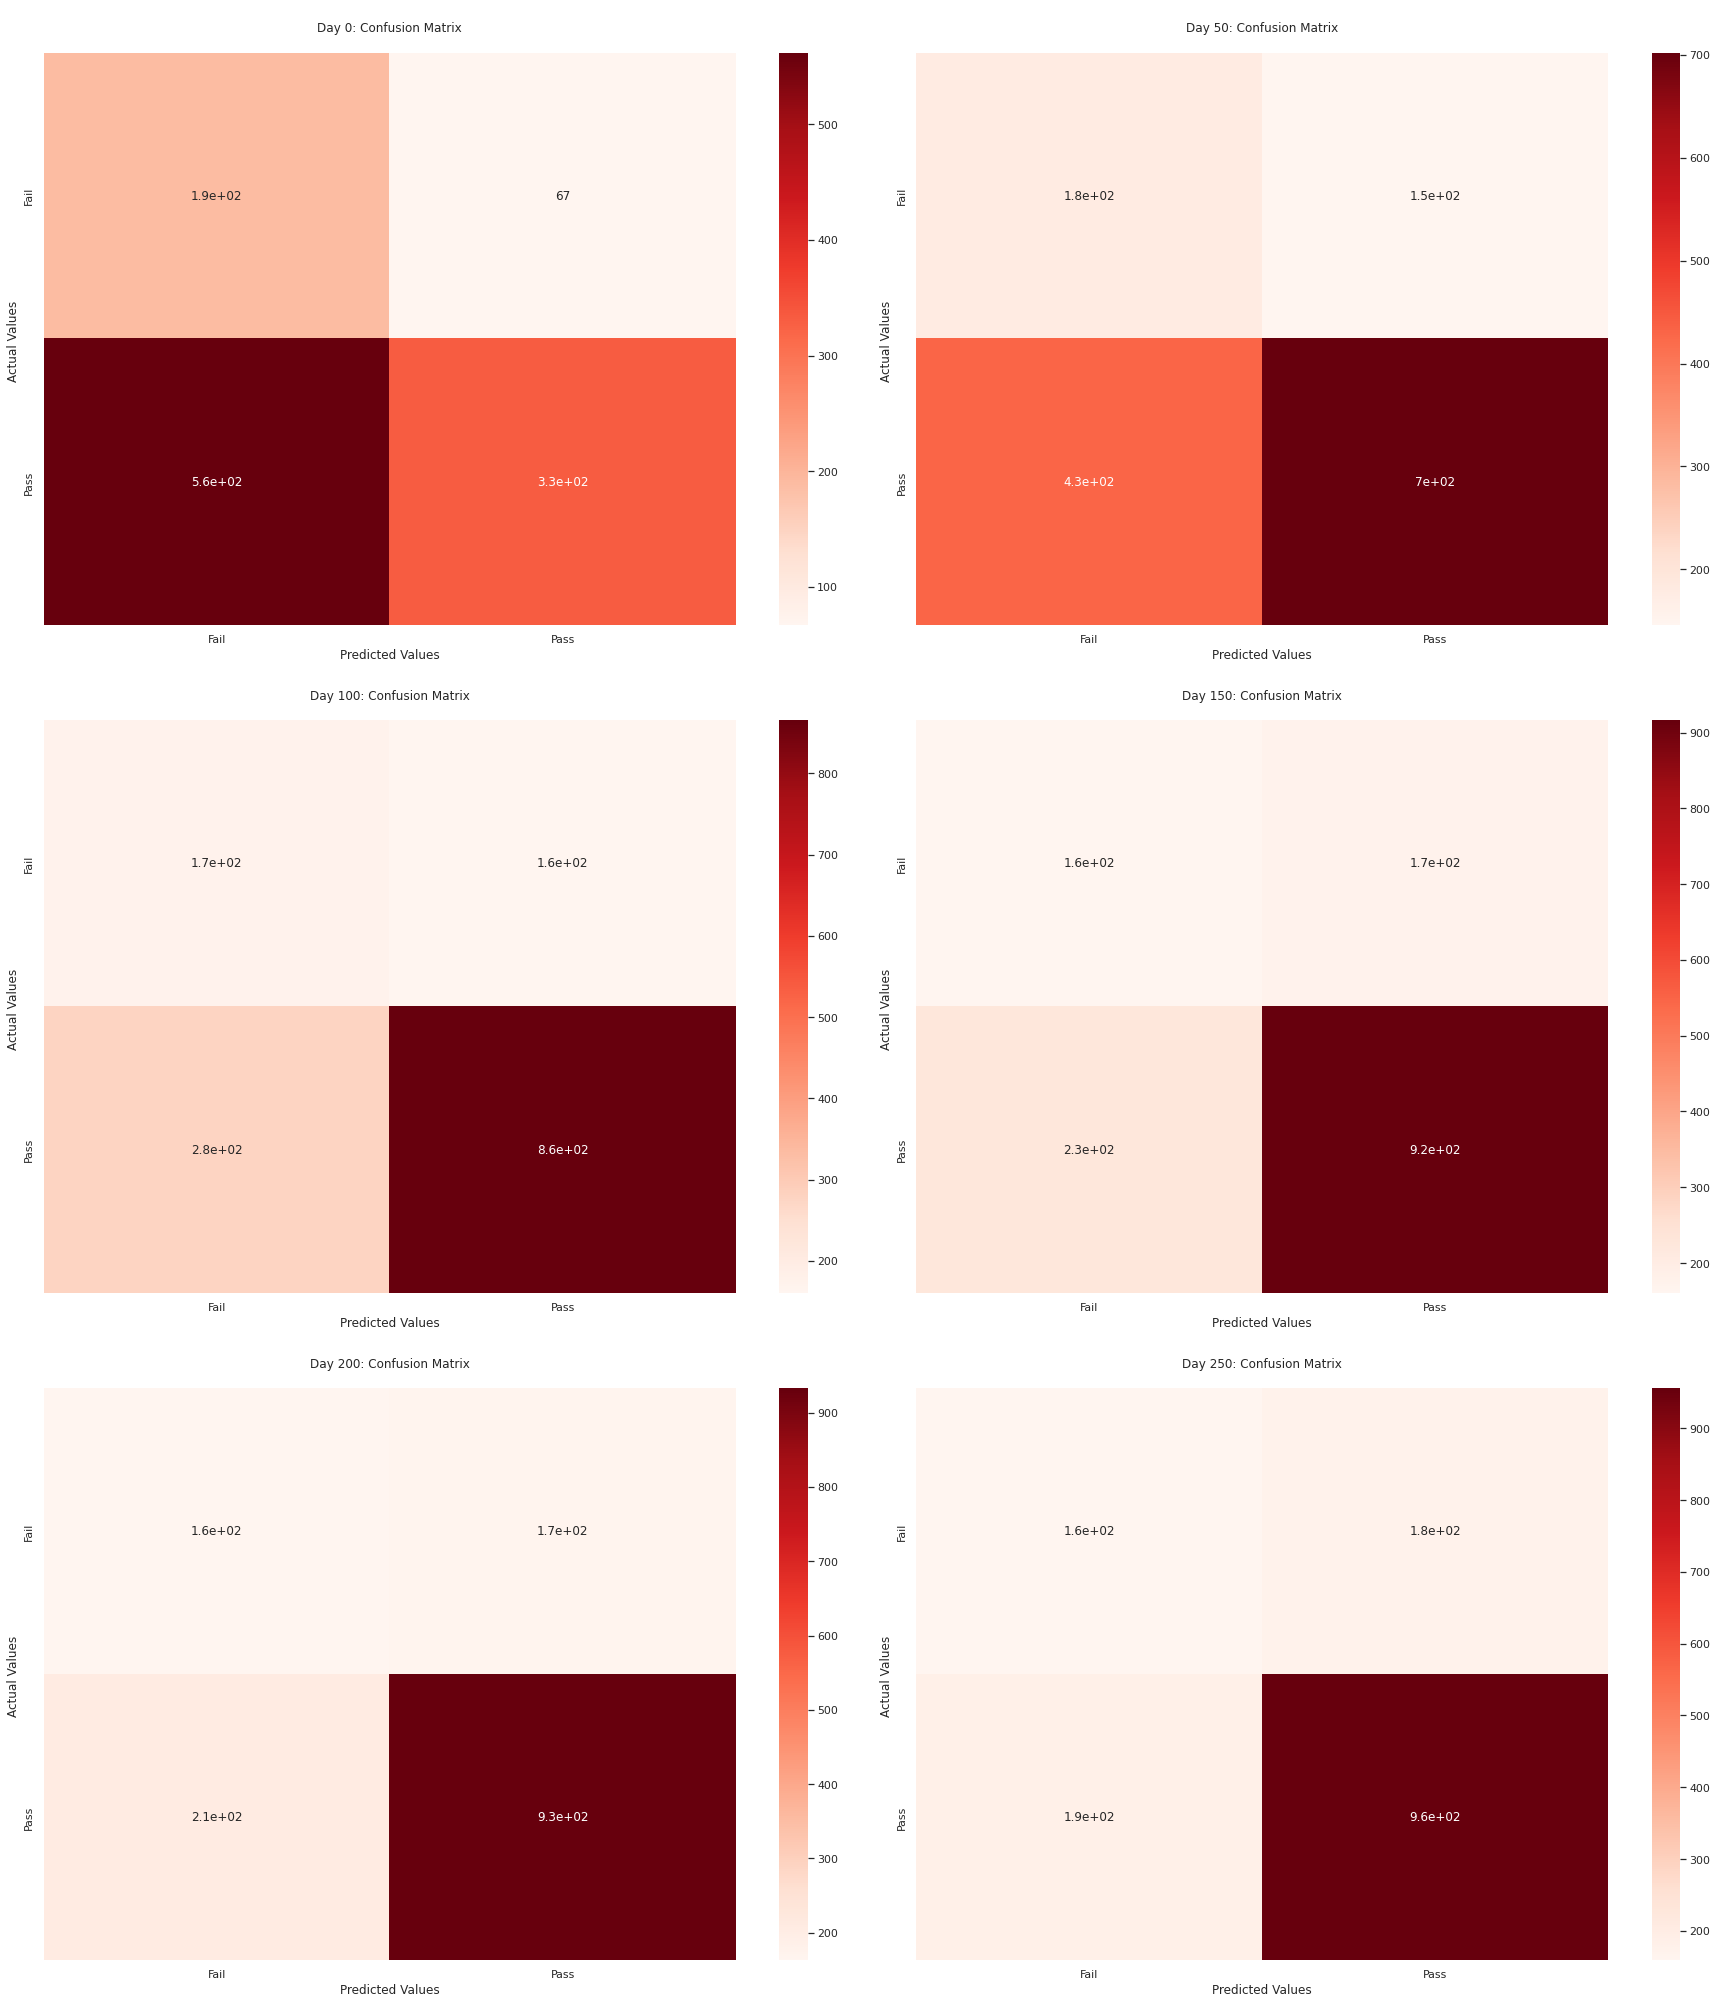

In [ ]:
plot_confusion_matrix(learning_behaviour_results_lrw)

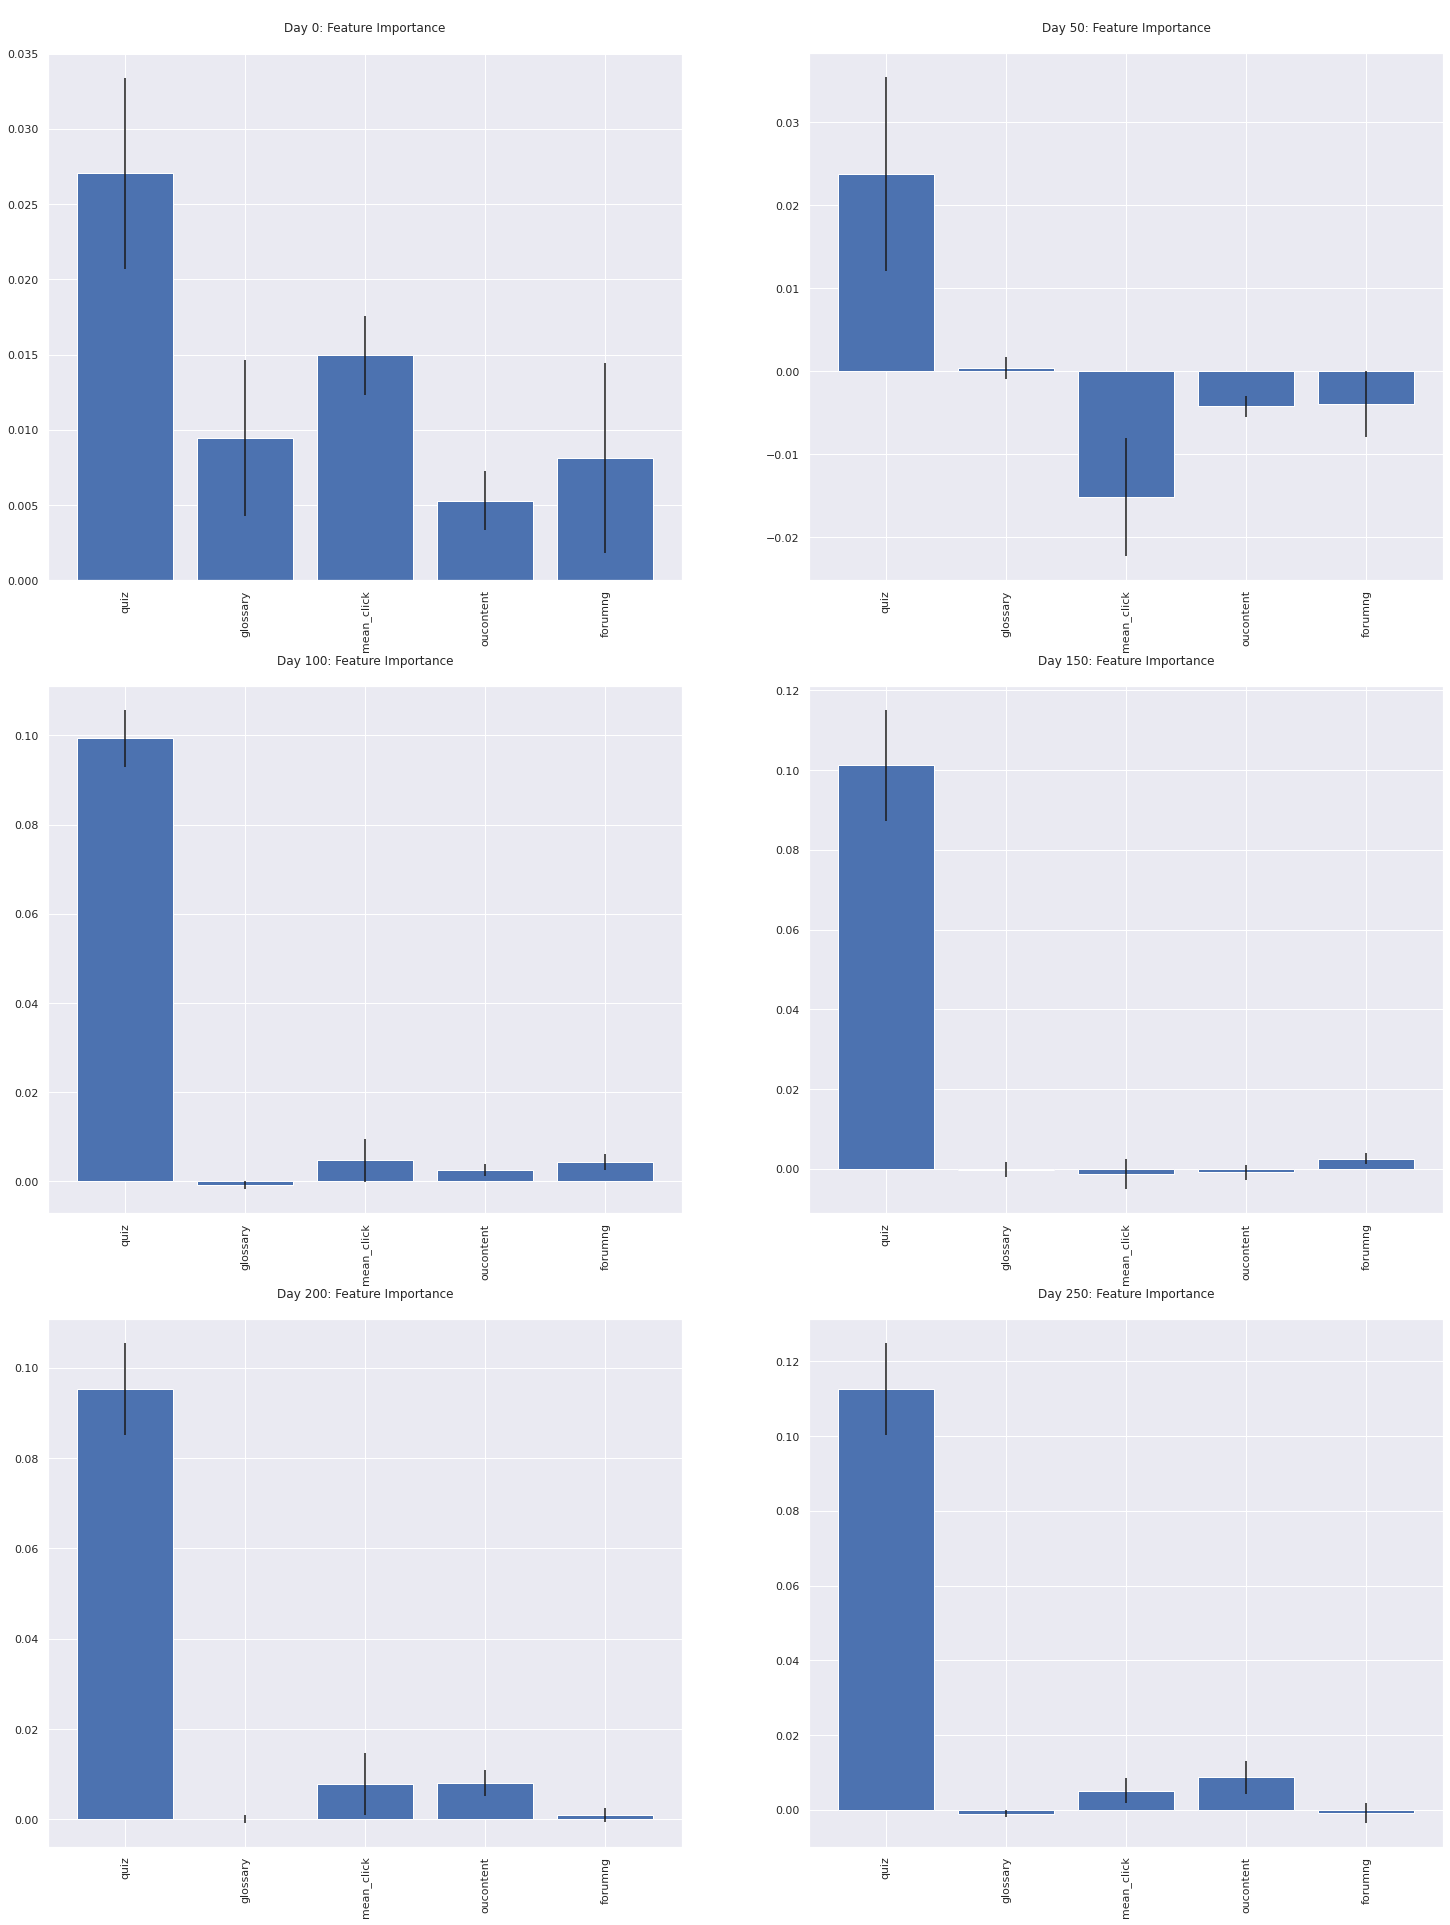

In [ ]:
plot_feature_importance(learning_behaviour_features_lrw)

##### RandomForest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

learning_behaviour_results_rf = []
learning_behaviour_features_rf = []

pipeline = Pipeline([
    ('clf', RandomForestClassifier(random_state=RANDOM_SEED)),
])

params = {
  'clf__n_estimators': [x for x in range(50,150,10)]
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  learning_behaviour_results_rf.append([acc, f1, prec, recall, conf])
  learning_behaviour_features_rf.append([tuned_model, X_test[i], Y_test[i]])
  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.459
Best parameters set:
	clf__n_estimators: 110
Accuracy: 0.7211120764552563, F1 Score: 0.8335925349922241, Precision: 0.7775628626692457, Recall: 0.8983240223463688


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.602
Best parameters set:
	clf__n_estimators: 140
Accuracy: 0.7057613168724279, F1 Score: 0.8156424581005587, Precision: 0.7948073701842546, Recall: 0.8375992939099736


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.640
Best parameters set:
	clf__n_estimato

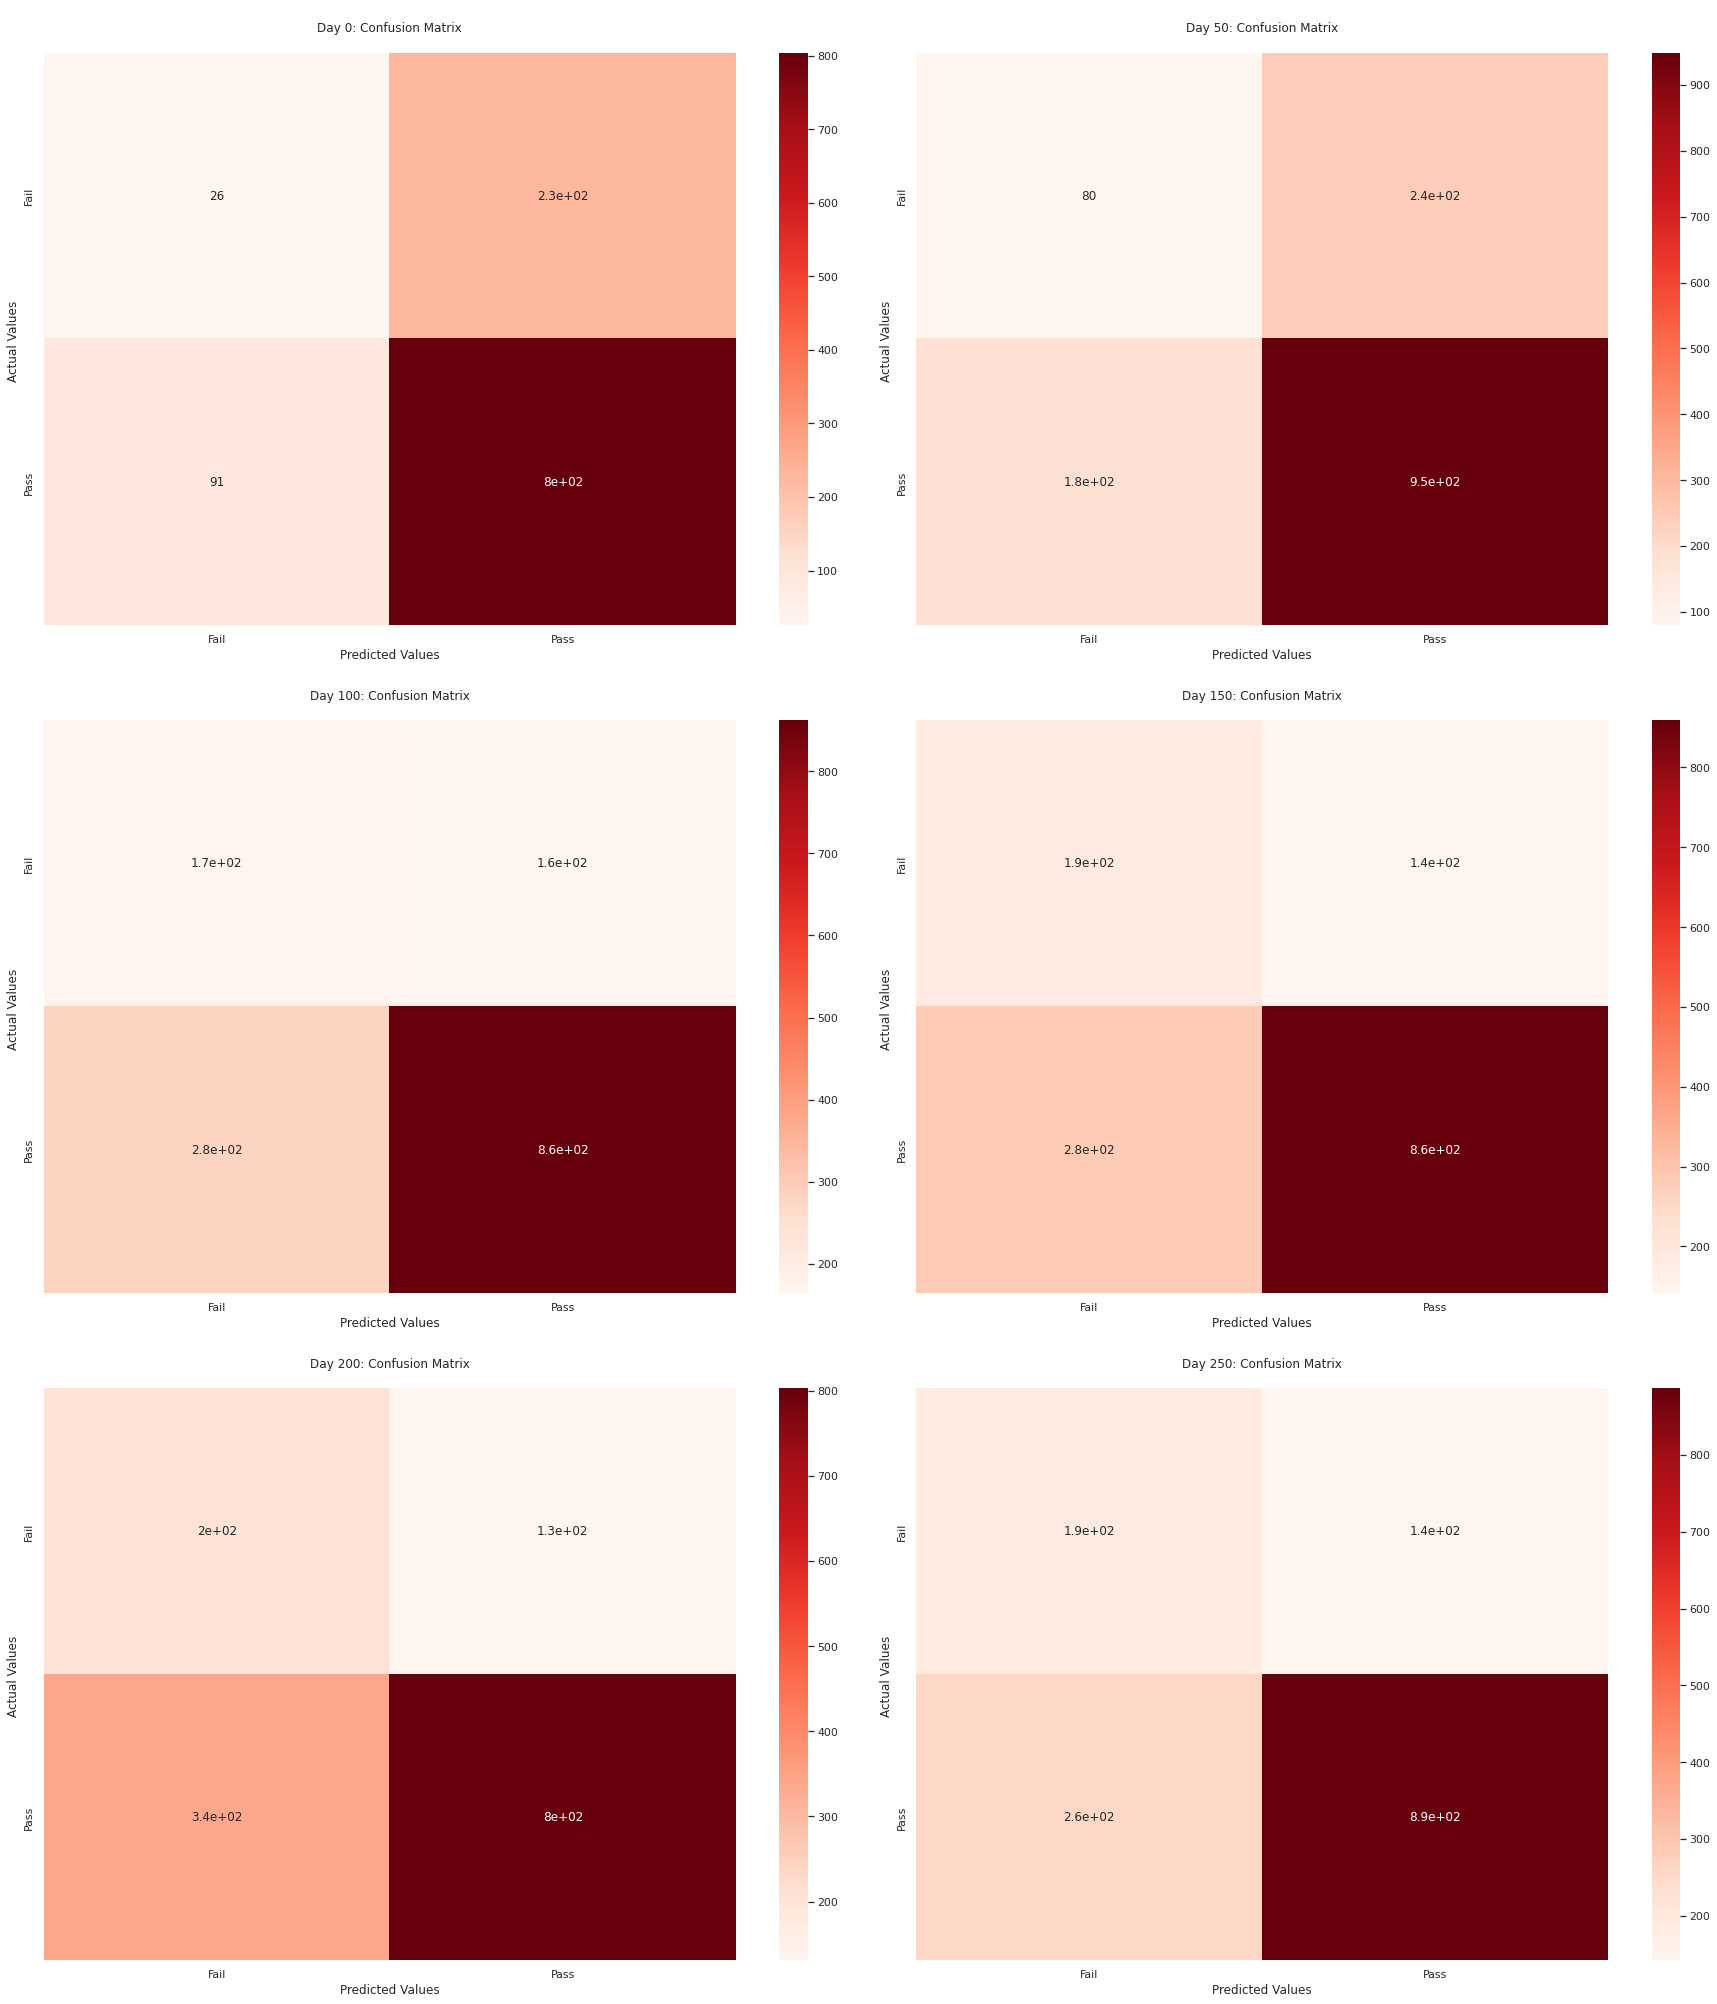

In [ ]:
plot_confusion_matrix(learning_behaviour_results_rf)

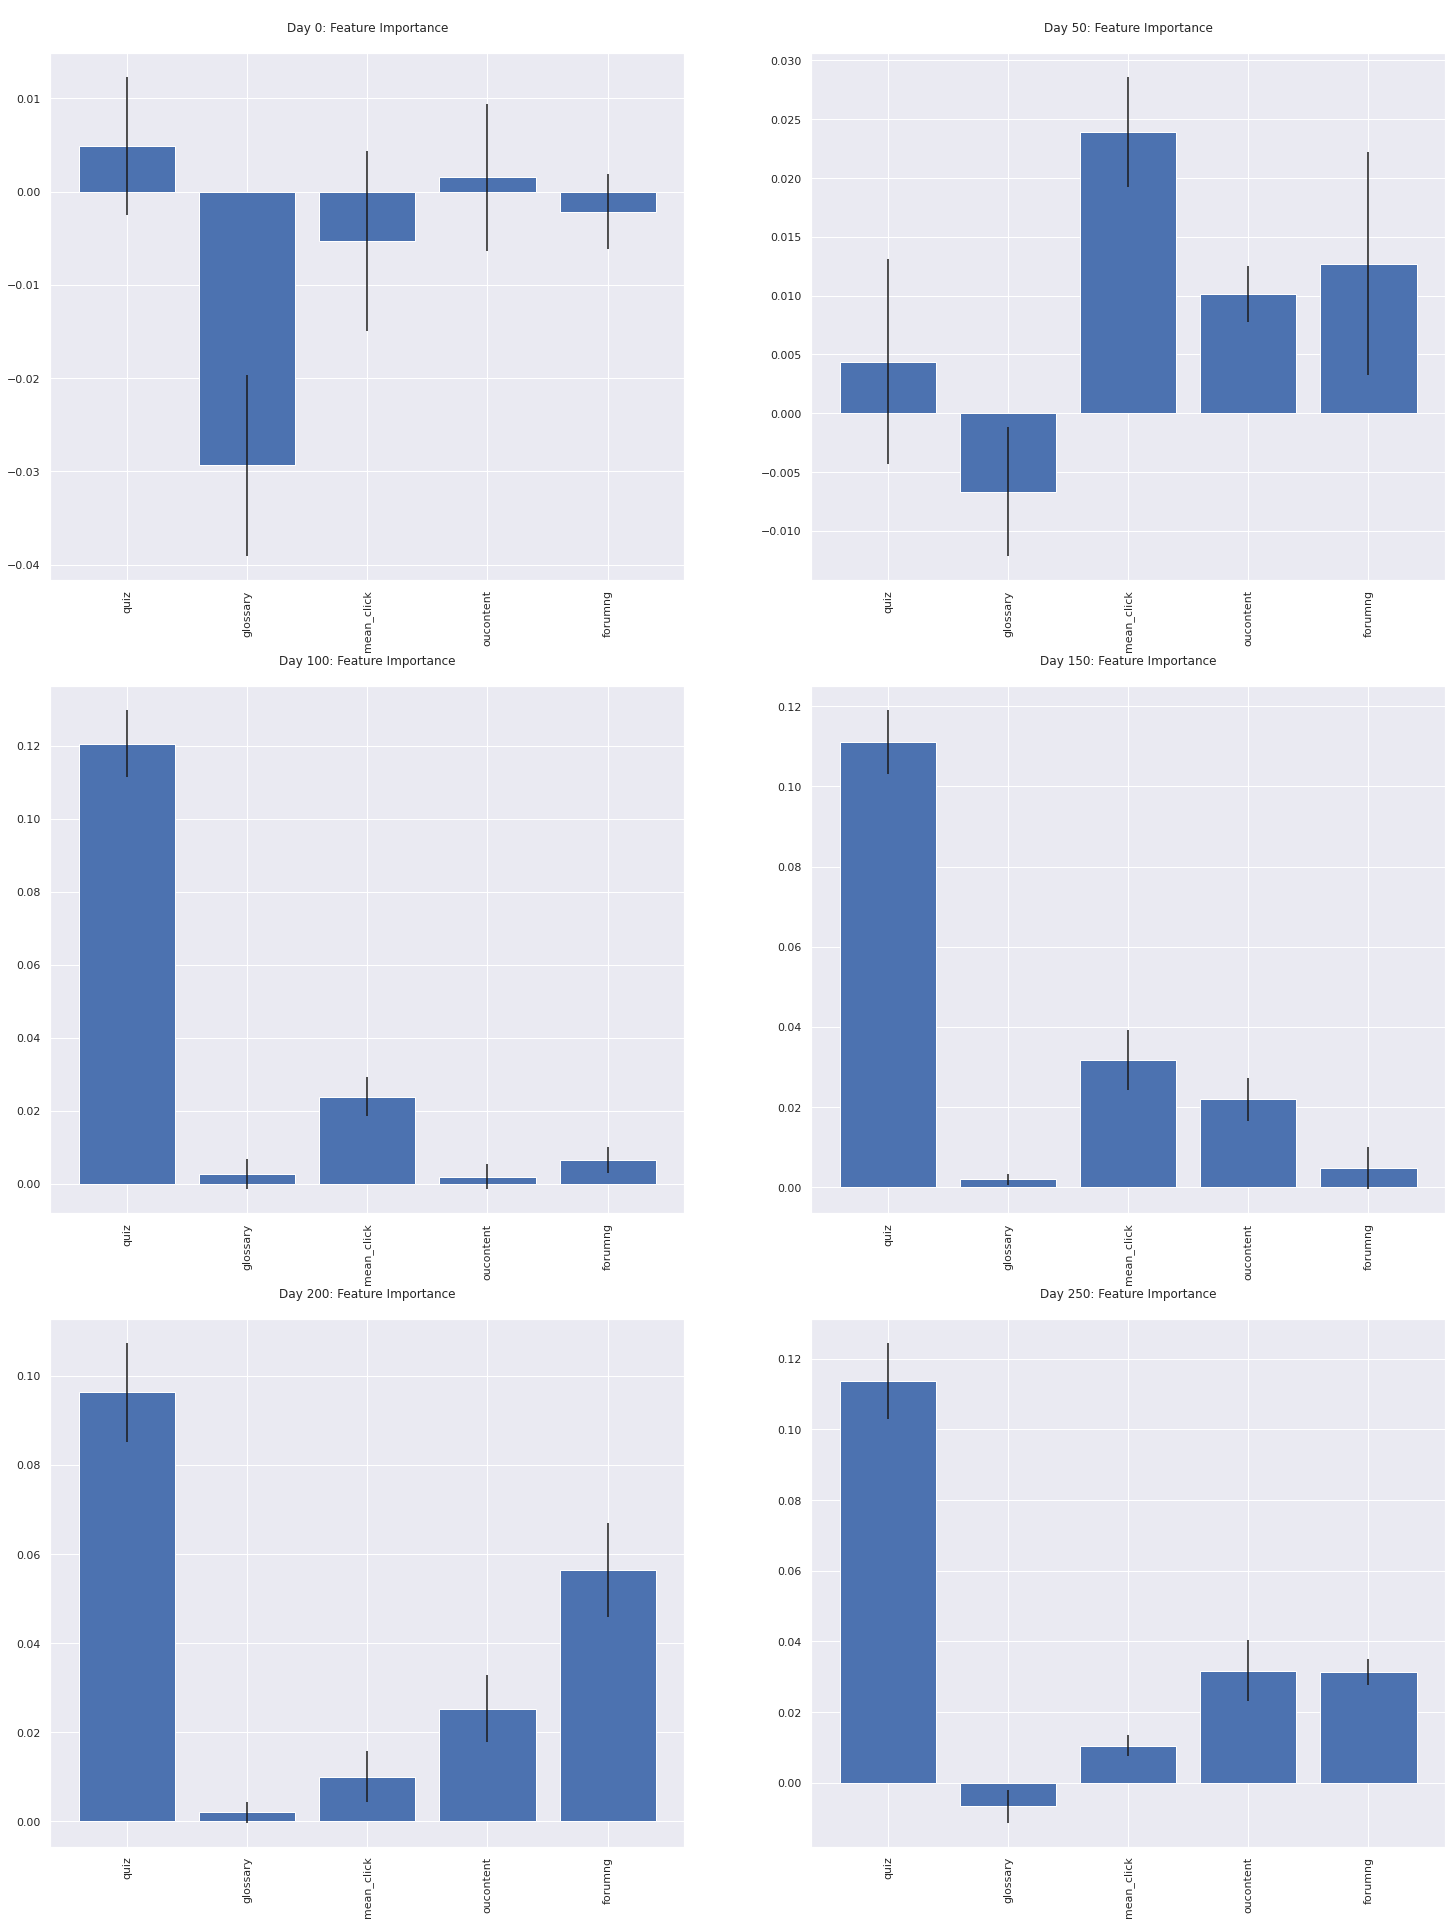

In [ ]:
plot_feature_importance(learning_behaviour_features_rf)

##### AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

learning_behaviour_results_ab = []
learning_behiviour_features_ab = []

pipeline = Pipeline([
    ('clf', AdaBoostClassifier(random_state=RANDOM_SEED)),
])

params = {
  'clf__learning_rate':(0.5,0.85,1,1.25,1.5,1.75)
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  learning_behaviour_results_ab.append([acc, f1, prec, recall, conf])
  learning_behiviour_features_ab.append([tuned_model, X_test[i], Y_test[i]])

  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.459
Best parameters set:
	clf__learning_rate: 1.75
Accuracy: 0.7419635099913119, F1 Score: 0.8499242041435067, Precision: 0.775830258302583, Recall: 0.9396648044692737


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.583
Best parameters set:
	clf__learning_rate: 1
Accuracy: 0.6844993141289437, F1 Score: 0.793536804308797, Precision: 0.8073059360730593, Recall: 0.7802294792586054


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.641
Best parameters set:
	clf__learning_rate: 1.5
Accuracy: 0.6964769647696477, F1 S

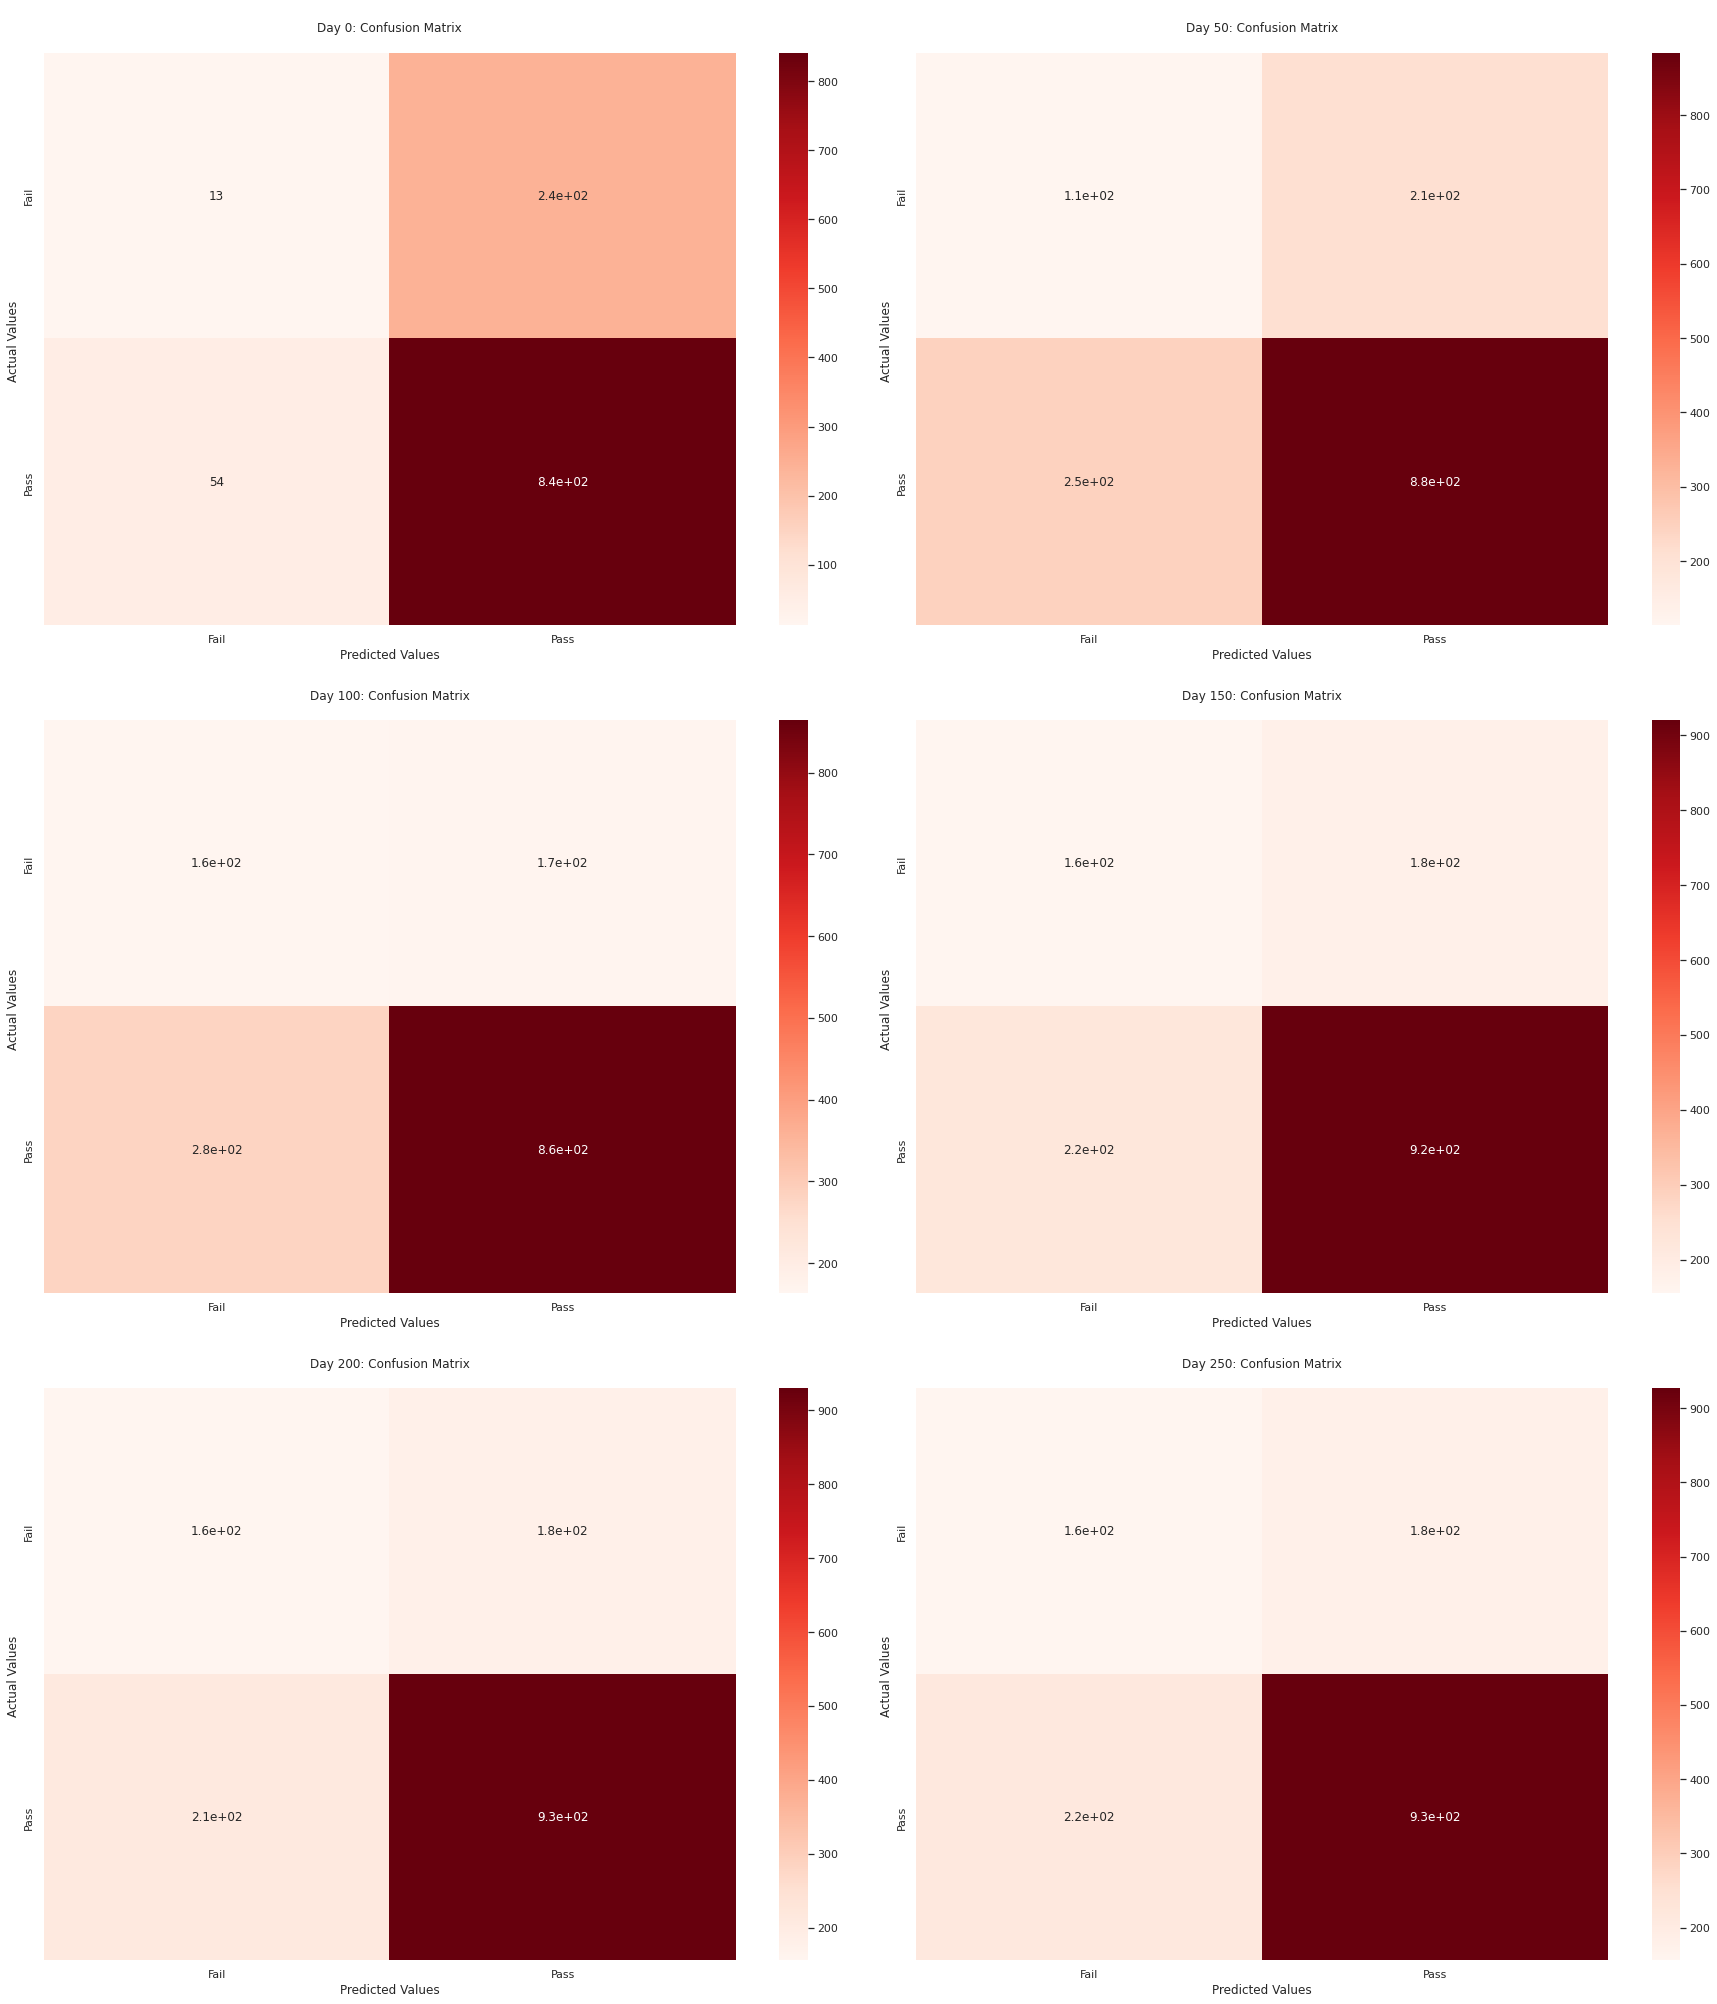

In [ ]:
plot_confusion_matrix(learning_behaviour_results_ab)

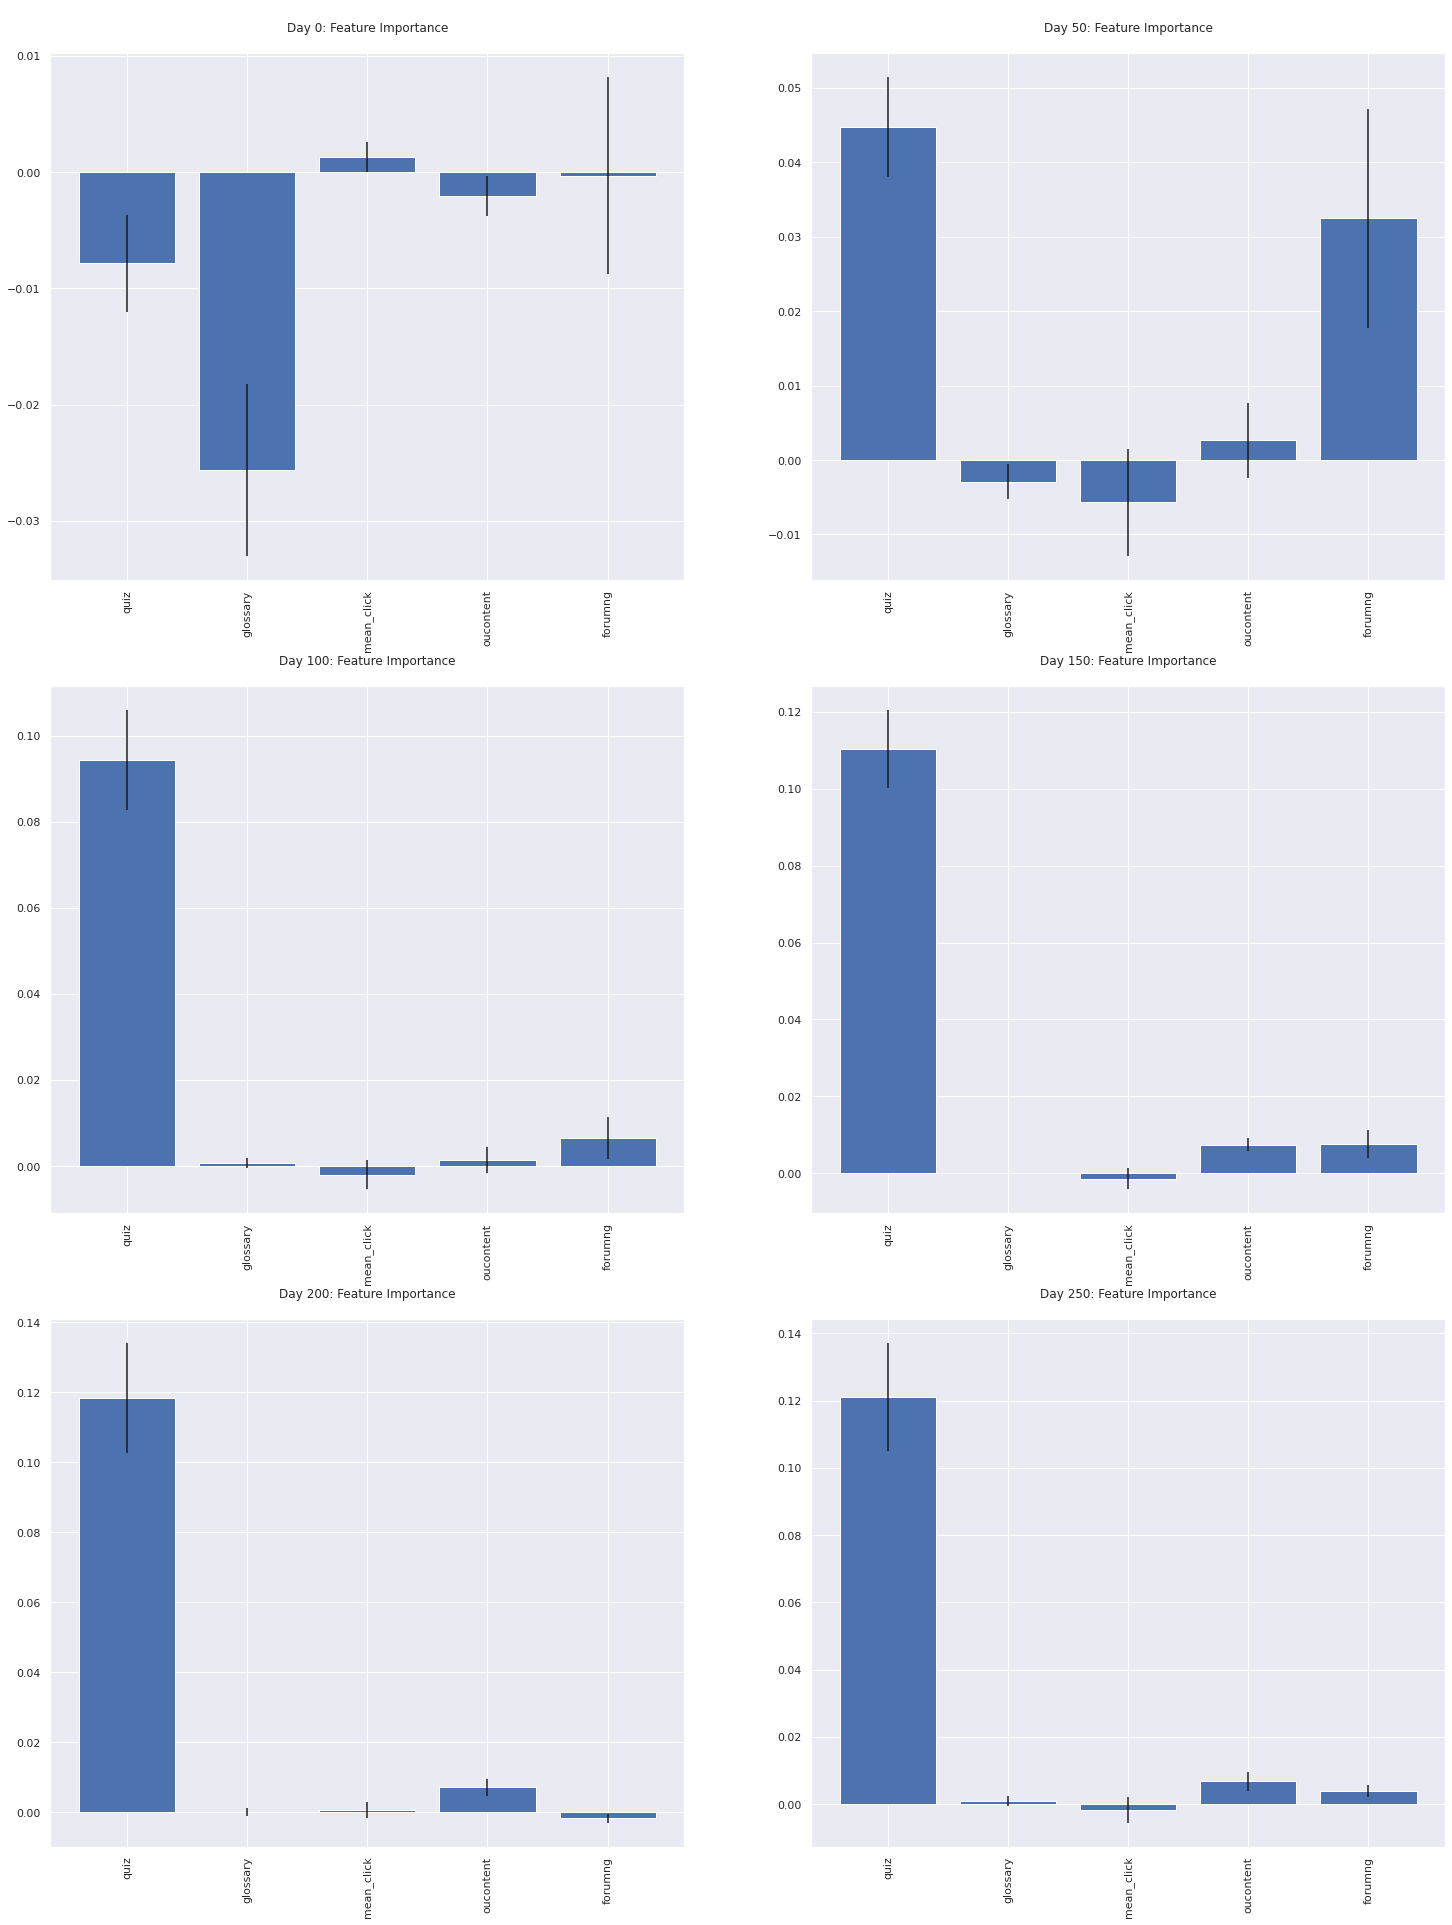

In [ ]:
plot_feature_importance(learning_behiviour_features_ab)

##### Plot results overview

In [ ]:
learning_behaviour_classifier_results = [learning_behaviour_results_du, learning_behaviour_results_nb, learning_behaviour_results_lr, learning_behaviour_results_lrw, learning_behaviour_results_rf, learning_behaviour_results_ab]
learning_behaviour_classifier_labels = ["Dummy Classifier", "Naive Bayes", "Logistic Regression", "Logistic Regression Weighted", "Random Forest", "AdaBoost"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-

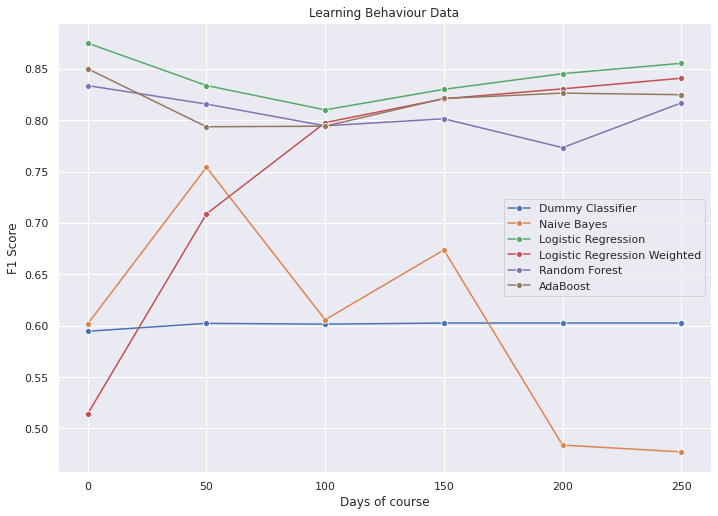

In [ ]:
plot_days_compare(deadline_list,learning_behaviour_classifier_results,learning_behaviour_classifier_labels, "Learning Behaviour Data")

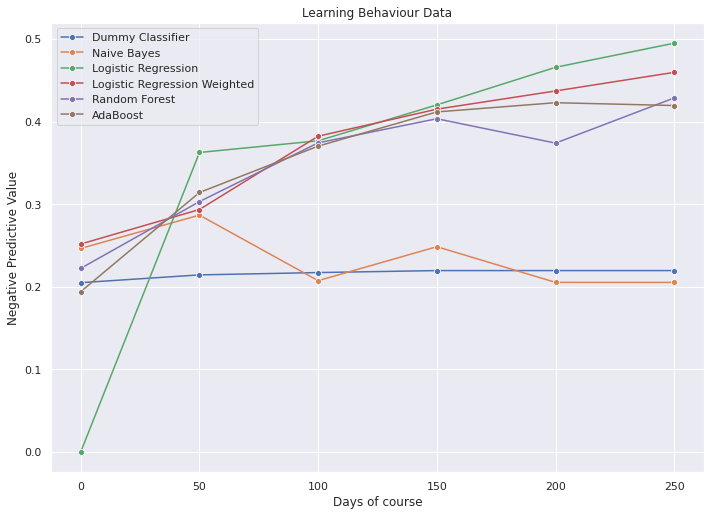

In [ ]:
plot_days_compare_npv(deadline_list,learning_behaviour_classifier_results,learning_behaviour_classifier_labels, "Learning Behaviour Data")

#### Performance data

##### Prepare data for prediction

In [ ]:
performance_df = {}
for i in list(df.keys())[1:]:
  performance_df[i] = split_dataframe_by_data_type(df[i], ['performance'], include_final_result=True)

In [ ]:
performance_df[250]

code_presentation  id_student      score  weighted_score  final_result
0                2013B       23629  82.500000          17.020             0
1                2013B       25107  77.363636          61.361             1
2                2013B       29144  73.222222          53.679             0
3                2013B       31663  79.272727          64.792             1
4                2013B       34229  88.000000          65.862             1
...                ...         ...        ...             ...           ...
5130             2014J     2688945  74.400000          68.272             1
5131             2014J     2692969  77.000000          70.135             1
5132             2014J     2694919  73.400000          66.767             1
5133             2014J     2698577  64.400000          56.122             0
5134             2014J     2698588  92.400000          92.862             1

[5135 rows x 5 columns]

###### Encode data

In [ ]:
X_train, X_test, Y_train, Y_test = encode_data(performance_df, ["2013J"], "2014J")

Index([], dtype='object') Index(['score', 'weighted_score'], dtype='object')
Index([], dtype='object') Index(['score', 'weighted_score'], dtype='object')
Index([], dtype='object') Index(['score', 'weighted_score'], dtype='object')
Index([], dtype='object') Index(['score', 'weighted_score'], dtype='object')
Index([], dtype='object') Index(['score', 'weighted_score'], dtype='object')


In [ ]:
X_train[50]

score  weighted_score
1126  0.932642        0.939652
1127  0.652850        0.669457
1128  0.787565        0.770082
1129  0.782383        0.756087
1130  0.751295        0.771567
...        ...             ...
2588  0.476684        0.105576
2589  0.803109        0.794519
2590  0.880829        0.899149
2591  0.621762        0.620584
2592  0.544041        0.592008

[1467 rows x 2 columns]

###### Undersampling

In [ ]:
Y_train[50].value_counts()

1    1053
0     414
Name: final_result, dtype: int64

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

from collections import Counter

X_train_sample, Y_train_sample = {},{}

for i in list(df.keys())[1:]:

  sampler = RandomUnderSampler() # fit predictor and target variable
  X_train_sample[i], Y_train_sample[i] = sampler.fit_resample(X_train[i], Y_train[i])

  print(f"Sampling for day {i}")
  print('Original dataset shape:', Counter(Y_train[i]))
  print('Resample dataset shape', Counter(Y_train_sample[i]))

Sampling for day 50
Original dataset shape: Counter({1: 1053, 0: 414})
Resample dataset shape Counter({0: 414, 1: 414})
Sampling for day 100
Original dataset shape: Counter({1: 1060, 0: 417})
Resample dataset shape Counter({0: 417, 1: 417})
Sampling for day 150
Original dataset shape: Counter({1: 1063, 0: 421})
Resample dataset shape Counter({0: 421, 1: 421})
Sampling for day 200
Original dataset shape: Counter({1: 1063, 0: 421})
Resample dataset shape Counter({0: 421, 1: 421})
Sampling for day 250
Original dataset shape: Counter({1: 1064, 0: 421})
Resample dataset shape Counter({0: 421, 1: 421})


##### DummyClassifier

In [ ]:
from sklearn.dummy import DummyClassifier

performance_results_du = []
performance_features_du = []

pipeline = Pipeline([
    ('clf', DummyClassifier(strategy="uniform",random_state=RANDOM_SEED)),
])

params = {
}

for i in list(df.keys())[1:]:
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  performance_results_du.append([acc, f1, prec, recall, conf])
  performance_features_du.append([tuned_model, X_test[i], Y_test[i]])
  print("\n")

Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.516
Best parameters set:
Accuracy: 0.49176954732510286, F1 Score: 0.6022544283413849, Precision: 0.7684931506849315, Recall: 0.49514563106796117


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.497
Best parameters set:
Accuracy: 0.491869918699187, F1 Score: 0.6014877789585547, Precision: 0.7658998646820027, Recall: 0.49518810148731407


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.481
Best parameters set:
Accuracy: 0.4935680433310765, F1 Score: 0.6025504782146653, Precision: 0.7672530446549392, Recall: 0.49606299212598426


Day 200
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.481

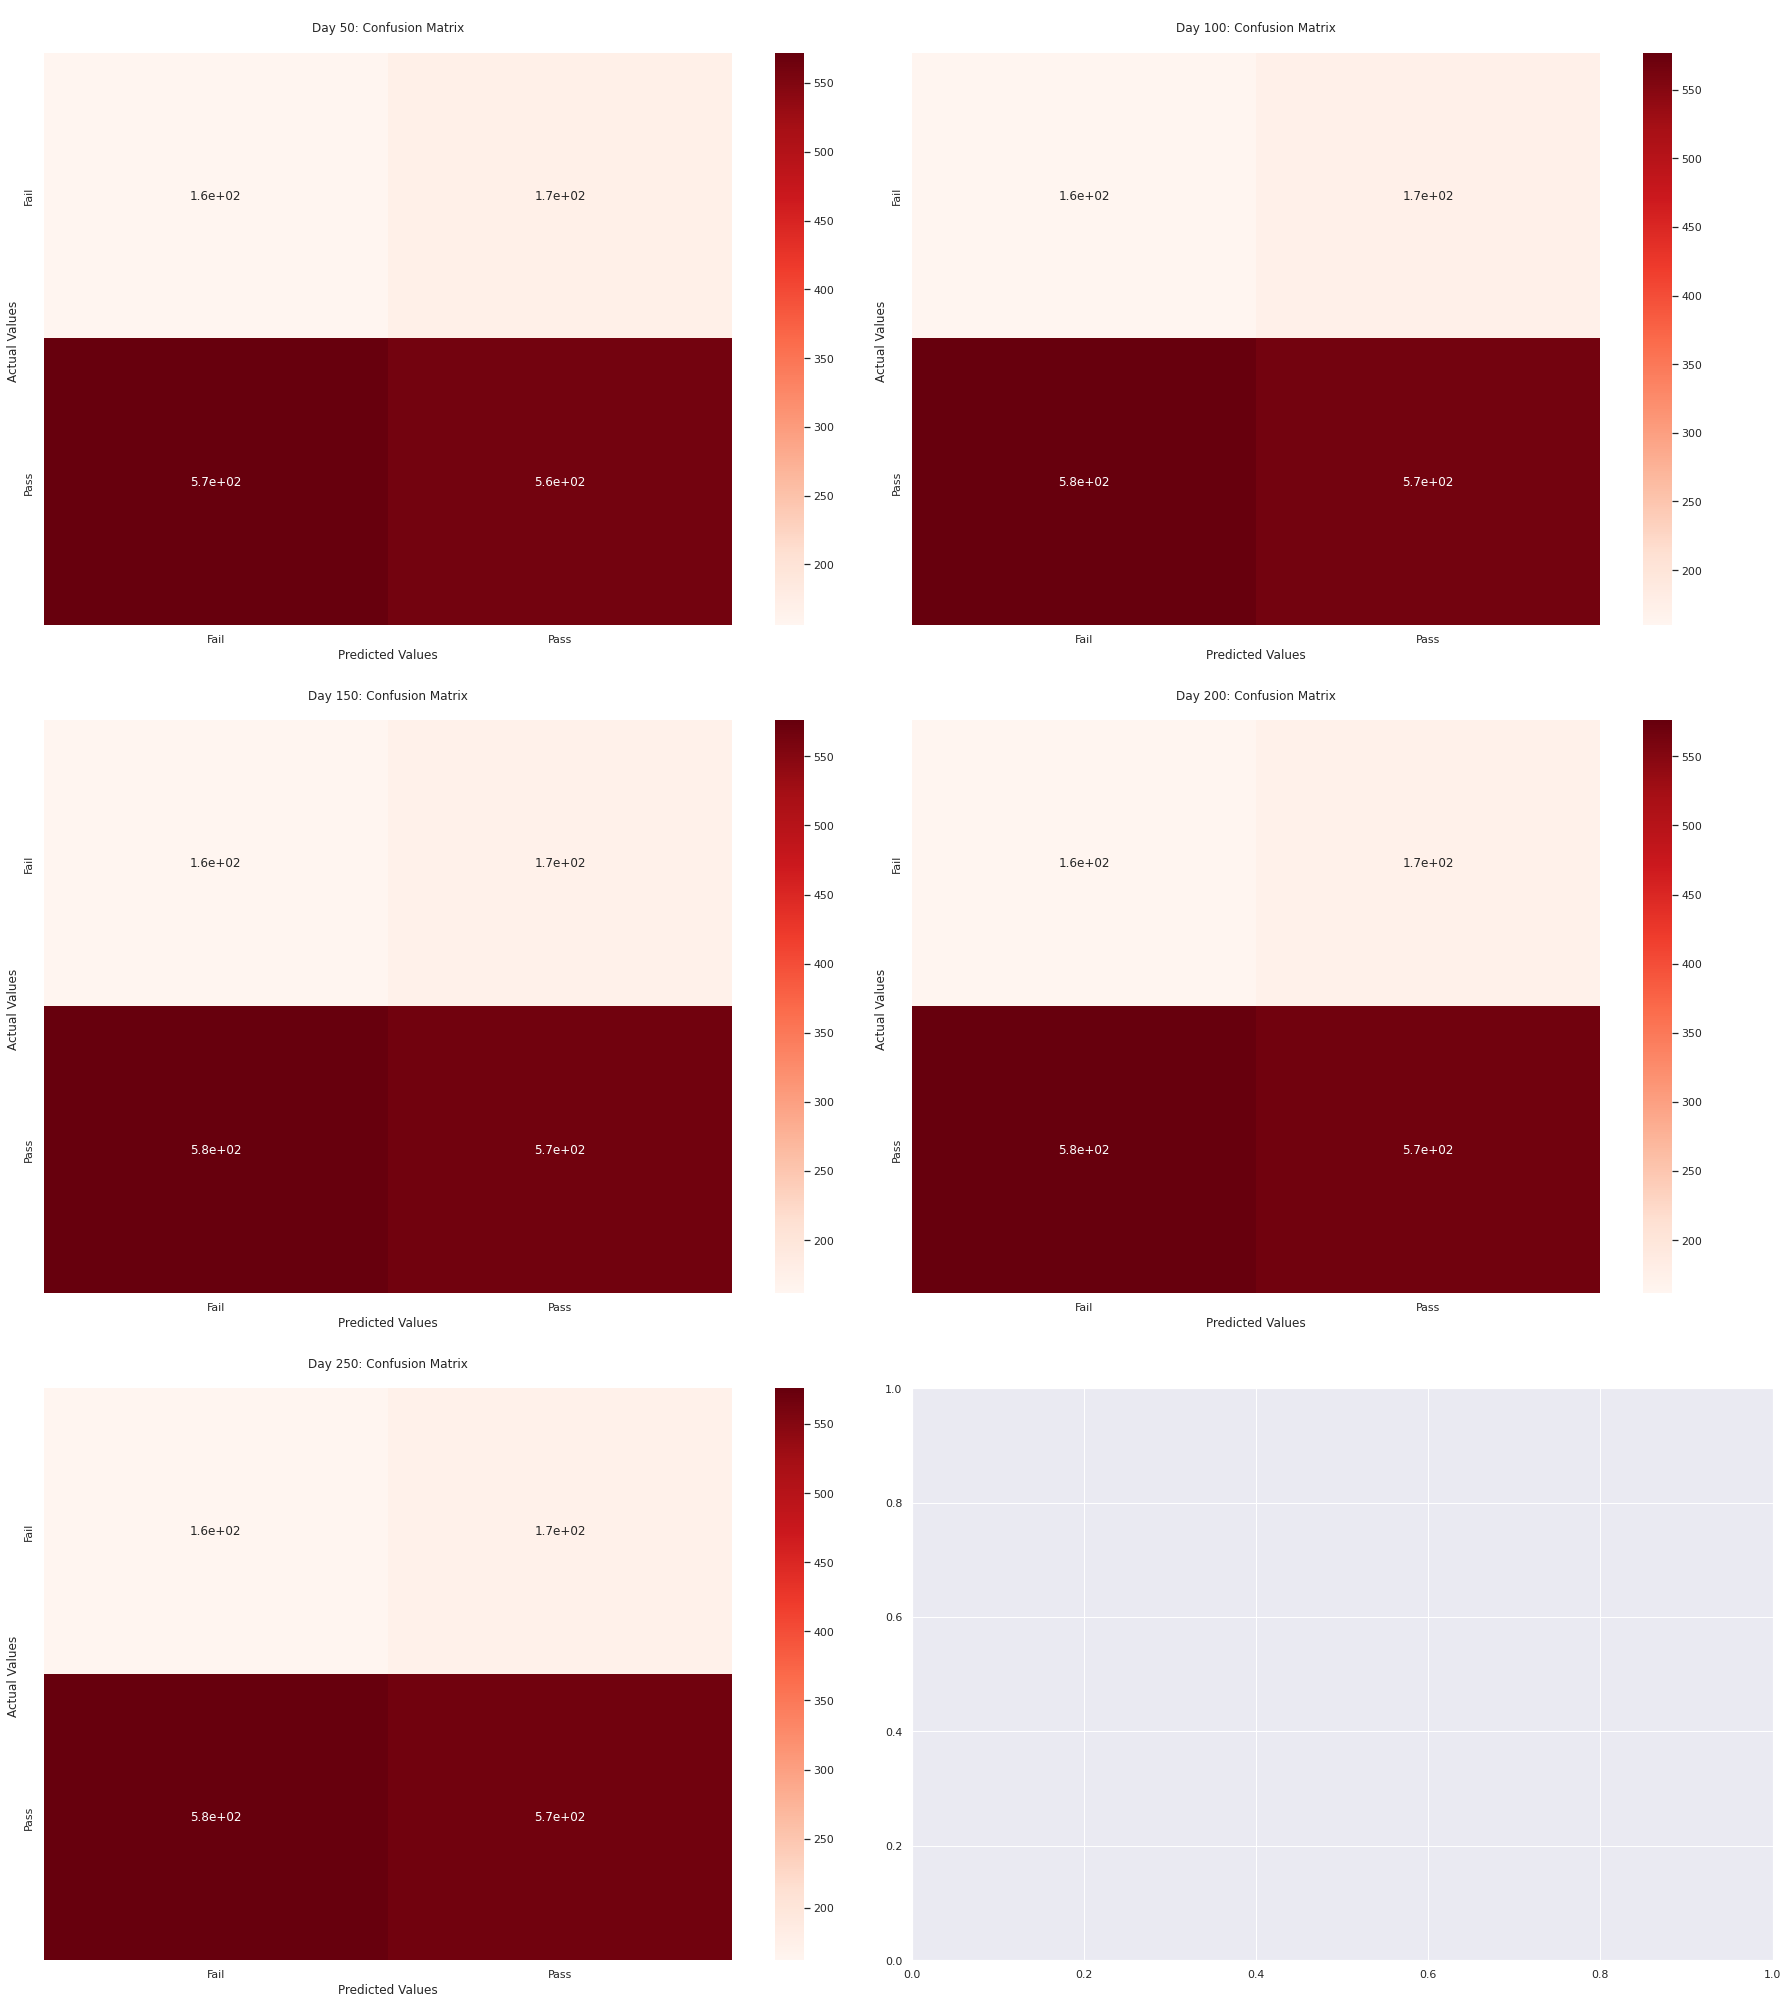

In [ ]:
plot_confusion_matrix(performance_results_du)

##### NaiveBayes

In [ ]:
from sklearn.naive_bayes import GaussianNB,ComplementNB,BernoulliNB,MultinomialNB

performance_results_nb = []
performance_features_nb = []

performance_predict_proba_nb = []

pipeline = Pipeline([
    ('clf', ComplementNB()),
])

params = {
}

for i in list(df.keys())[1:]:
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])
  predictions_proba = tuned_model.predict_proba(X_test[i])

  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  performance_results_nb.append([acc, f1, prec, recall, conf])
  performance_features_nb.append([tuned_model, X_test[i], Y_test[i]])

  performance_predict_proba_nb.append(predictions_proba)

  print("\n")

Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.636
Best parameters set:
Accuracy: 0.22290809327846364, F1 Score: 0.0, Precision: 0.0, Recall: 0.0


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.755
Best parameters set:
Accuracy: 0.22560975609756098, F1 Score: 0.0, Precision: 0.0, Recall: 0.0


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.790
Best parameters set:
Accuracy: 0.4245091401489506, F1 Score: 0.44876783398184183, Precision: 0.8671679197994987, Recall: 0.3027121609798775


Day 200
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.827
Best parameters set:
Accuracy: 0.8605280974949221, F1 Score: 0.9101221640488656, Precisio

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best score: 0.849
Best parameters set:
Accuracy: 0.9079214624238321, F1 Score: 0.943238731218698, Precision: 0.9018355945730248, Recall: 0.9886264216972879




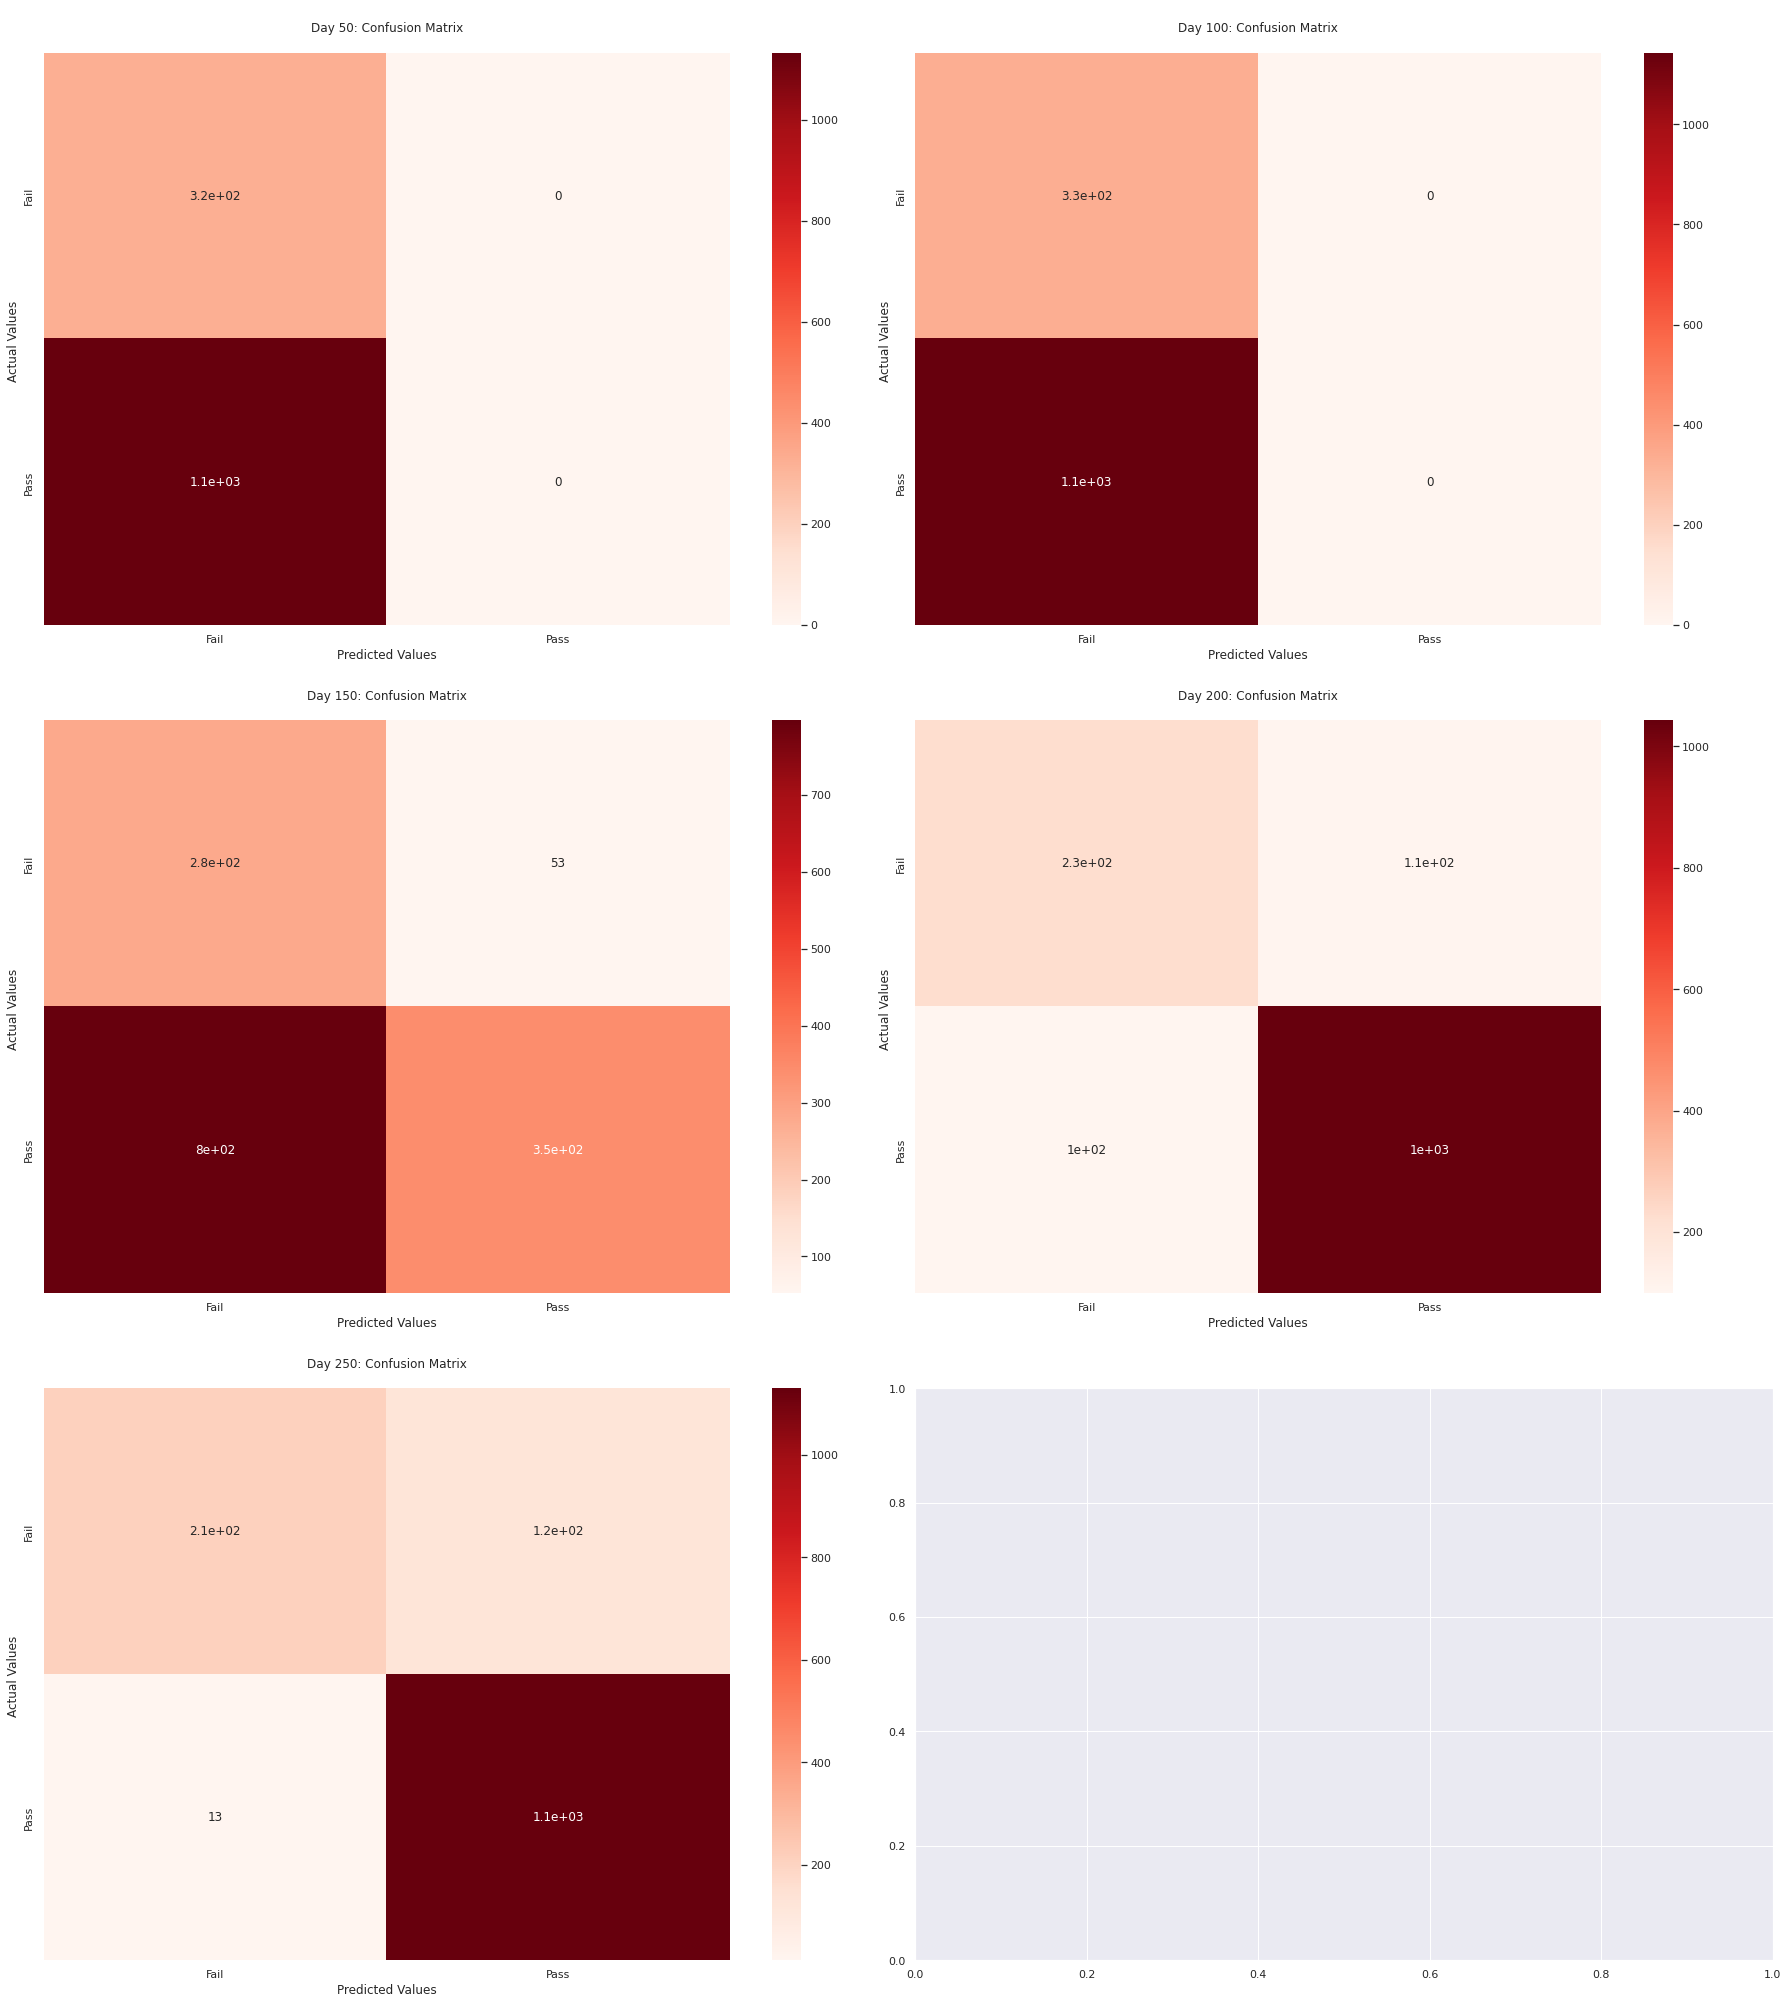

In [ ]:
plot_confusion_matrix(performance_results_nb)

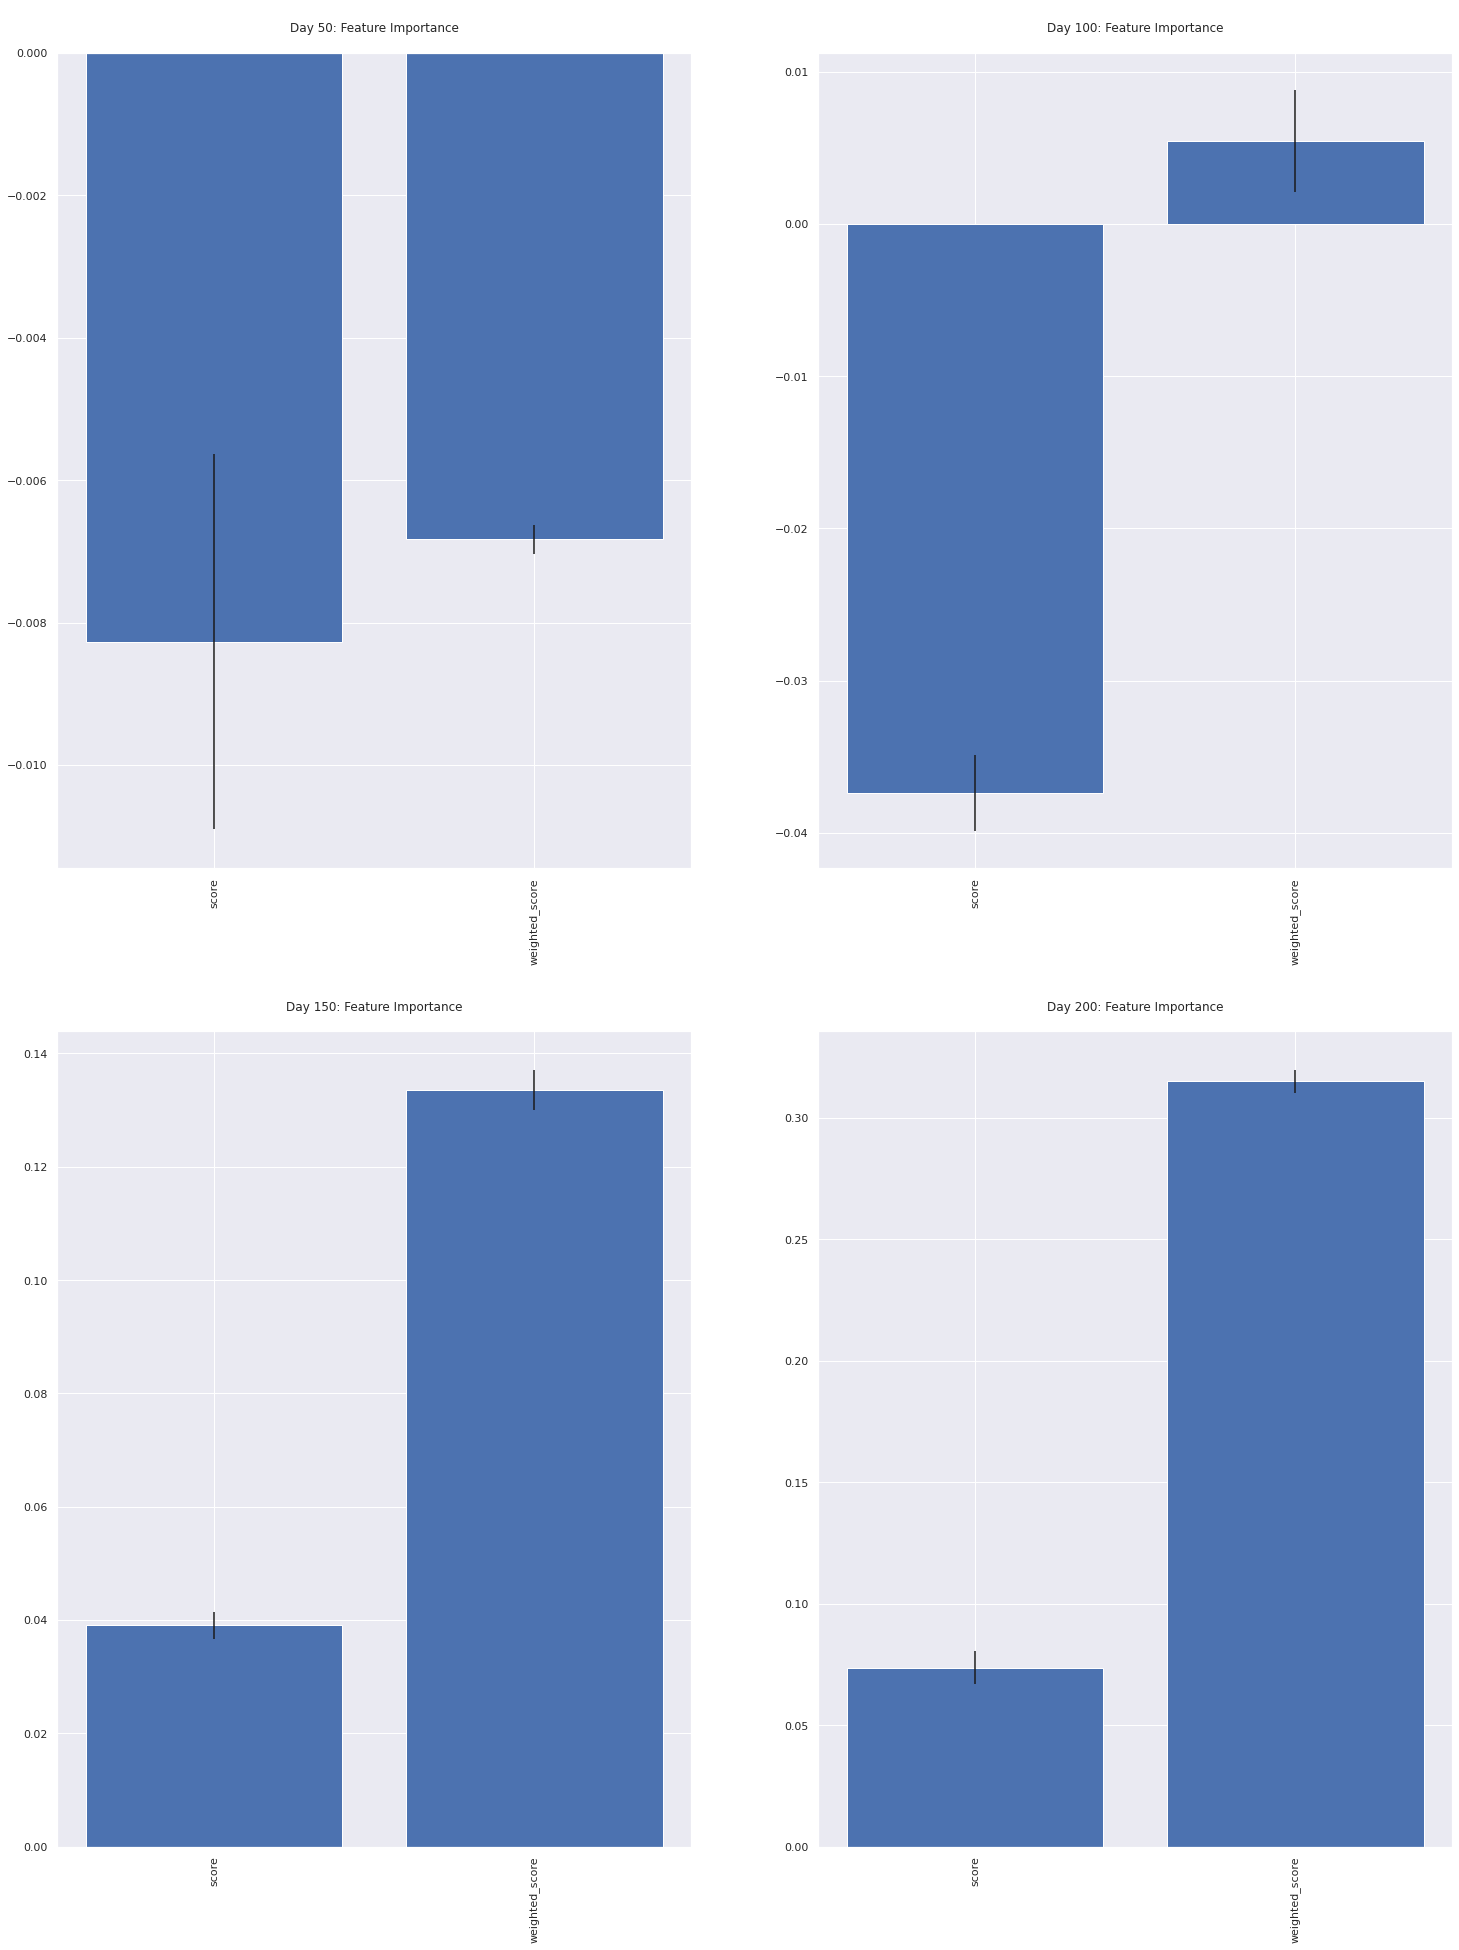

In [ ]:
plot_feature_importance(performance_features_nb)

##### LogisticRegression

In [ ]:
from sklearn.linear_model import LogisticRegression

performance_results_lr = []
performance_features_lr = []

pipeline = Pipeline([
    ('clf', LogisticRegression()),
])

params = {
  'clf__penalty': ['l2', 'none']
}

for i in list(df.keys())[1:]:
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  performance_results_lr.append([acc, f1, prec, recall, conf])
  performance_features_lr.append([tuned_model, X_test[i], Y_test[i]])
  print("\n")


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.674
Best parameters set:
	clf__penalty: 'l2'
Accuracy: 0.22290809327846364, F1 Score: 0.0, Precision: 0.0, Recall: 0.0


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.782
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.22560975609756098, F1 Score: 0.0, Precision: 0.0, Recall: 0.0


Day 150
Performing grid search...

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.810
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.23019634394041977, F1 Score: 0.010443864229765013, Precision: 1.0, Recall: 0.005249343832020997


Day 200
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.836
Best parameters set:
	clf__penalty: 'l2'
Accuracy: 0.7941773865944483, F1 Score: 0.8551000953288846, Precision: 0.9392670157068063, Recall: 0.7847769028871391


Day 250
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.856
Best parameters set:
	clf__penalty: 'l2'
Accuracy: 0.9113067027758971, F1 Score: 0.9436074042186827, Precision: 0.9288135593220339, Recall: 0.9588801399825022




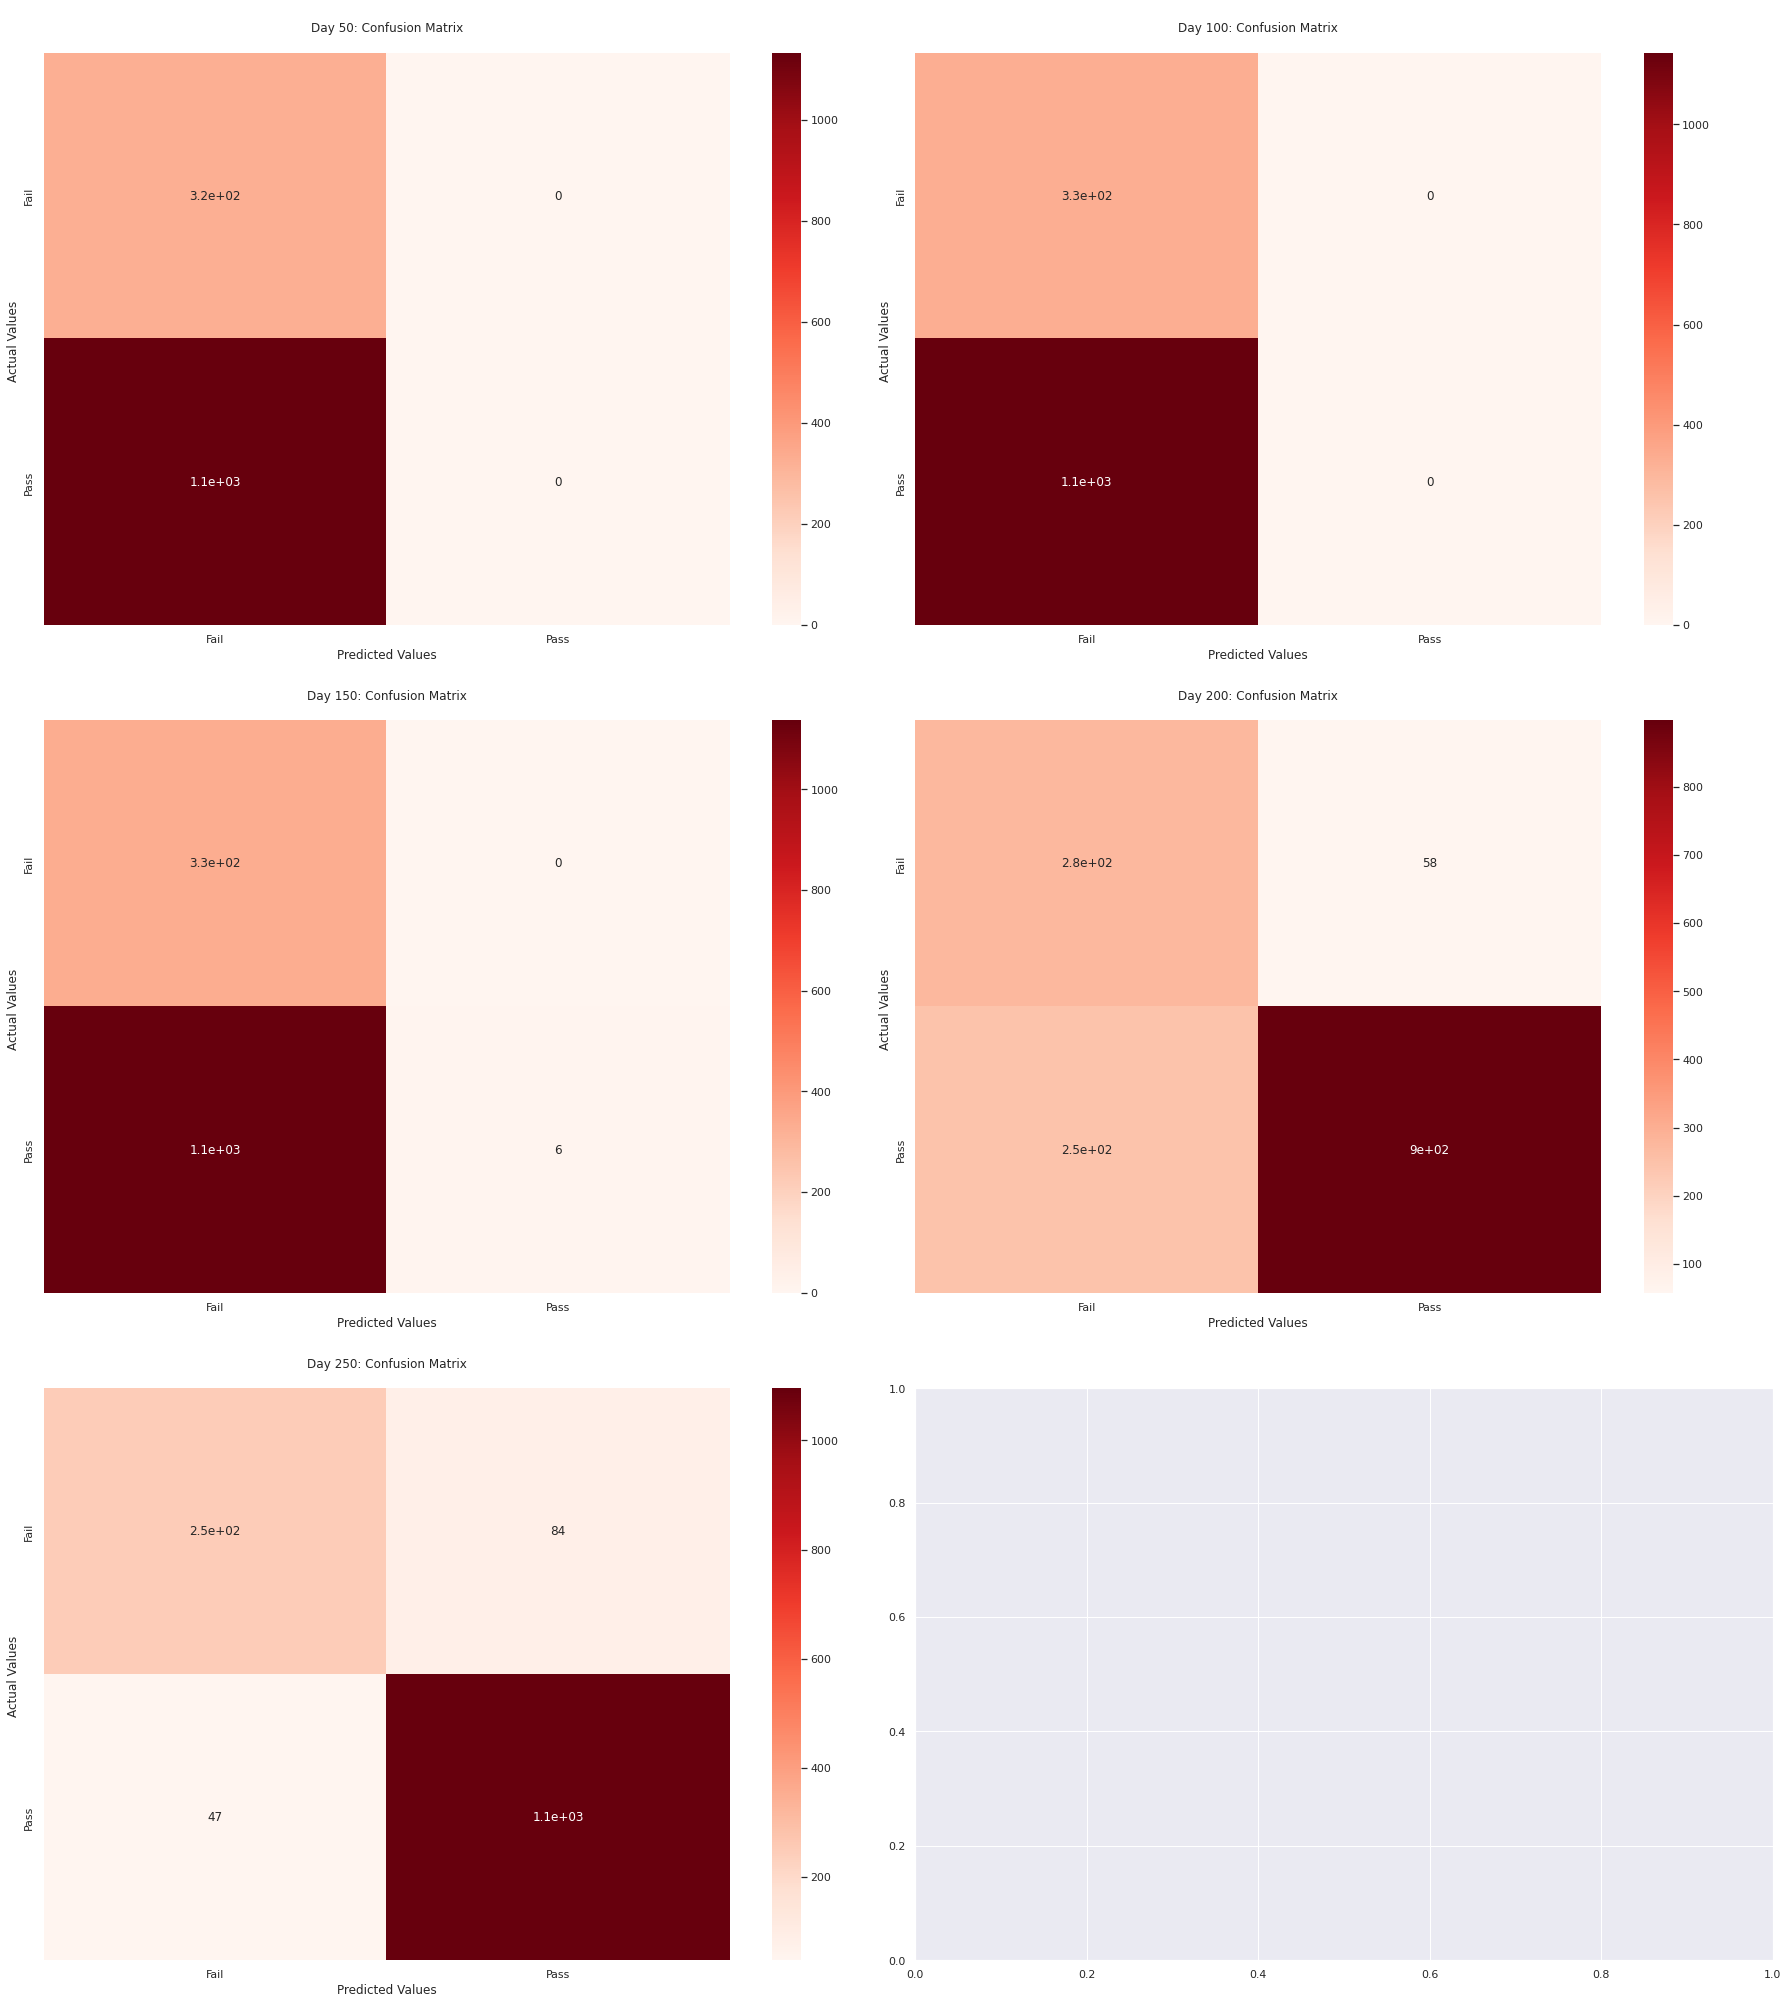

In [ ]:
plot_confusion_matrix(performance_results_lr)

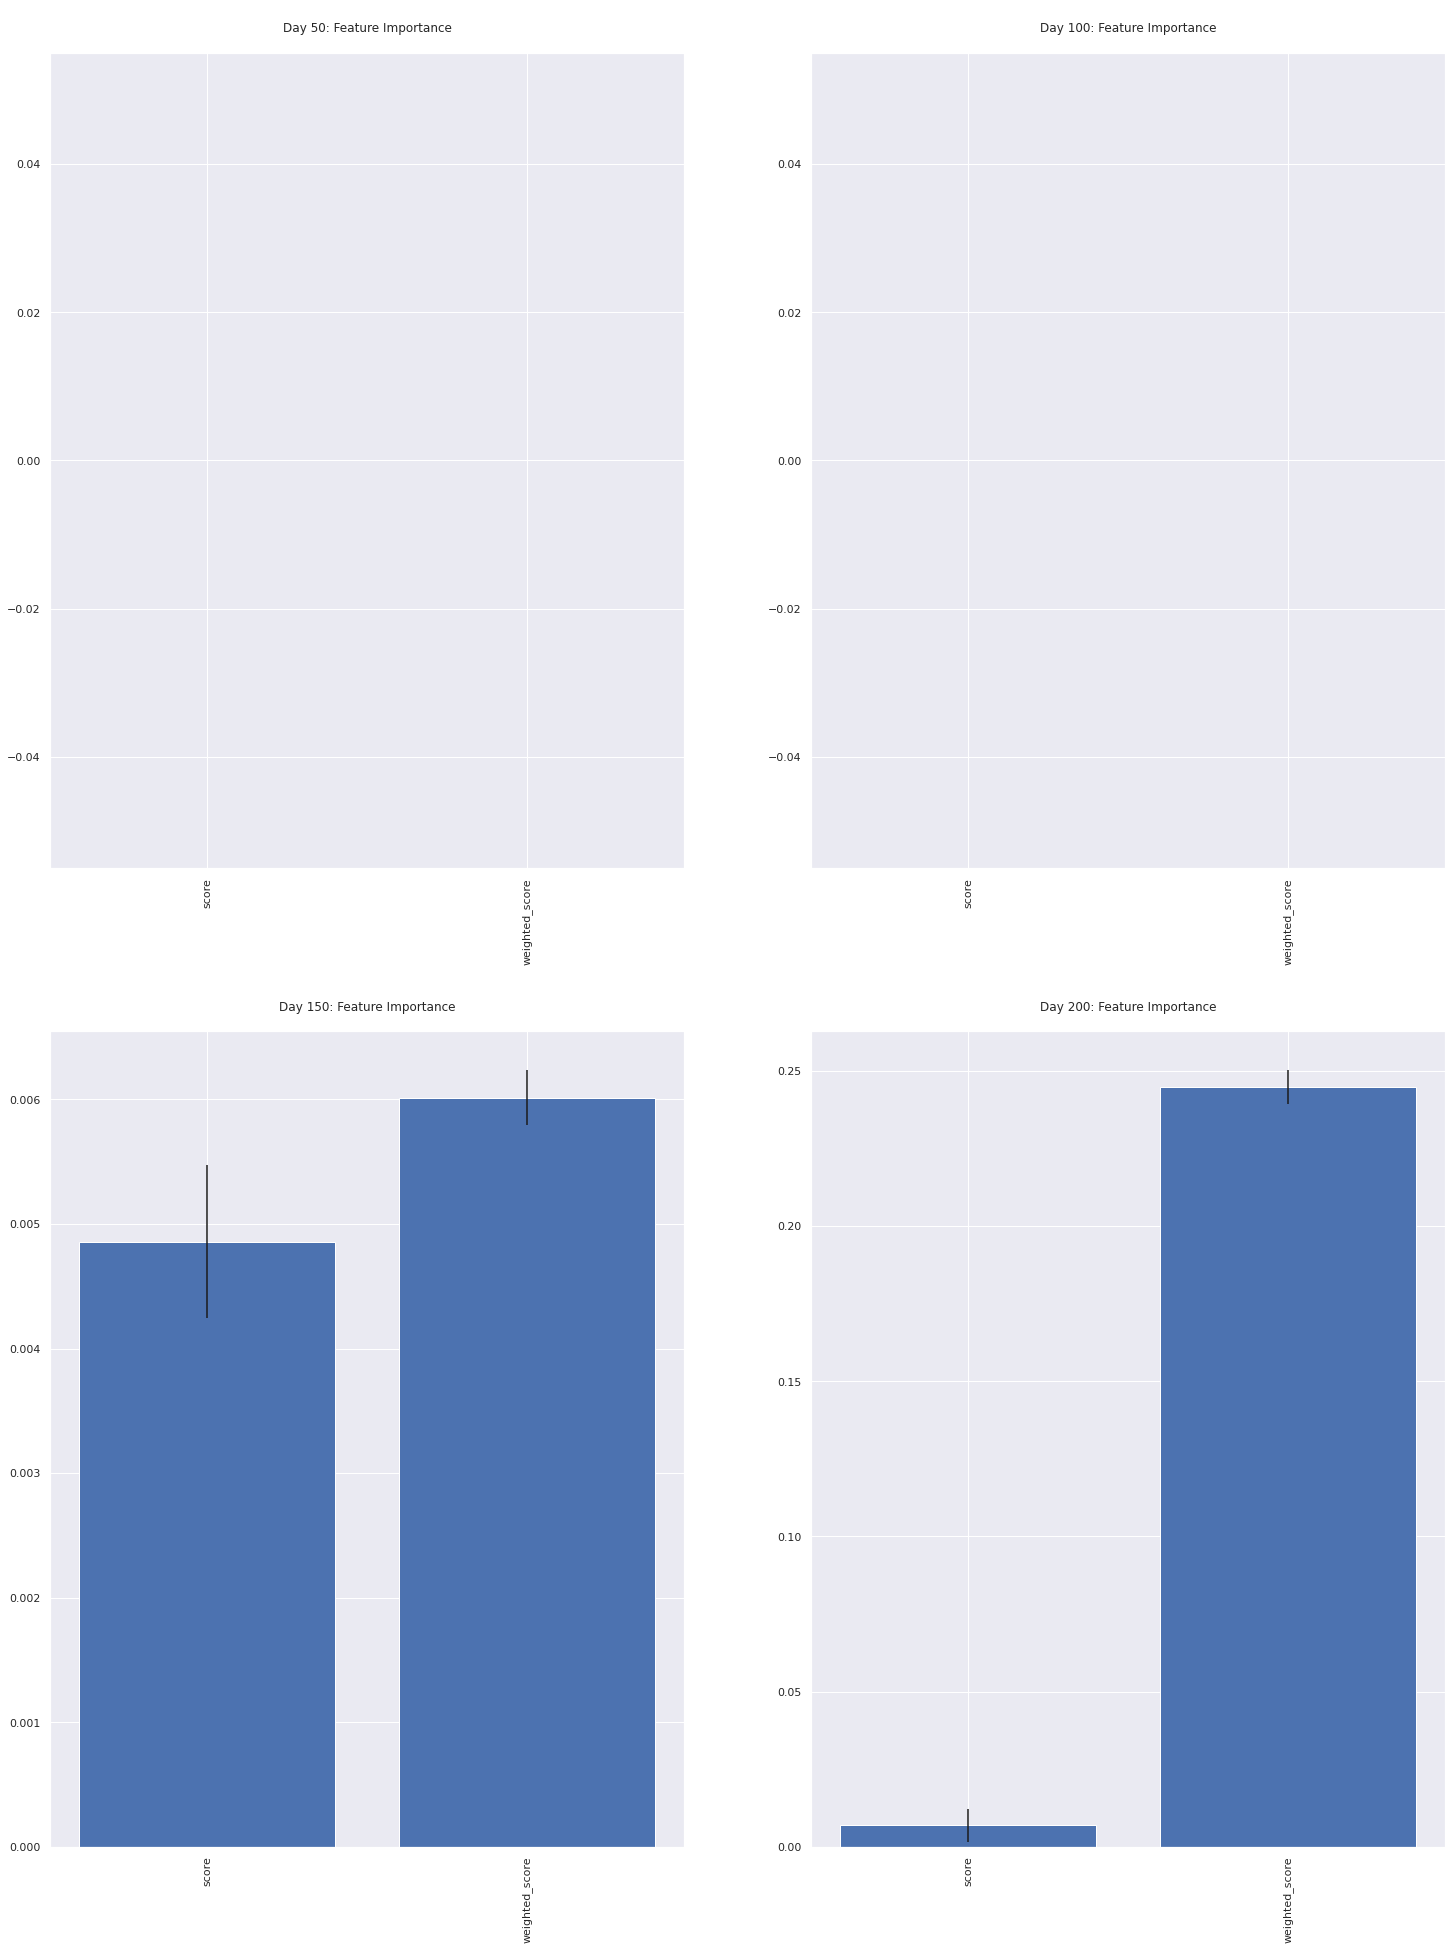

In [ ]:
plot_feature_importance(performance_features_lr)

##### WeightedLogisticRegression

In [ ]:
performance_results_lrw = []
performance_features_lrw = []

pipeline = Pipeline([
    ('clf', LogisticRegression(class_weight = 'balanced')),
])

params = {
  
}

for i in list(df.keys())[1:]:
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  performance_results_lrw.append([acc, f1, prec, recall, conf])
  performance_features_lrw.append([tuned_model, X_test[i], Y_test[i]])
  print("\n")

Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.677
Best parameters set:
Accuracy: 0.22290809327846364, F1 Score: 0.0, Precision: 0.0, Recall: 0.0


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.763
Best parameters set:
Accuracy: 0.22560975609756098, F1 Score: 0.0, Precision: 0.0, Recall: 0.0


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.799
Best parameters set:
Accuracy: 0.22613405551794177, F1 Score: 0.0, Precision: 0.0, Recall: 0.0


Day 200
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best score: 0.822
Best parameters set:
Accuracy: 0.5226811103588355, F1 Score: 0.5656192236598891, Precision: 0.95625, Recall: 0.4015748031496063


Day 250
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.838
Best parameters set:
Accuracy: 0.8314150304671631, F1 Score: 0.8831534490849366, Precision: 0.9524291497975709, Recall: 0.8232720909886264




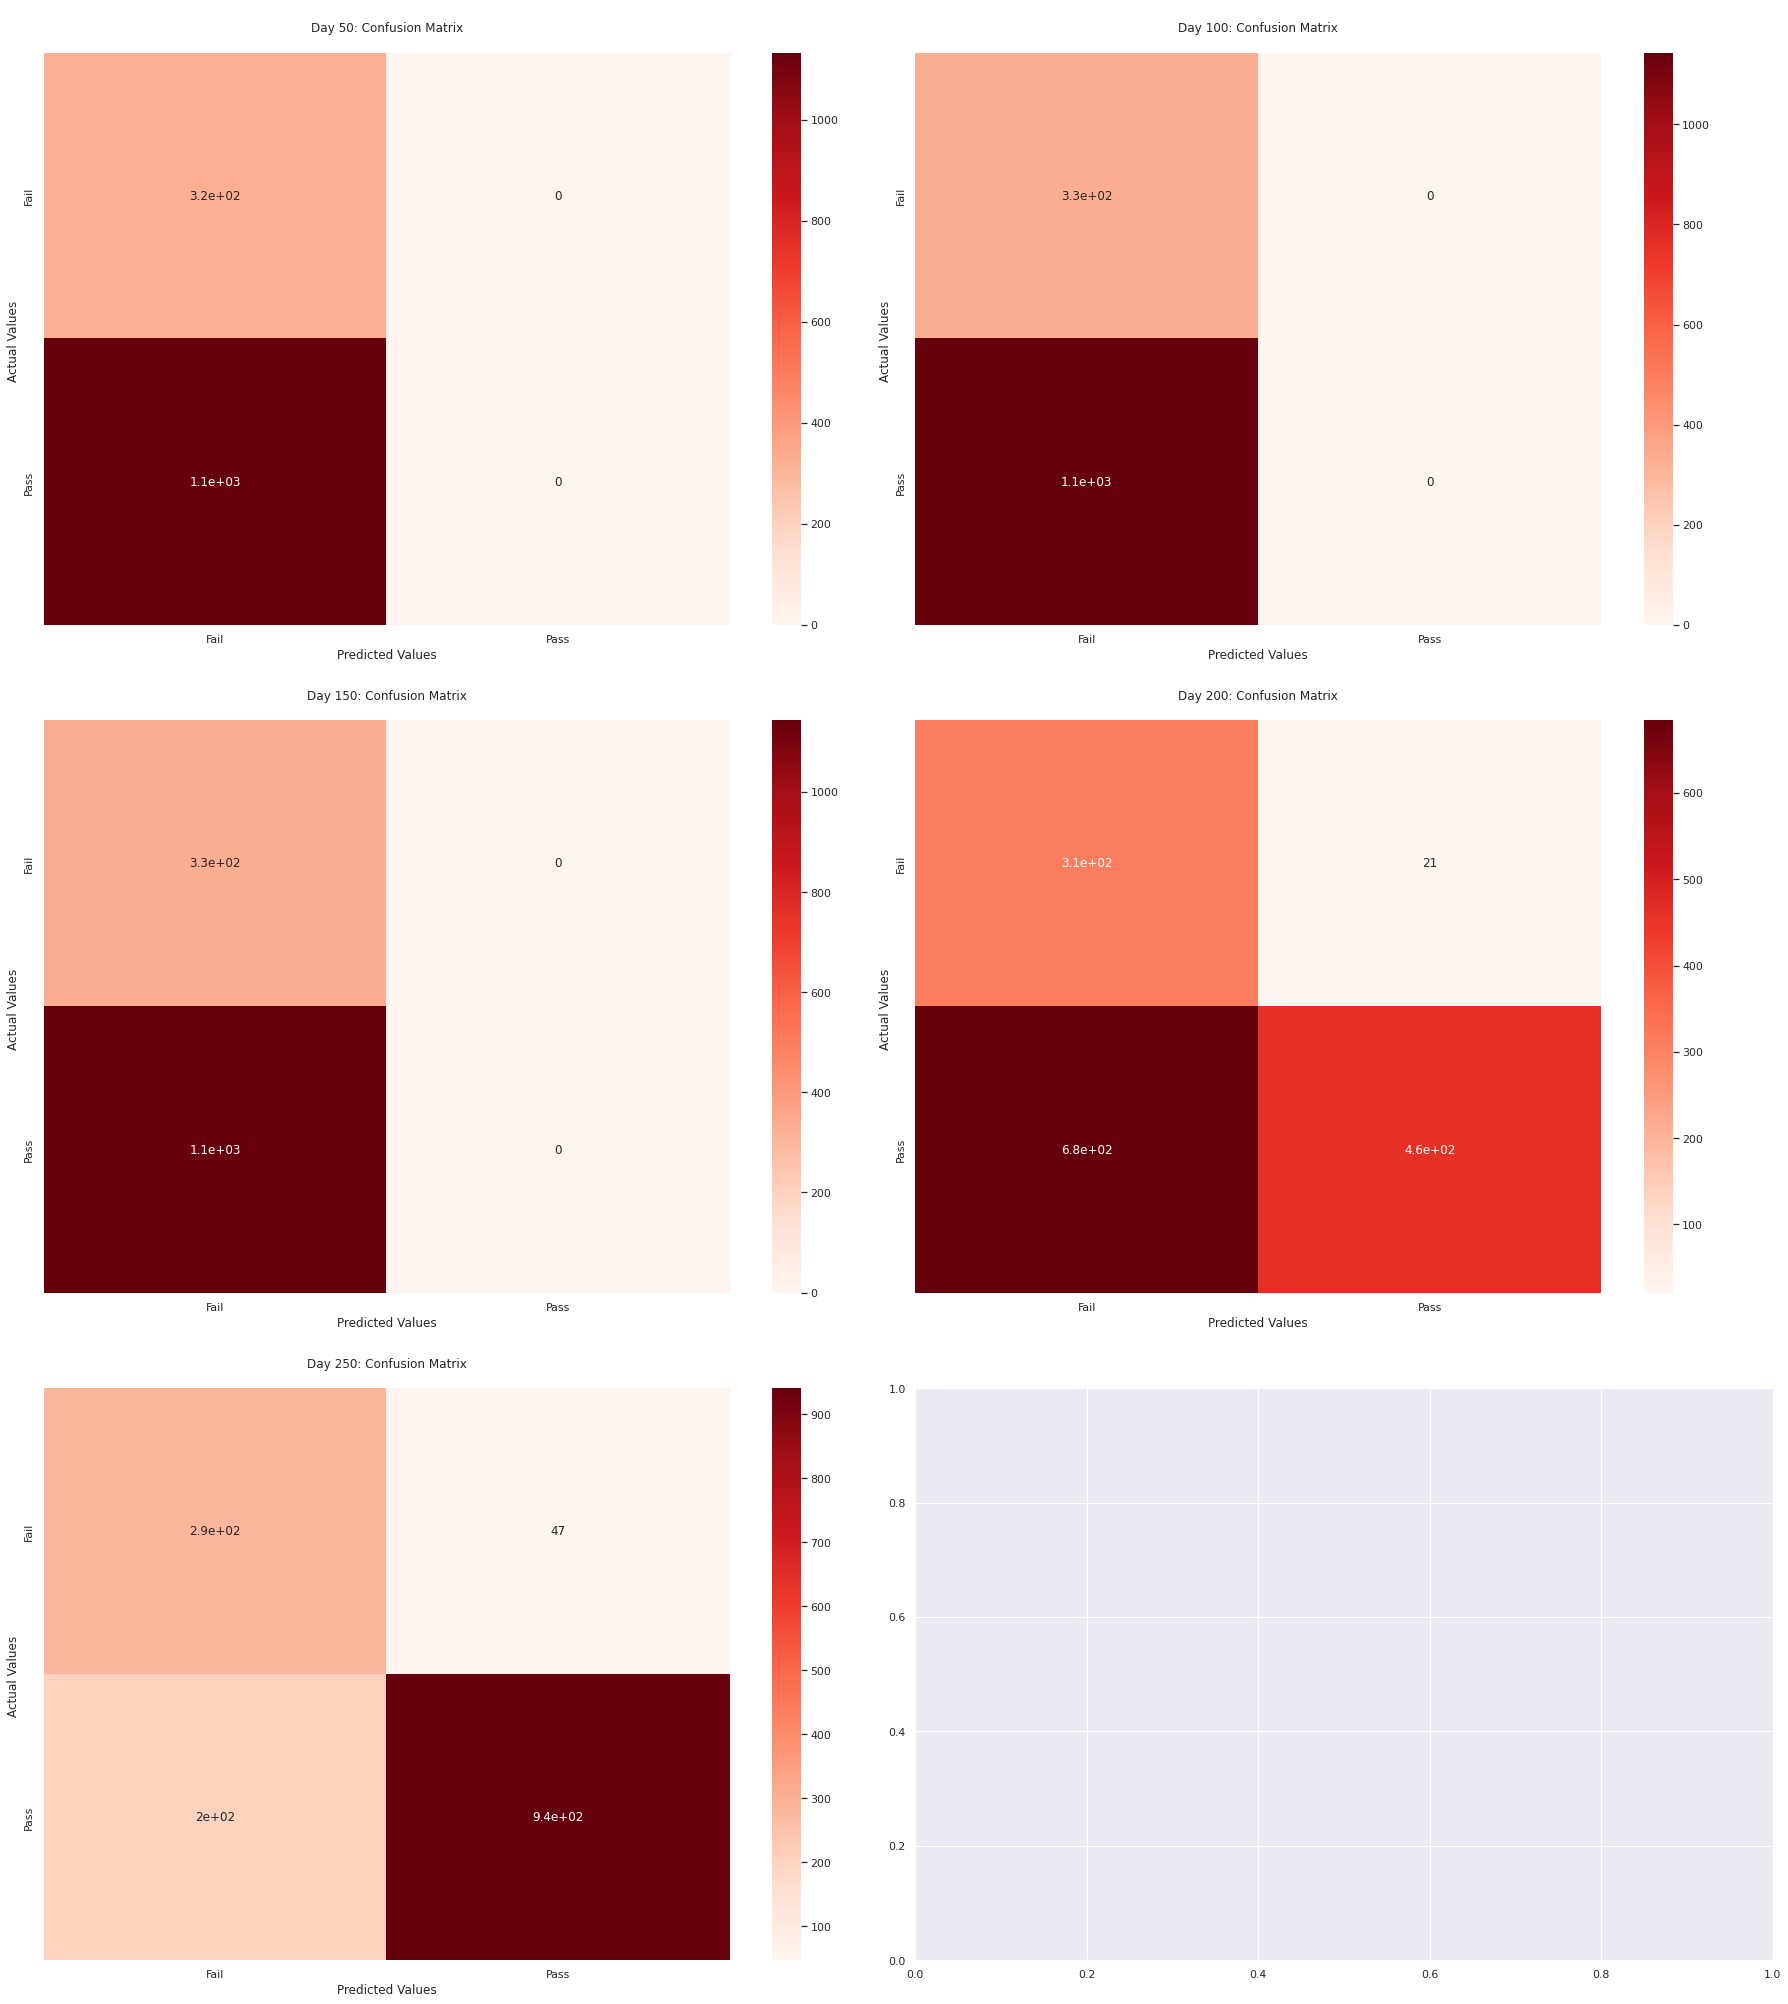

In [ ]:
plot_confusion_matrix(performance_results_lrw)

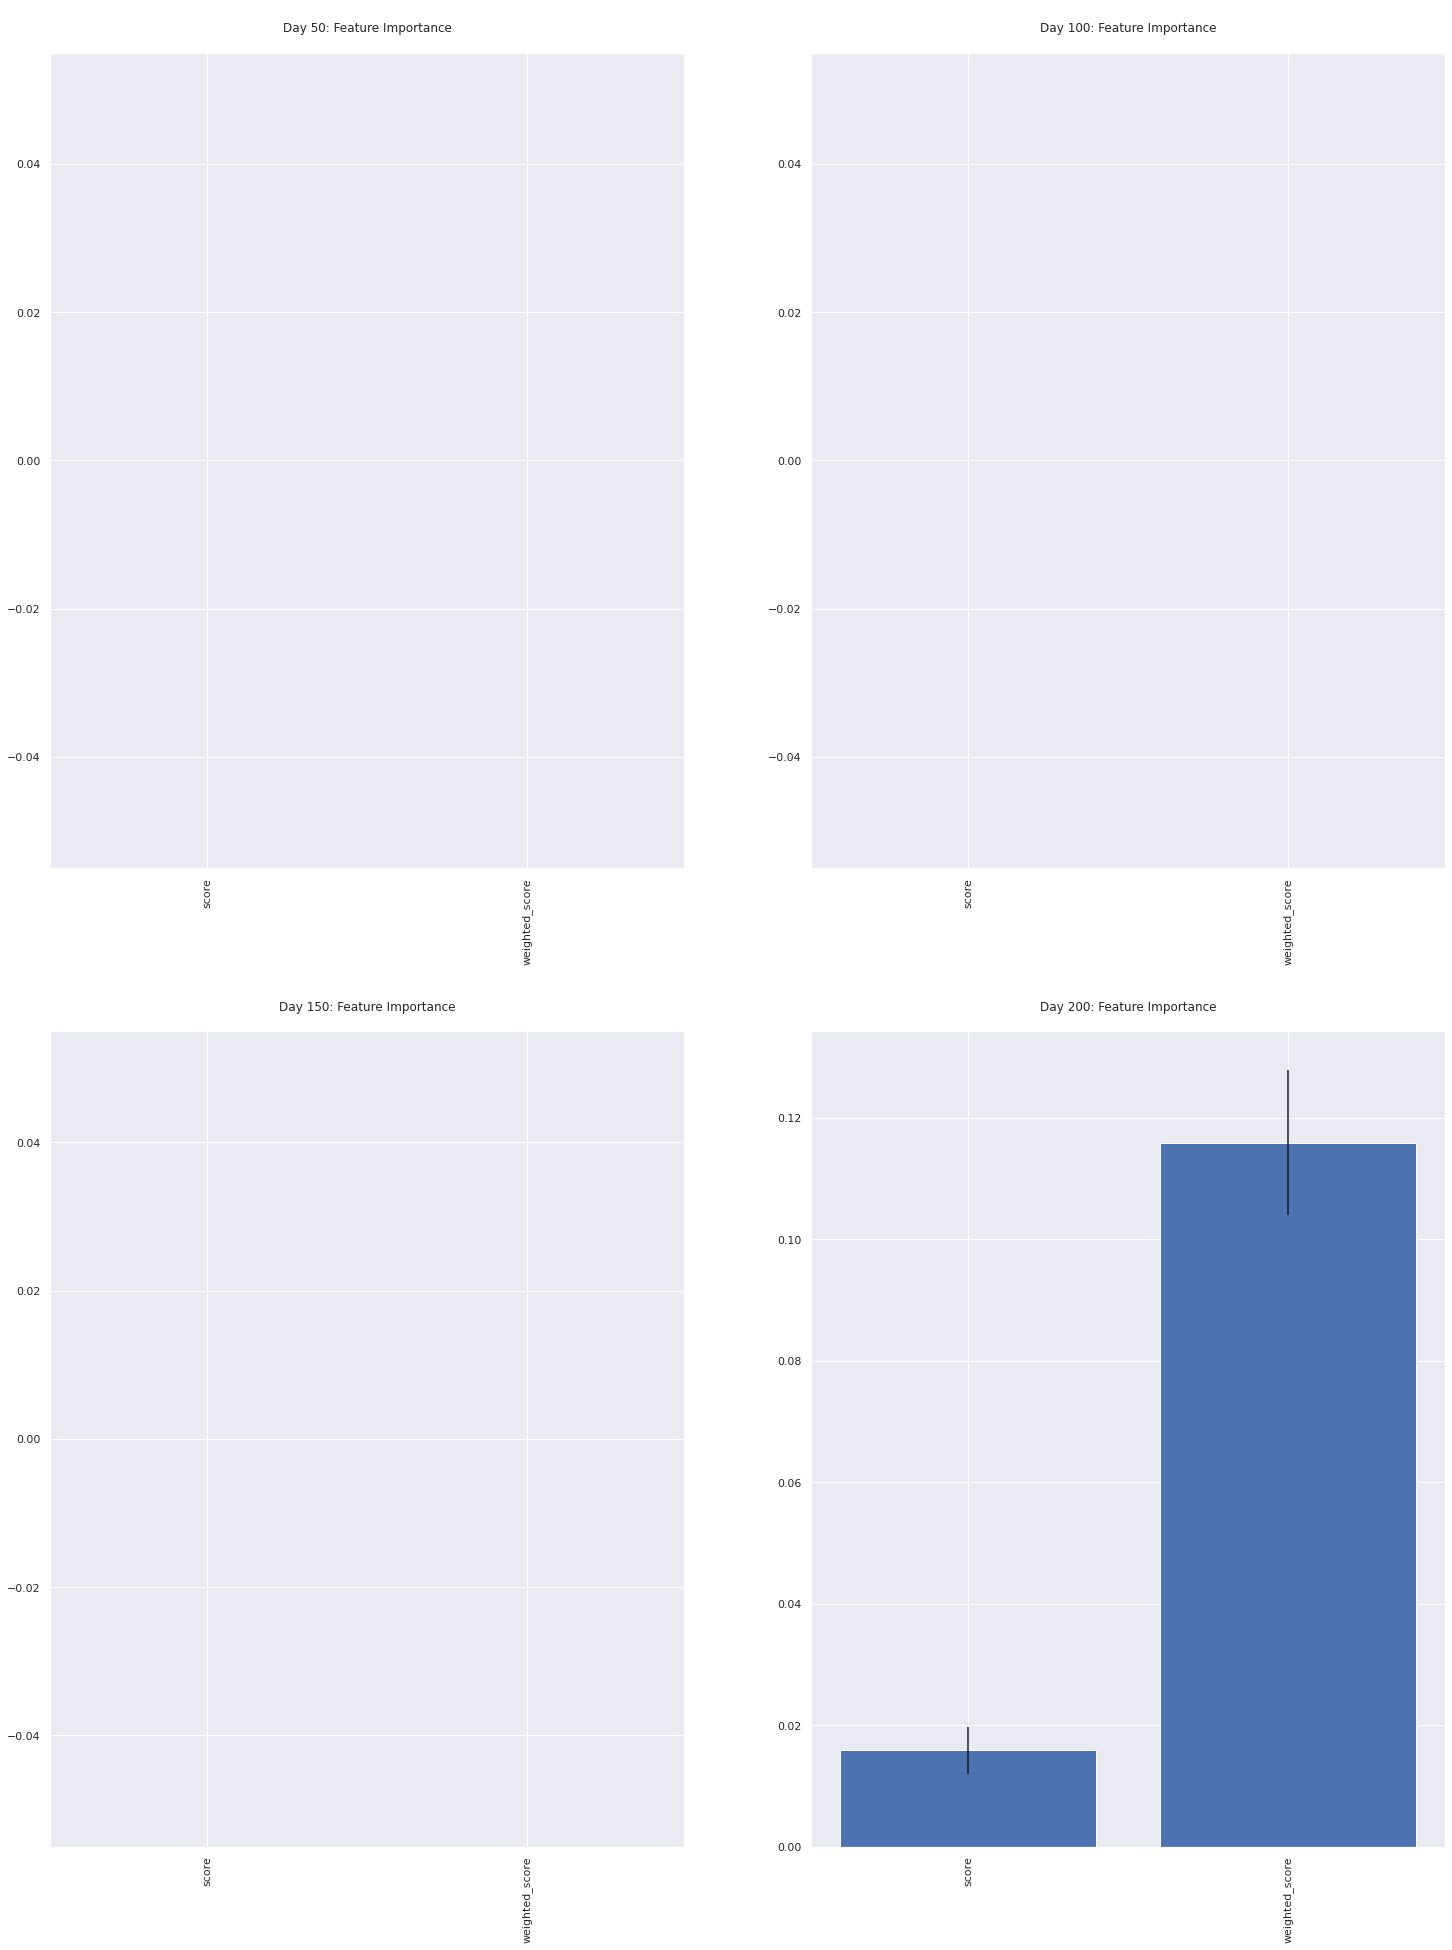

In [ ]:
plot_feature_importance(performance_features_lrw)

##### RandomForest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

performance_results_rf = []
performance_features_rf = []

pipeline = Pipeline([
    ('clf', RandomForestClassifier(random_state=RANDOM_SEED)),
])

params = {
  'clf__n_estimators': [x for x in range(50,150,10)]
}

for i in list(df.keys())[1:]:
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  performance_results_rf.append([acc, f1, prec, recall, conf])
  performance_features_rf.append([tuned_model, X_test[i], Y_test[i]])
  print("\n")

Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.652
Best parameters set:
	clf__n_estimators: 140
Accuracy: 0.2222222222222222, F1 Score: 0.0, Precision: 0.0, Recall: 0.0


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.745
Best parameters set:
	clf__n_estimators: 90
Accuracy: 0.22493224932249323, F1 Score: 0.0, Precision: 0.0, Recall: 0.0


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.804
Best parameters set:
	clf__n_estimators: 110
Accuracy: 0.23222748815165878, F1 Score: 0.017331022530329292, Precision: 0.9090

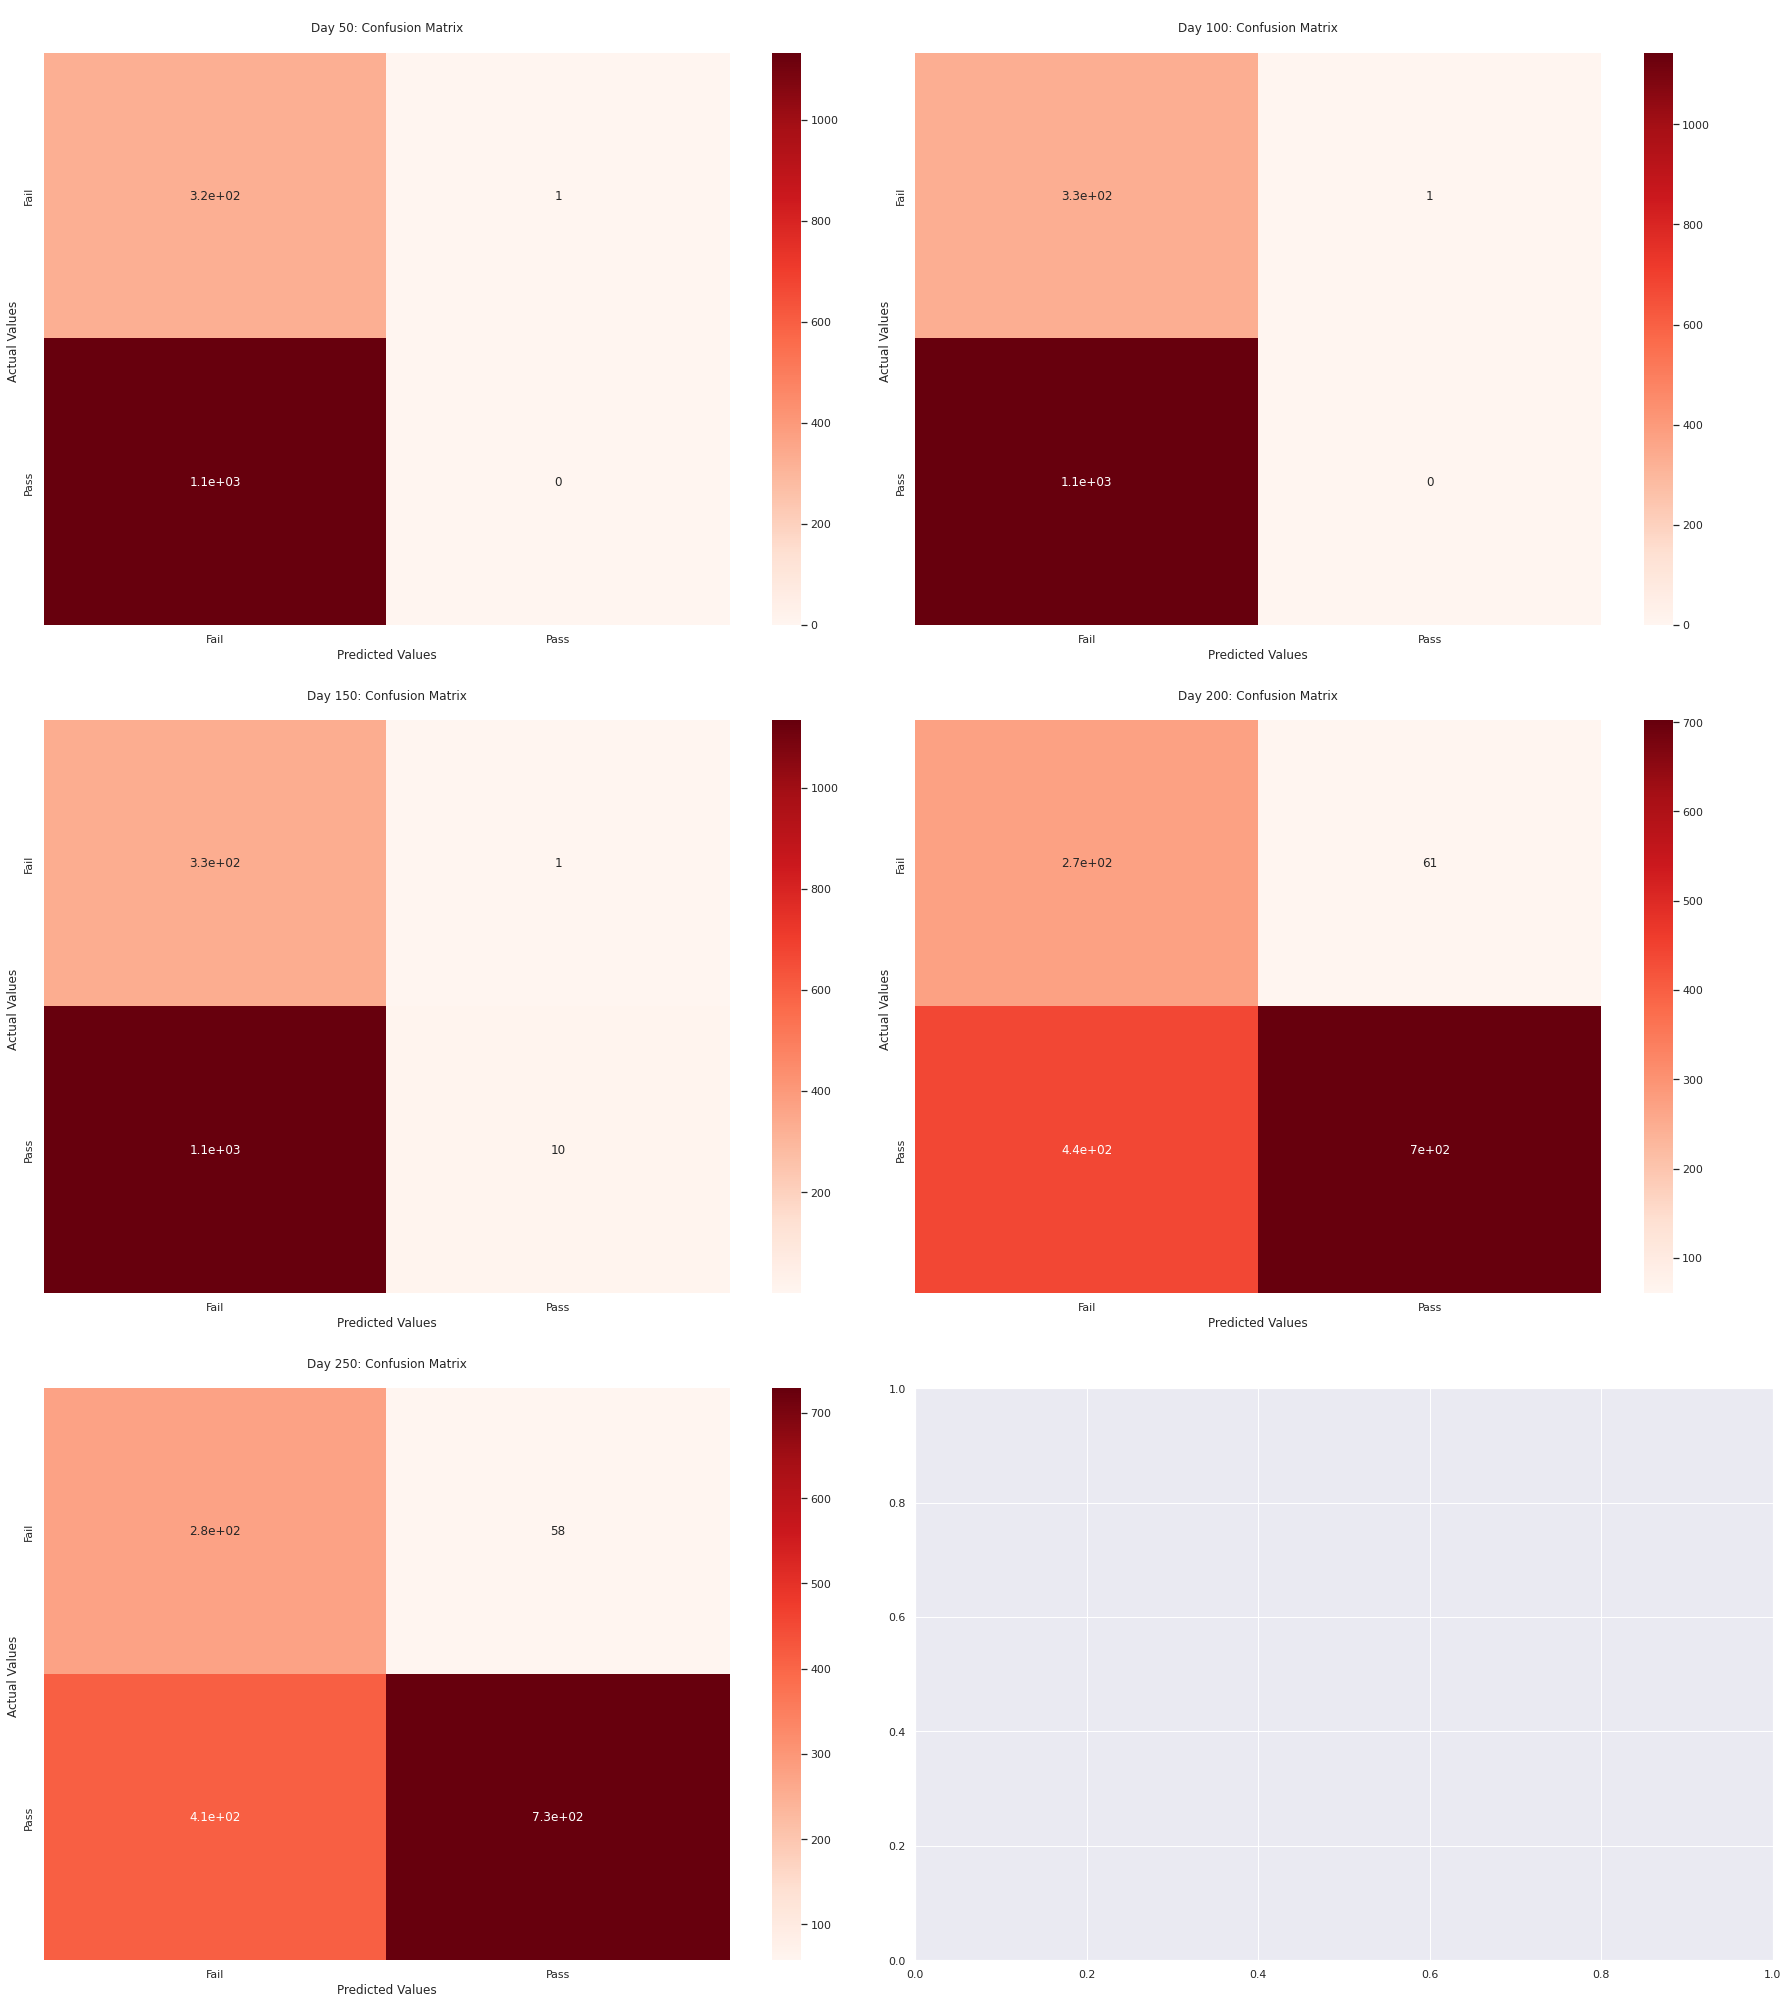

In [ ]:
plot_confusion_matrix(performance_results_rf)

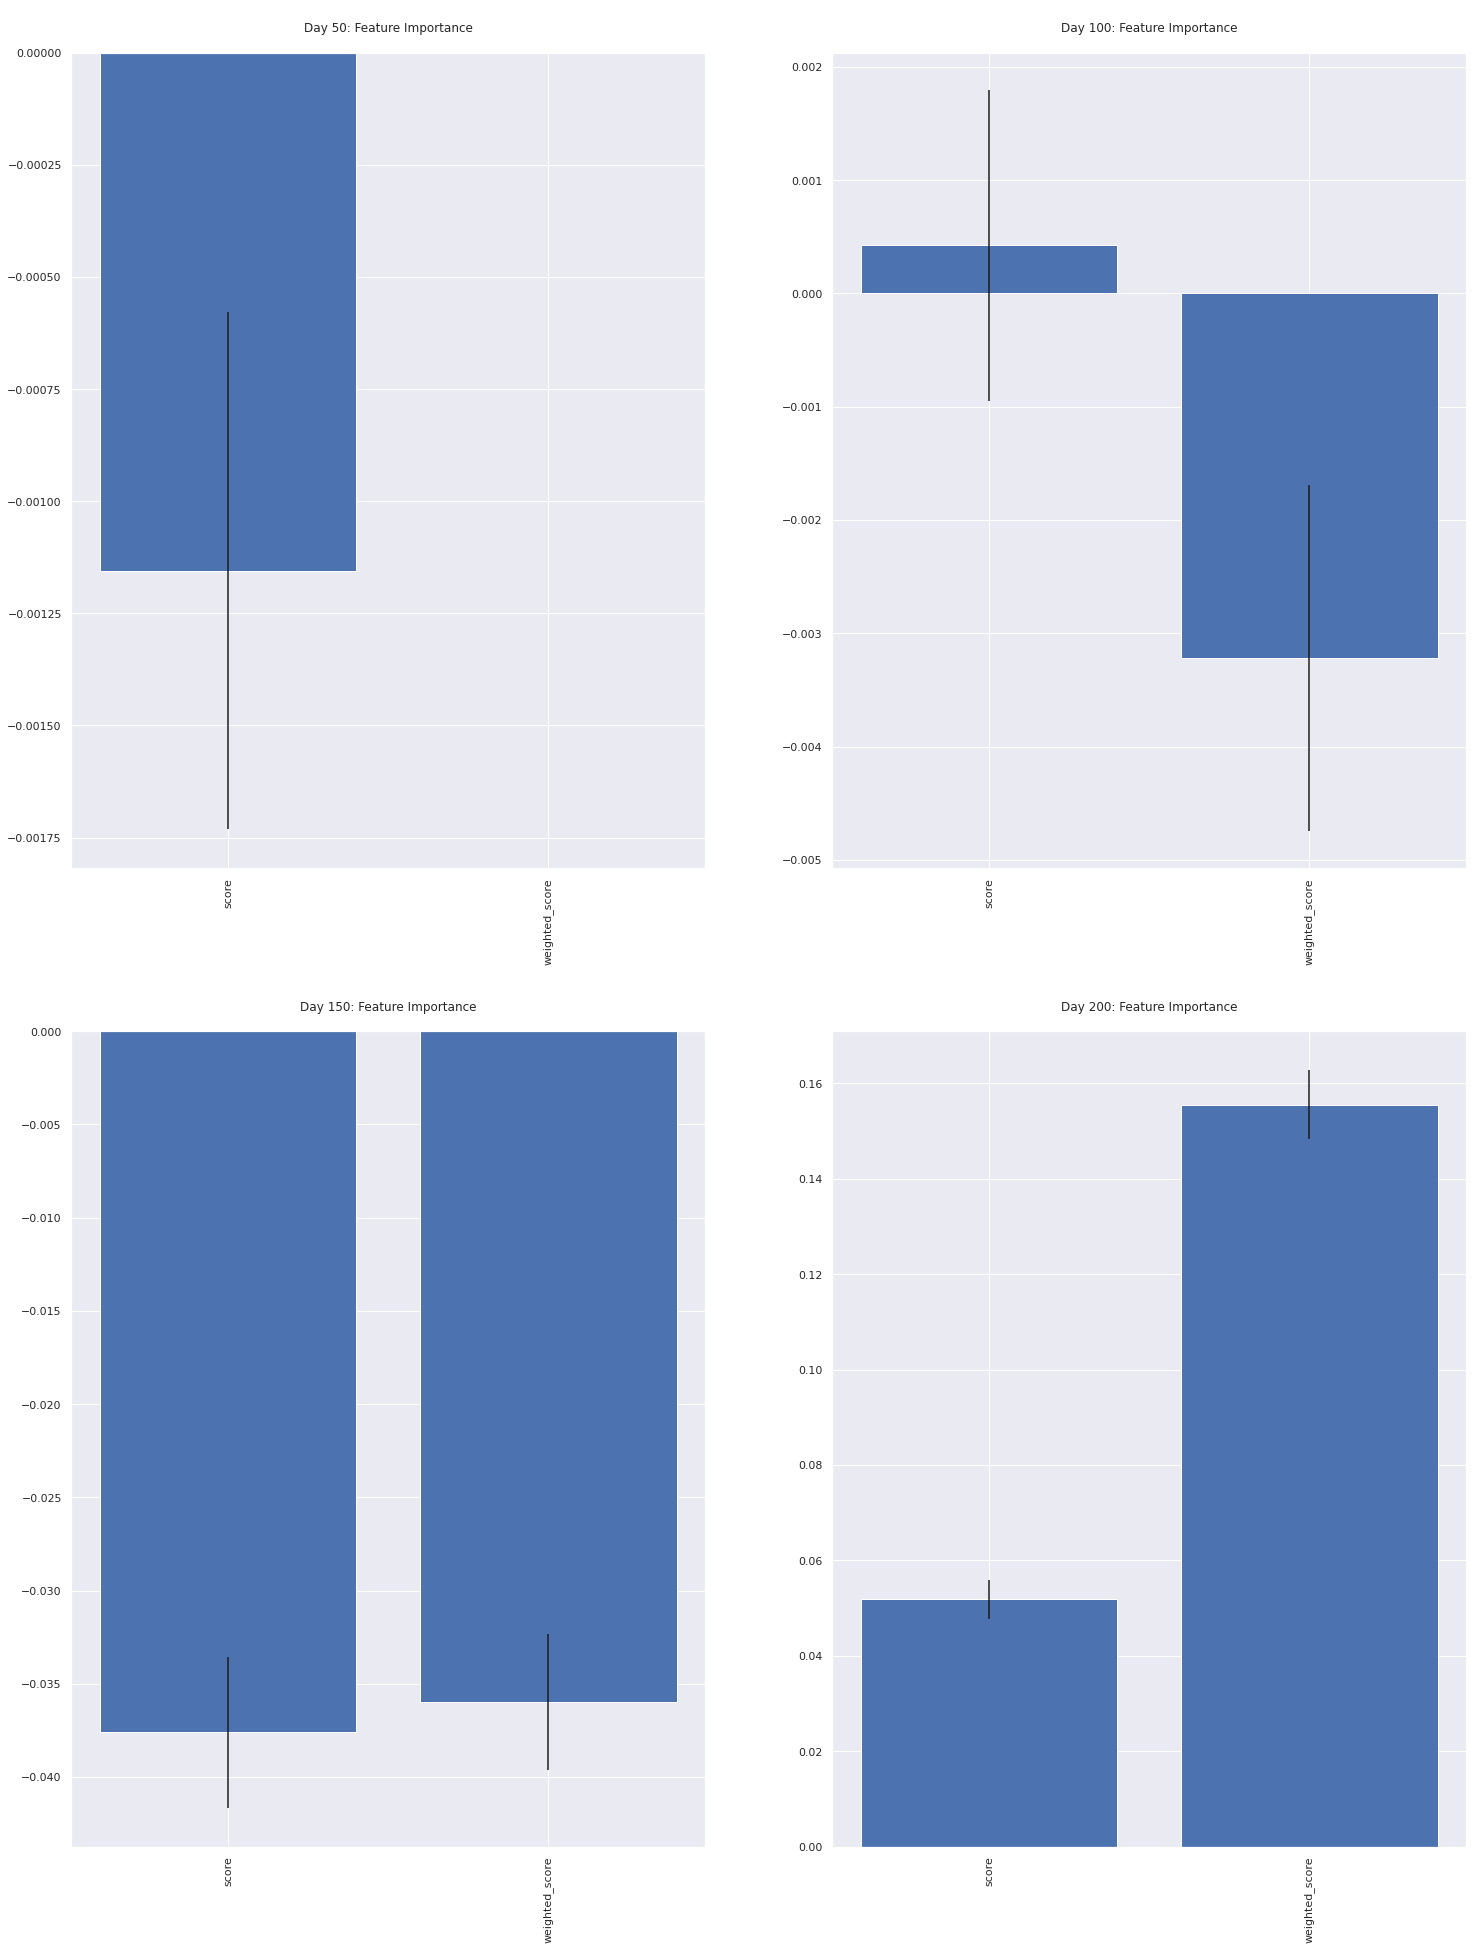

In [ ]:
plot_feature_importance(performance_features_rf)

##### AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

performance_results_ab = []
performance_features_ab = []

pipeline = Pipeline([
    ('clf', AdaBoostClassifier(random_state=RANDOM_SEED)),
])

params = {
  'clf__learning_rate':(0.5,0.85,1,1.25,1.5,1.75)
}

for i in list(df.keys())[1:]:
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  performance_results_ab.append([acc, f1, prec, recall, conf])
  performance_features_ab.append([tuned_model, X_test[i], Y_test[i]])
  print("\n")

Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.665
Best parameters set:
	clf__learning_rate: 1.25
Accuracy: 0.5624142661179699, F1 Score: 0.6822709163346614, Precision: 0.7828571428571428, Recall: 0.6045895851721095


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.780
Best parameters set:
	clf__learning_rate: 0.5
Accuracy: 0.20257452574525744, F1 Score: 0.01506276150627615, Precision: 0.17307692307692307, Recall: 0.007874015748031496


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.803
Best parameters set:
	clf__learning_rate: 0.5
Accuracy: 0.25253893026

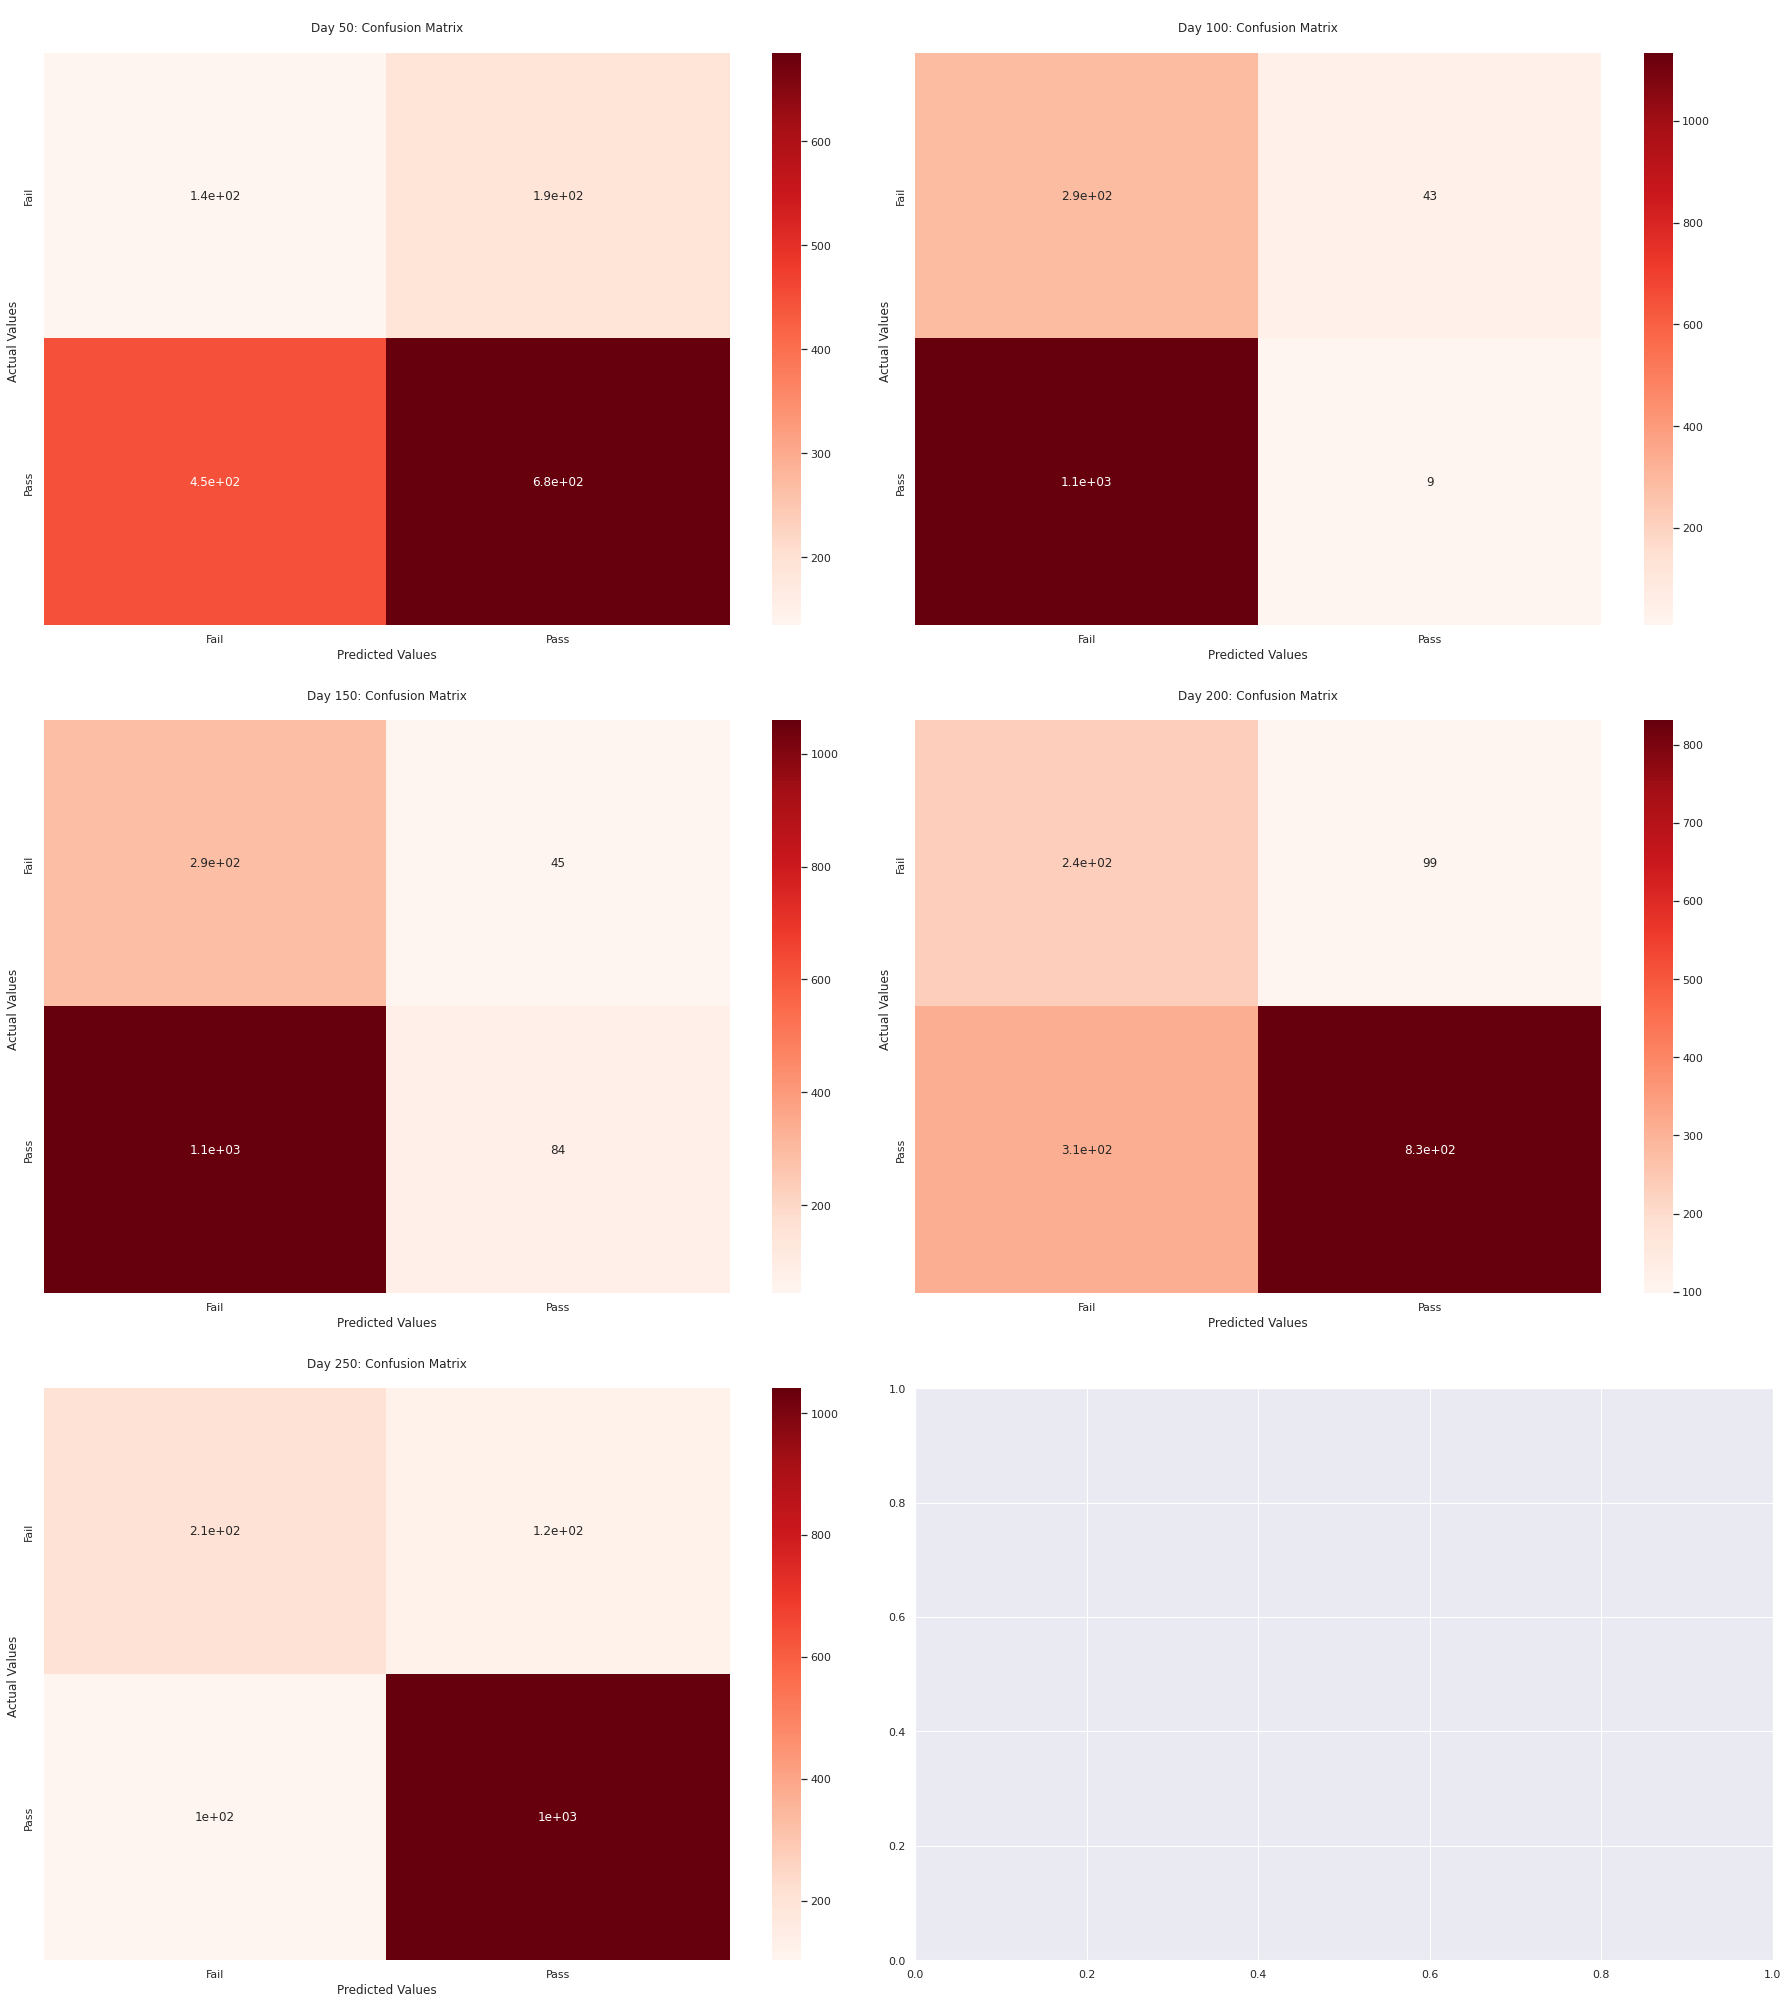

In [ ]:
plot_confusion_matrix(performance_results_ab)

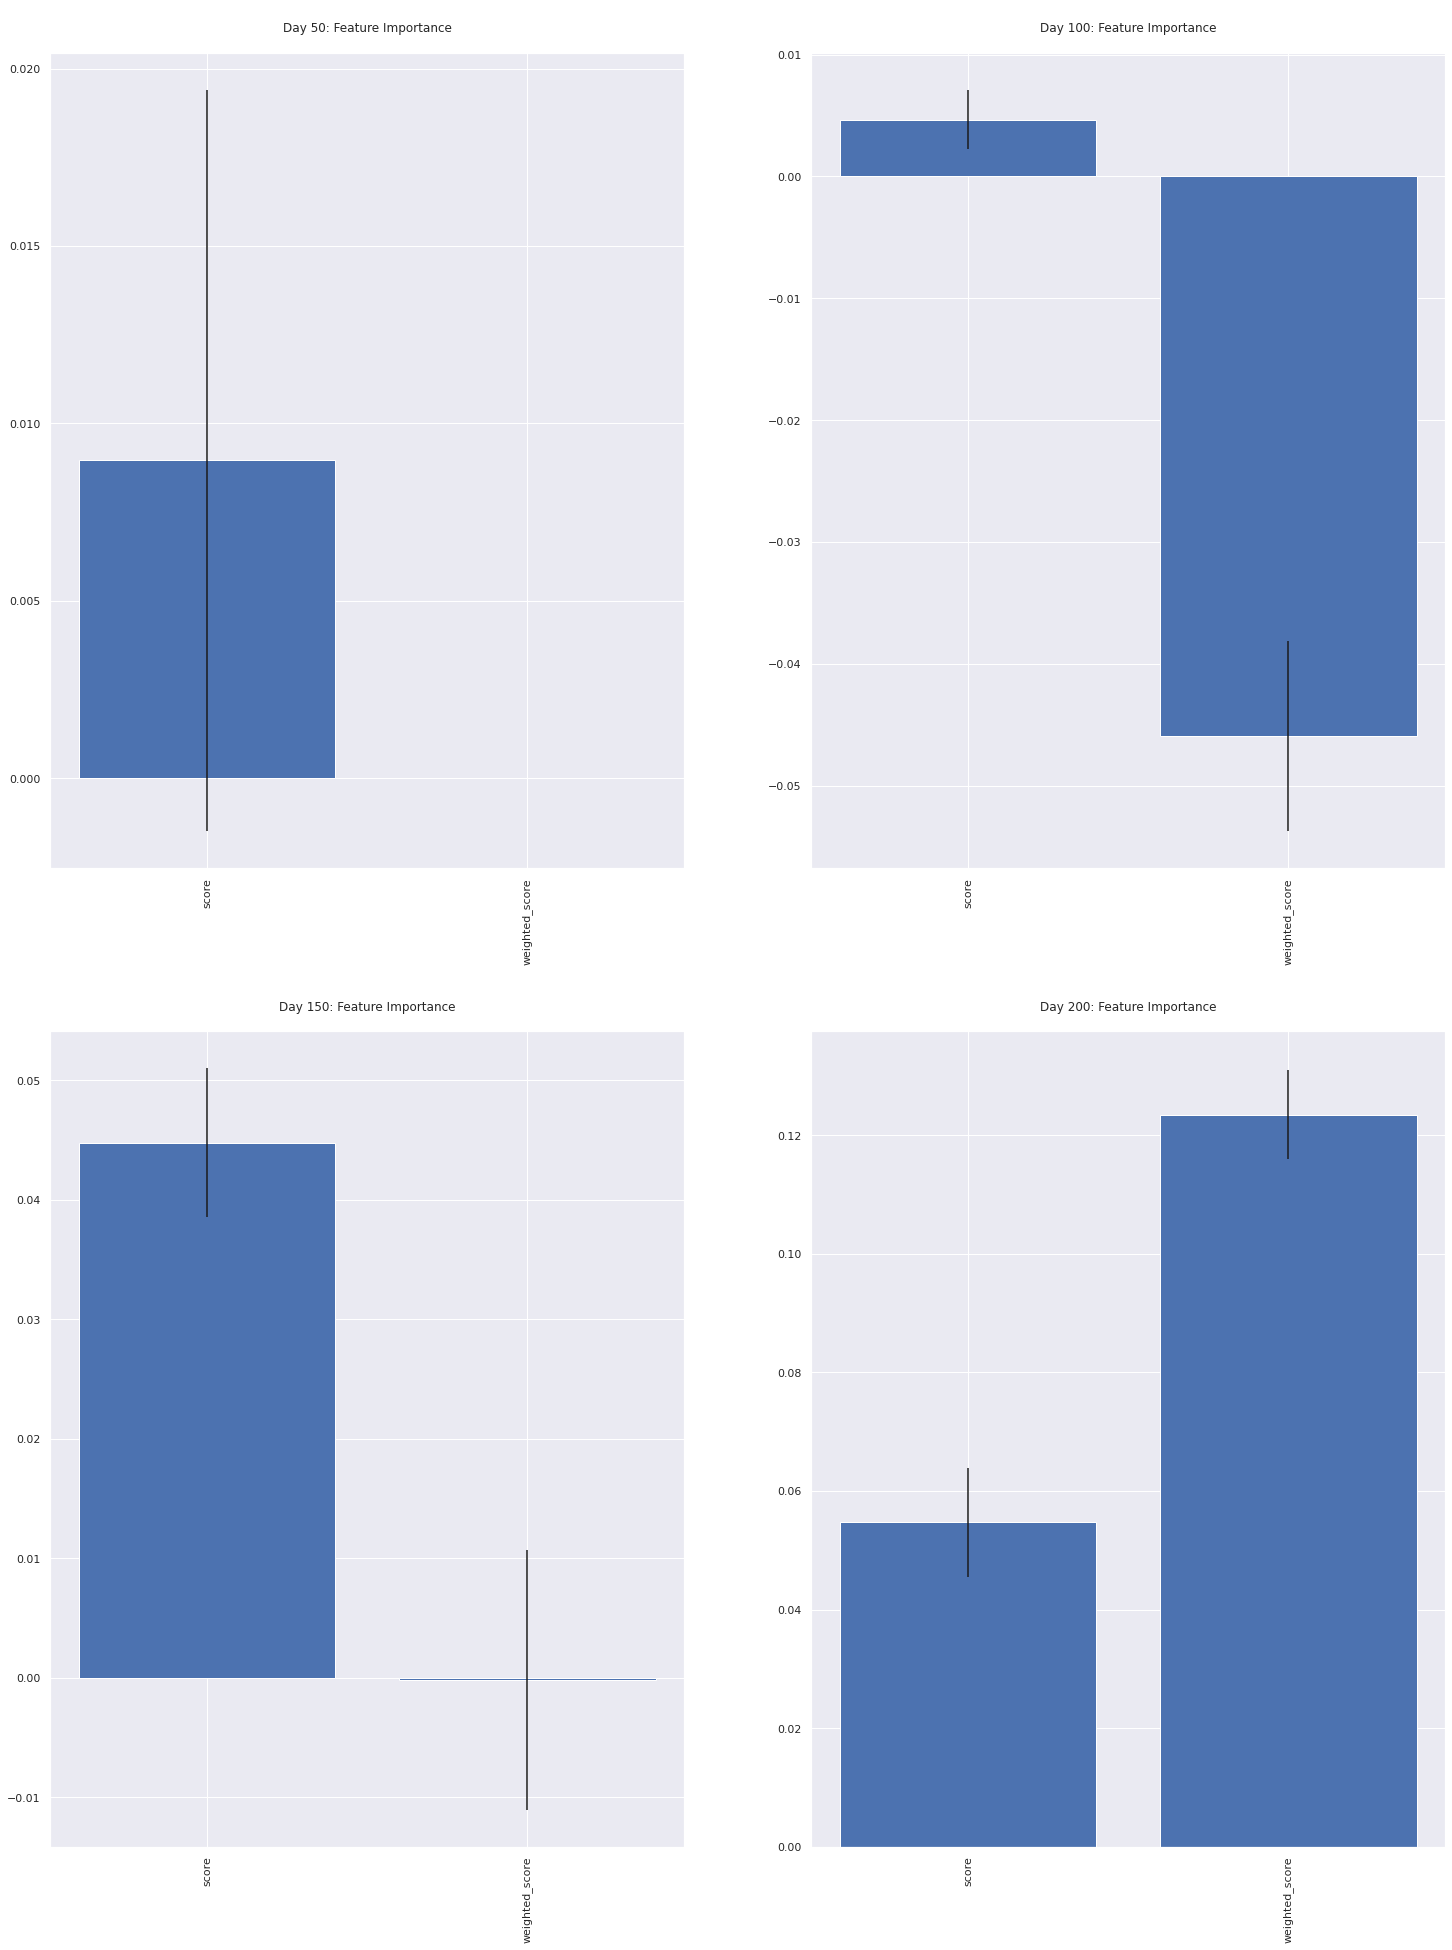

In [ ]:
plot_feature_importance(performance_features_ab)

##### Plot results overview

In [ ]:
performance_classifier_results = [performance_results_du, performance_results_nb, performance_results_lr, performance_results_lrw, performance_results_rf, performance_results_ab]
performance_classifier_labels = ["Dummy Classifier", "Naive Bayes", "Logistic Regression", "Logistic Regression Weighted", "Random Forest", "AdaBoost"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-

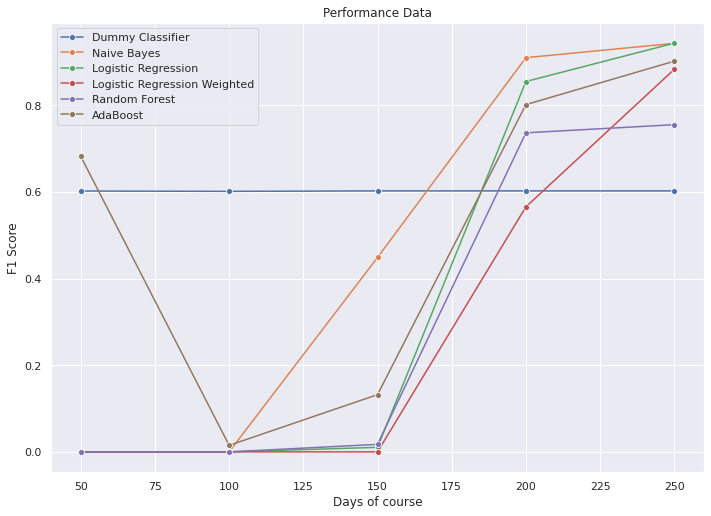

In [ ]:
plot_days_compare(deadline_list[1:],performance_classifier_results,performance_classifier_labels, "Performance Data")

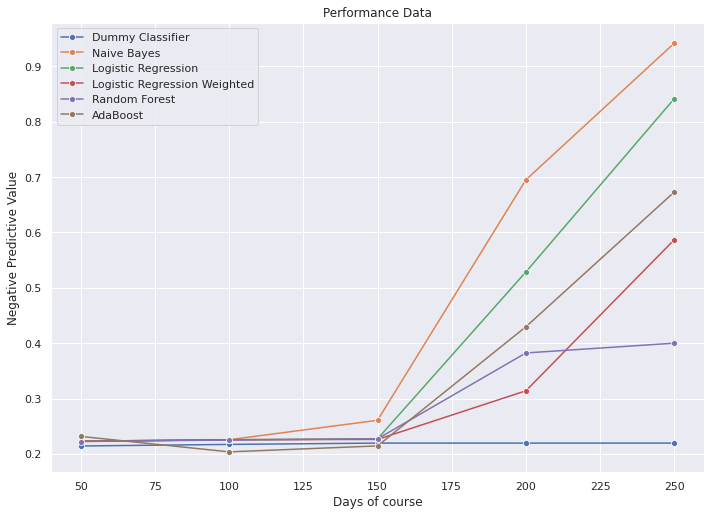

In [ ]:
plot_days_compare_npv(deadline_list[1:],performance_classifier_results,performance_classifier_labels, "Performance Data")

#### All data (Demographic, Learning Behaviour, Performance)

- Demographic and learning behaviour used throughout classifier
- Performance added for the last two predictions (200, 250) days

##### Prepare data for prediction

In [ ]:
all_df = {}
for i in df.keys():
  all_df[i] = split_dataframe_by_data_type(df[i], ['demographic','learning_behaviour', 'performance'], include_final_result=True)

In [ ]:
all_df[50]

code_presentation  id_student gender  ...  score weighted_score final_result
0                2013B       23629      F  ...   65.0         14.820            0
1                2013B       25107      F  ...   59.5         13.869            1
2                2013B       29144      M  ...   57.5         13.015            0
3                2013B       31663      M  ...   84.0         18.968            1
4                2013B       34229      F  ...   78.0         18.746            1
...                ...         ...    ...  ...    ...            ...          ...
5079             2014J     2688945      F  ...  100.0          0.100            1
5080             2014J     2692969      F  ...  100.0          0.100            1
5081             2014J     2694919      F  ...  100.0          0.100            1
5082             2014J     2698577      F  ...  100.0          0.100            0
5083             2014J     2698588      F  ...  100.0          0.100            1

[5084 rows x 23 columns]

In [ ]:
for i in list(df)[1:-2]:
  all_df[i] = all_df[i].drop(columns=["score","weighted_score"])

for i in list(df)[-2:]:
  all_df[i] = all_df[i].drop(columns=["score"])

In [ ]:
all_df[250]

code_presentation  id_student  ... weighted_score final_result
0                2013B       23629  ...         17.020            0
1                2013B       25107  ...         61.361            1
2                2013B       29144  ...         53.679            0
3                2013B       31663  ...         64.792            1
4                2013B       34229  ...         65.862            1
...                ...         ...  ...            ...          ...
5130             2014J     2688945  ...         68.272            1
5131             2014J     2692969  ...         70.135            1
5132             2014J     2694919  ...         66.767            1
5133             2014J     2698577  ...         56.122            0
5134             2014J     2698588  ...         92.862            1

[5135 rows x 23 columns]

###### Encode data

In [ ]:
X_train, X_test, Y_train, Y_test = encode_data(all_df, ["2013J"], "2014J")

Index(['gender', 'region', 'highest_education', 'imd_band', 'age_band',
       'disability'],
      dtype='object') Index(['quiz', 'resource', 'glossary', 'mean_click', 'homepage',
       'sharedsubpage', 'subpage', 'url', 'oucontent', 'forumng'],
      dtype='object')
Index(['gender', 'region', 'highest_education', 'imd_band', 'age_band',
       'disability'],
      dtype='object') Index(['quiz', 'resource', 'glossary', 'mean_click', 'homepage',
       'sharedsubpage', 'subpage', 'oucollaborate', 'url', 'oucontent',
       'forumng'],
      dtype='object')
Index(['gender', 'region', 'highest_education', 'imd_band', 'age_band',
       'disability'],
      dtype='object') Index(['quiz', 'resource', 'glossary', 'mean_click', 'homepage',
       'sharedsubpage', 'subpage', 'oucollaborate', 'url', 'oucontent',
       'forumng'],
      dtype='object')
Index(['gender', 'region', 'highest_education', 'imd_band', 'age_band',
       'disability'],
      dtype='object') Index(['quiz', 'resource',

In [ ]:
X_train[50]

gender_F  gender_M  ...  oucontent   forumng
1126       0.0       1.0  ...   0.147287  0.132771
1127       0.0       1.0  ...   0.034884  0.081868
1128       1.0       0.0  ...   0.116279  0.360825
1129       1.0       0.0  ...   0.034884  0.194023
1130       1.0       0.0  ...   0.093023  0.270619
...        ...       ...  ...        ...       ...
2588       1.0       0.0  ...   0.000000  0.000000
2589       1.0       0.0  ...   0.046512  0.152104
2590       1.0       0.0  ...   0.302326  0.143184
2591       1.0       0.0  ...   0.046512  0.144330
2592       1.0       0.0  ...   0.000000  0.103093

[1467 rows x 46 columns]

###### Undersampling

In [ ]:
Y_train[50].value_counts()

1    1053
0     414
Name: final_result, dtype: int64

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

from collections import Counter

X_train_sample, Y_train_sample = {},{}

for i in df.keys():

  sampler = TomekLinks() # fit predictor and target variable
  X_train_sample[i], Y_train_sample[i] = sampler.fit_resample(X_train[i], Y_train[i])

  print(f"Sampling for day {i}")
  print('Original dataset shape:', Counter(Y_train[i]))
  print('Resample dataset shape', Counter(Y_train_sample[i]))

Sampling for day 0
Original dataset shape: Counter({1: 841, 0: 303})
Resample dataset shape Counter({1: 727, 0: 303})
Sampling for day 50
Original dataset shape: Counter({1: 1053, 0: 414})
Resample dataset shape Counter({1: 912, 0: 414})
Sampling for day 100
Original dataset shape: Counter({1: 1060, 0: 417})
Resample dataset shape Counter({1: 915, 0: 417})
Sampling for day 150
Original dataset shape: Counter({1: 1063, 0: 421})
Resample dataset shape Counter({1: 924, 0: 421})
Sampling for day 200
Original dataset shape: Counter({1: 1063, 0: 421})
Resample dataset shape Counter({1: 963, 0: 421})
Sampling for day 250
Original dataset shape: Counter({1: 1064, 0: 421})
Resample dataset shape Counter({1: 969, 0: 421})


###### Reduce dimensions

In [ ]:
for i in df.keys():
  pca = PCA(n_components='mle')

  X_train[i] = pca.fit_transform(X_train[i], Y_train[i])                             
  
  X_test[i] = pca.transform(X_test[i])

In [ ]:
X_train[250].shape

(1485, 40)

###### Feature selection

In [ ]:
for i in df.keys():
  feature_selection_transformer = SelectKBest(score_func=f_classif, k=20)

  X_train[i] = pd.DataFrame(feature_selection_transformer.fit_transform(X_train[i], Y_train[i]))
  
  X_test[i] = pd.DataFrame(feature_selection_transformer.transform(X_test[i]))

In [ ]:
X_train[250]

0         1         2   ...        17        18        19
0     0.393452  1.283392  0.407258  ...  0.141241 -0.078973 -0.019295
1    -0.317902  1.365701 -0.873378  ...  0.635450  0.492560  0.009042
2     0.330033  0.066596 -1.043481  ... -0.225623 -0.157720  0.031312
3    -0.211183 -0.290352 -0.138709  ... -0.113924 -0.027959 -0.062913
4    -0.123153 -0.329296  1.138961  ... -0.072193  0.094053  0.059513
...        ...       ...       ...  ...       ...       ...       ...
1480  0.326868 -0.098016 -0.048561  ... -0.327421  0.372880 -0.141474
1481  0.500326 -0.389453  0.952237  ... -0.105497  0.081124  0.045718
1482 -0.928739 -0.032116 -0.814128  ...  0.070455 -0.215983 -0.115173
1483 -0.878884 -0.162784 -0.028750  ... -0.239623  0.005546 -0.083252
1484 -0.860914 -0.178426 -0.017400  ...  0.191368 -0.372139  0.313511

[1485 rows x 20 columns]

##### DummyClassifier

In [ ]:
from sklearn.dummy import DummyClassifier

all_results_du = []
all_features_du = []

pipeline = Pipeline([
    ('clf', DummyClassifier(strategy="uniform",random_state=RANDOM_SEED)),
])

params = {
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  all_results_du.append([acc, f1, prec, recall, conf])
  all_features_du.append([tuned_model, X_test[i], Y_test[i]])
  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.466
Best parameters set:
Accuracy: 0.48218940052128584, F1 Score: 0.5945578231292517, Precision: 0.76, Recall: 0.488268156424581


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.516
Best parameters set:
Accuracy: 0.49176954732510286, F1 Score: 0.6022544283413849, Precision: 0.7684931506849315, Recall: 0.49514563106796117


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.497
Best parameters set:
Accuracy: 0.491869918699187, F1 Score: 0.6014877789585547, Precision: 0.7658998646820027, Recall: 0.49518810148731407


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.481
Best parameters 

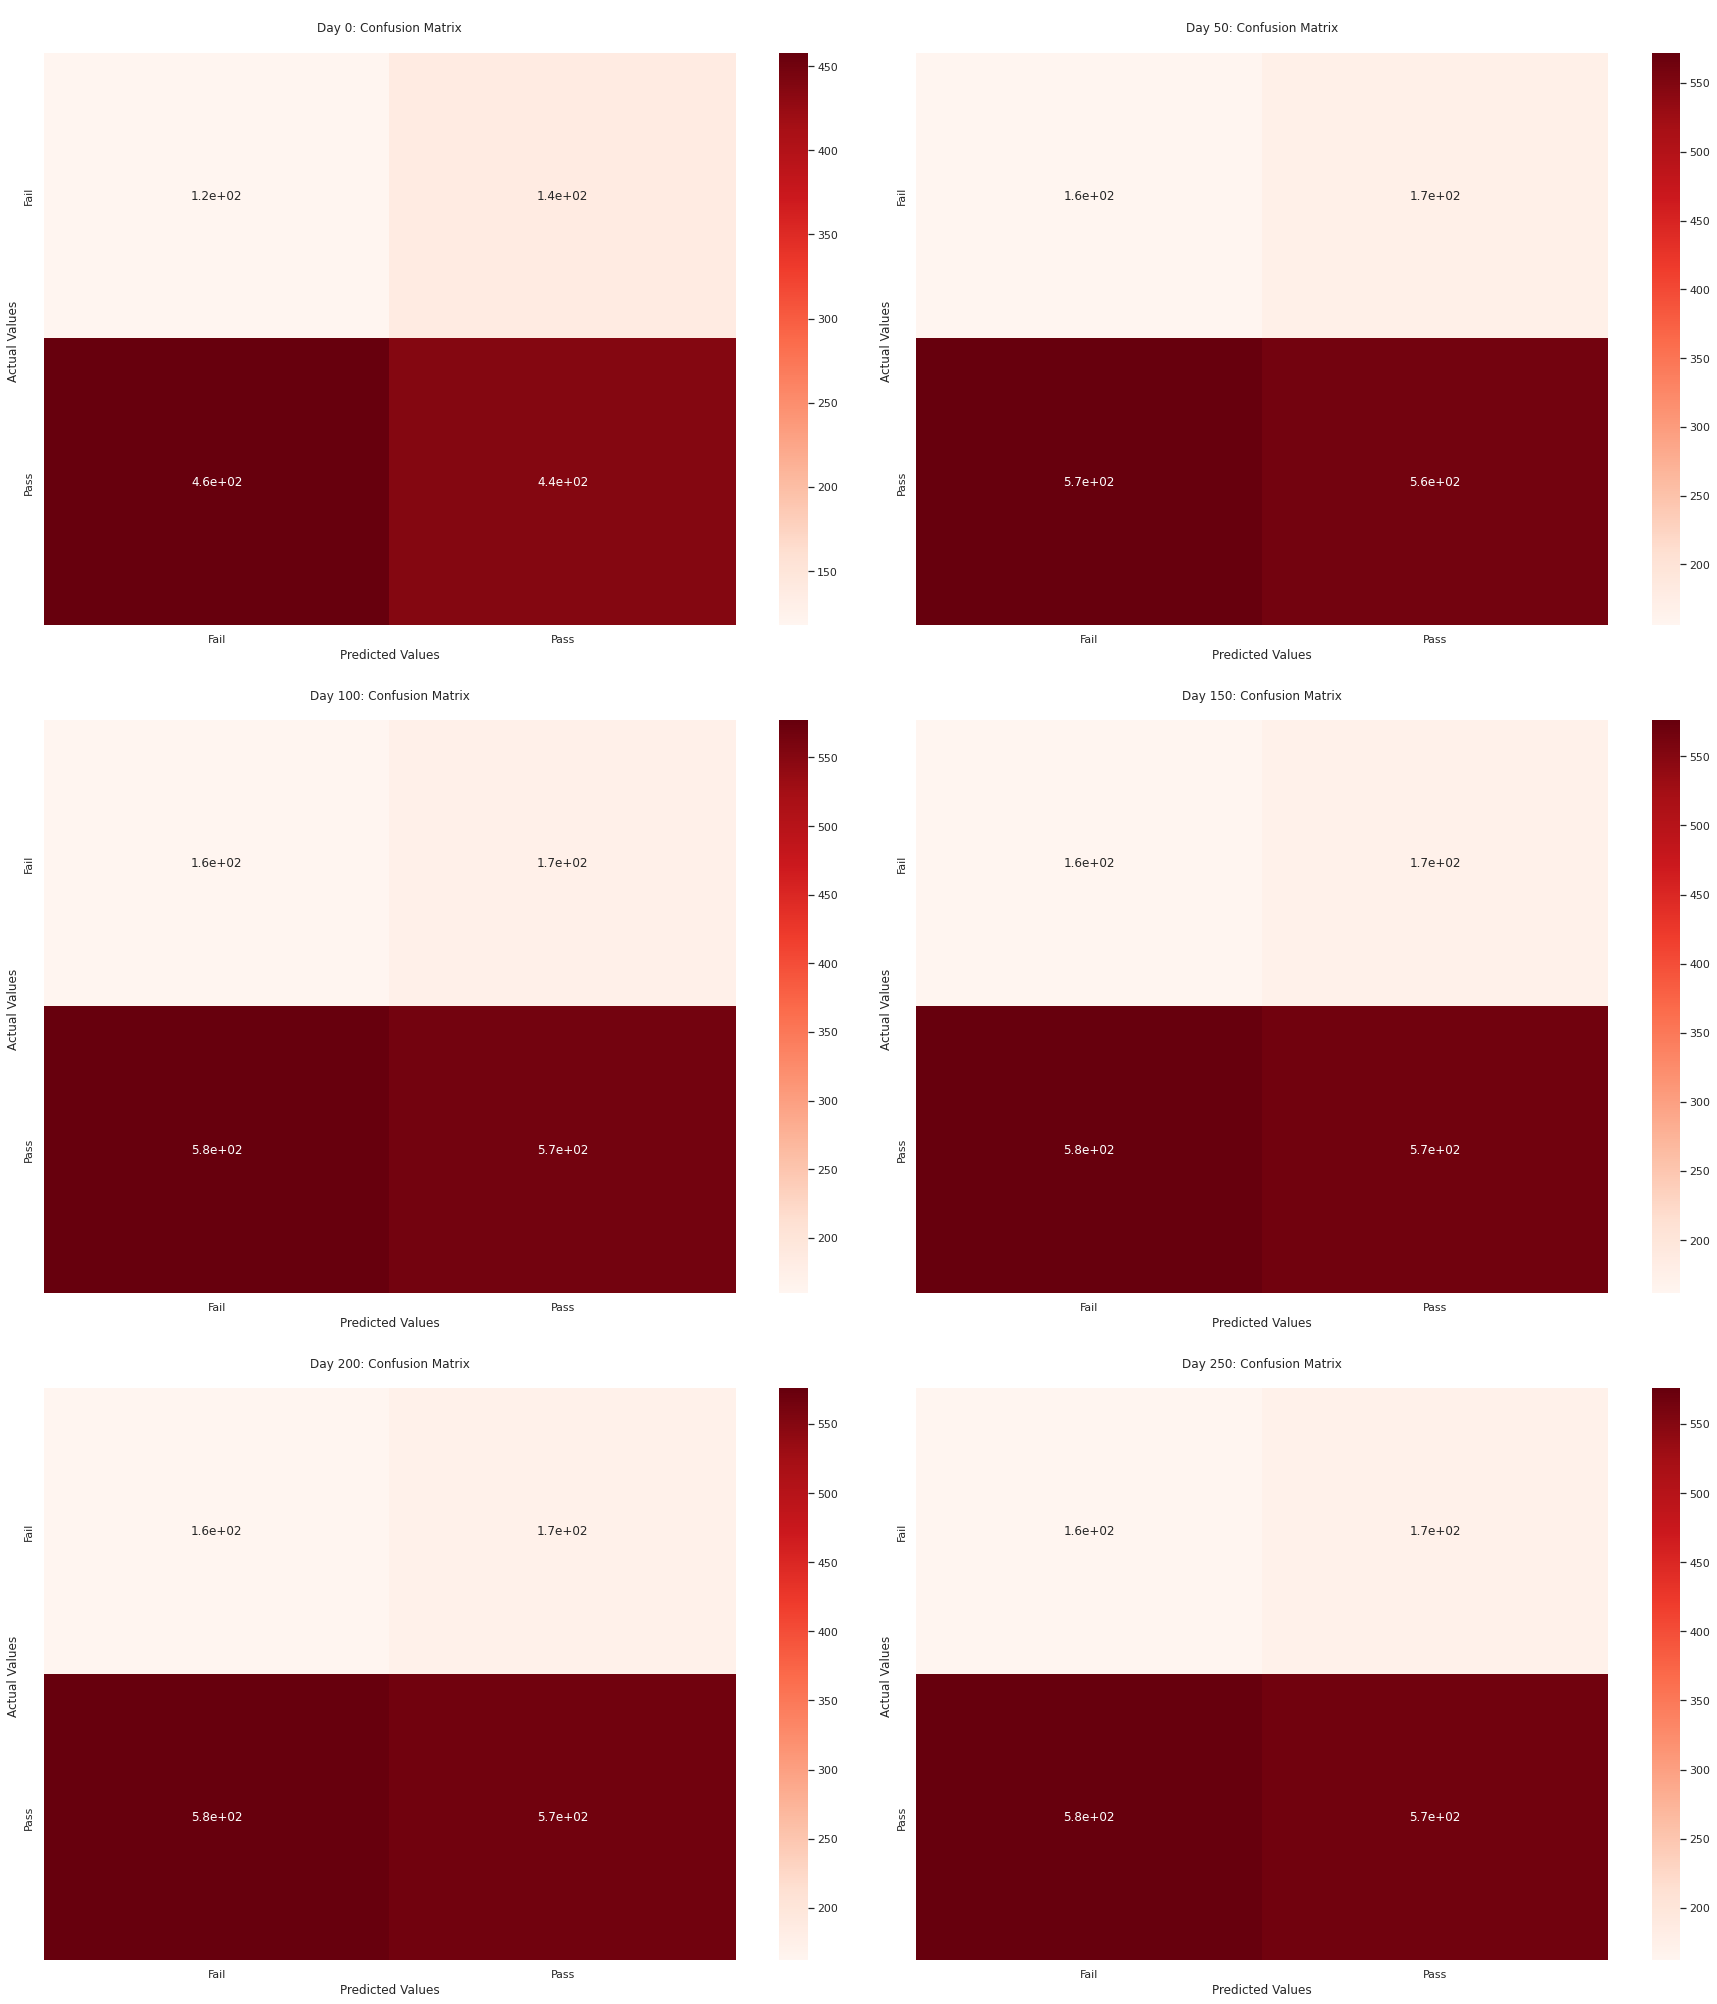

In [ ]:
plot_confusion_matrix(all_results_du)

##### NaiveBayes

In [ ]:
from sklearn.naive_bayes import GaussianNB,ComplementNB,BernoulliNB,MultinomialNB

all_results_nb = []

pipeline = Pipeline([
    ('clf', GaussianNB()),
])

params = {
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  all_results_nb.append([acc, f1, prec, recall, conf])

  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.583
Best parameters set:
Accuracy: 0.6959165942658557, F1 Score: 0.803811659192825, Precision: 0.8065241844769404, Recall: 0.8011173184357542


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.623
Best parameters set:
Accuracy: 0.6659807956104252, F1 Score: 0.7659778952426718, Precision: 0.8407172995780591, Recall: 0.703442188879082


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.656
Best parameters set:
Accuracy: 0.3258807588075881, F1 Score: 0.28673835125448033, Precision: 0.7936507936507936, Recall: 0.17497812773403323


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.654
Best

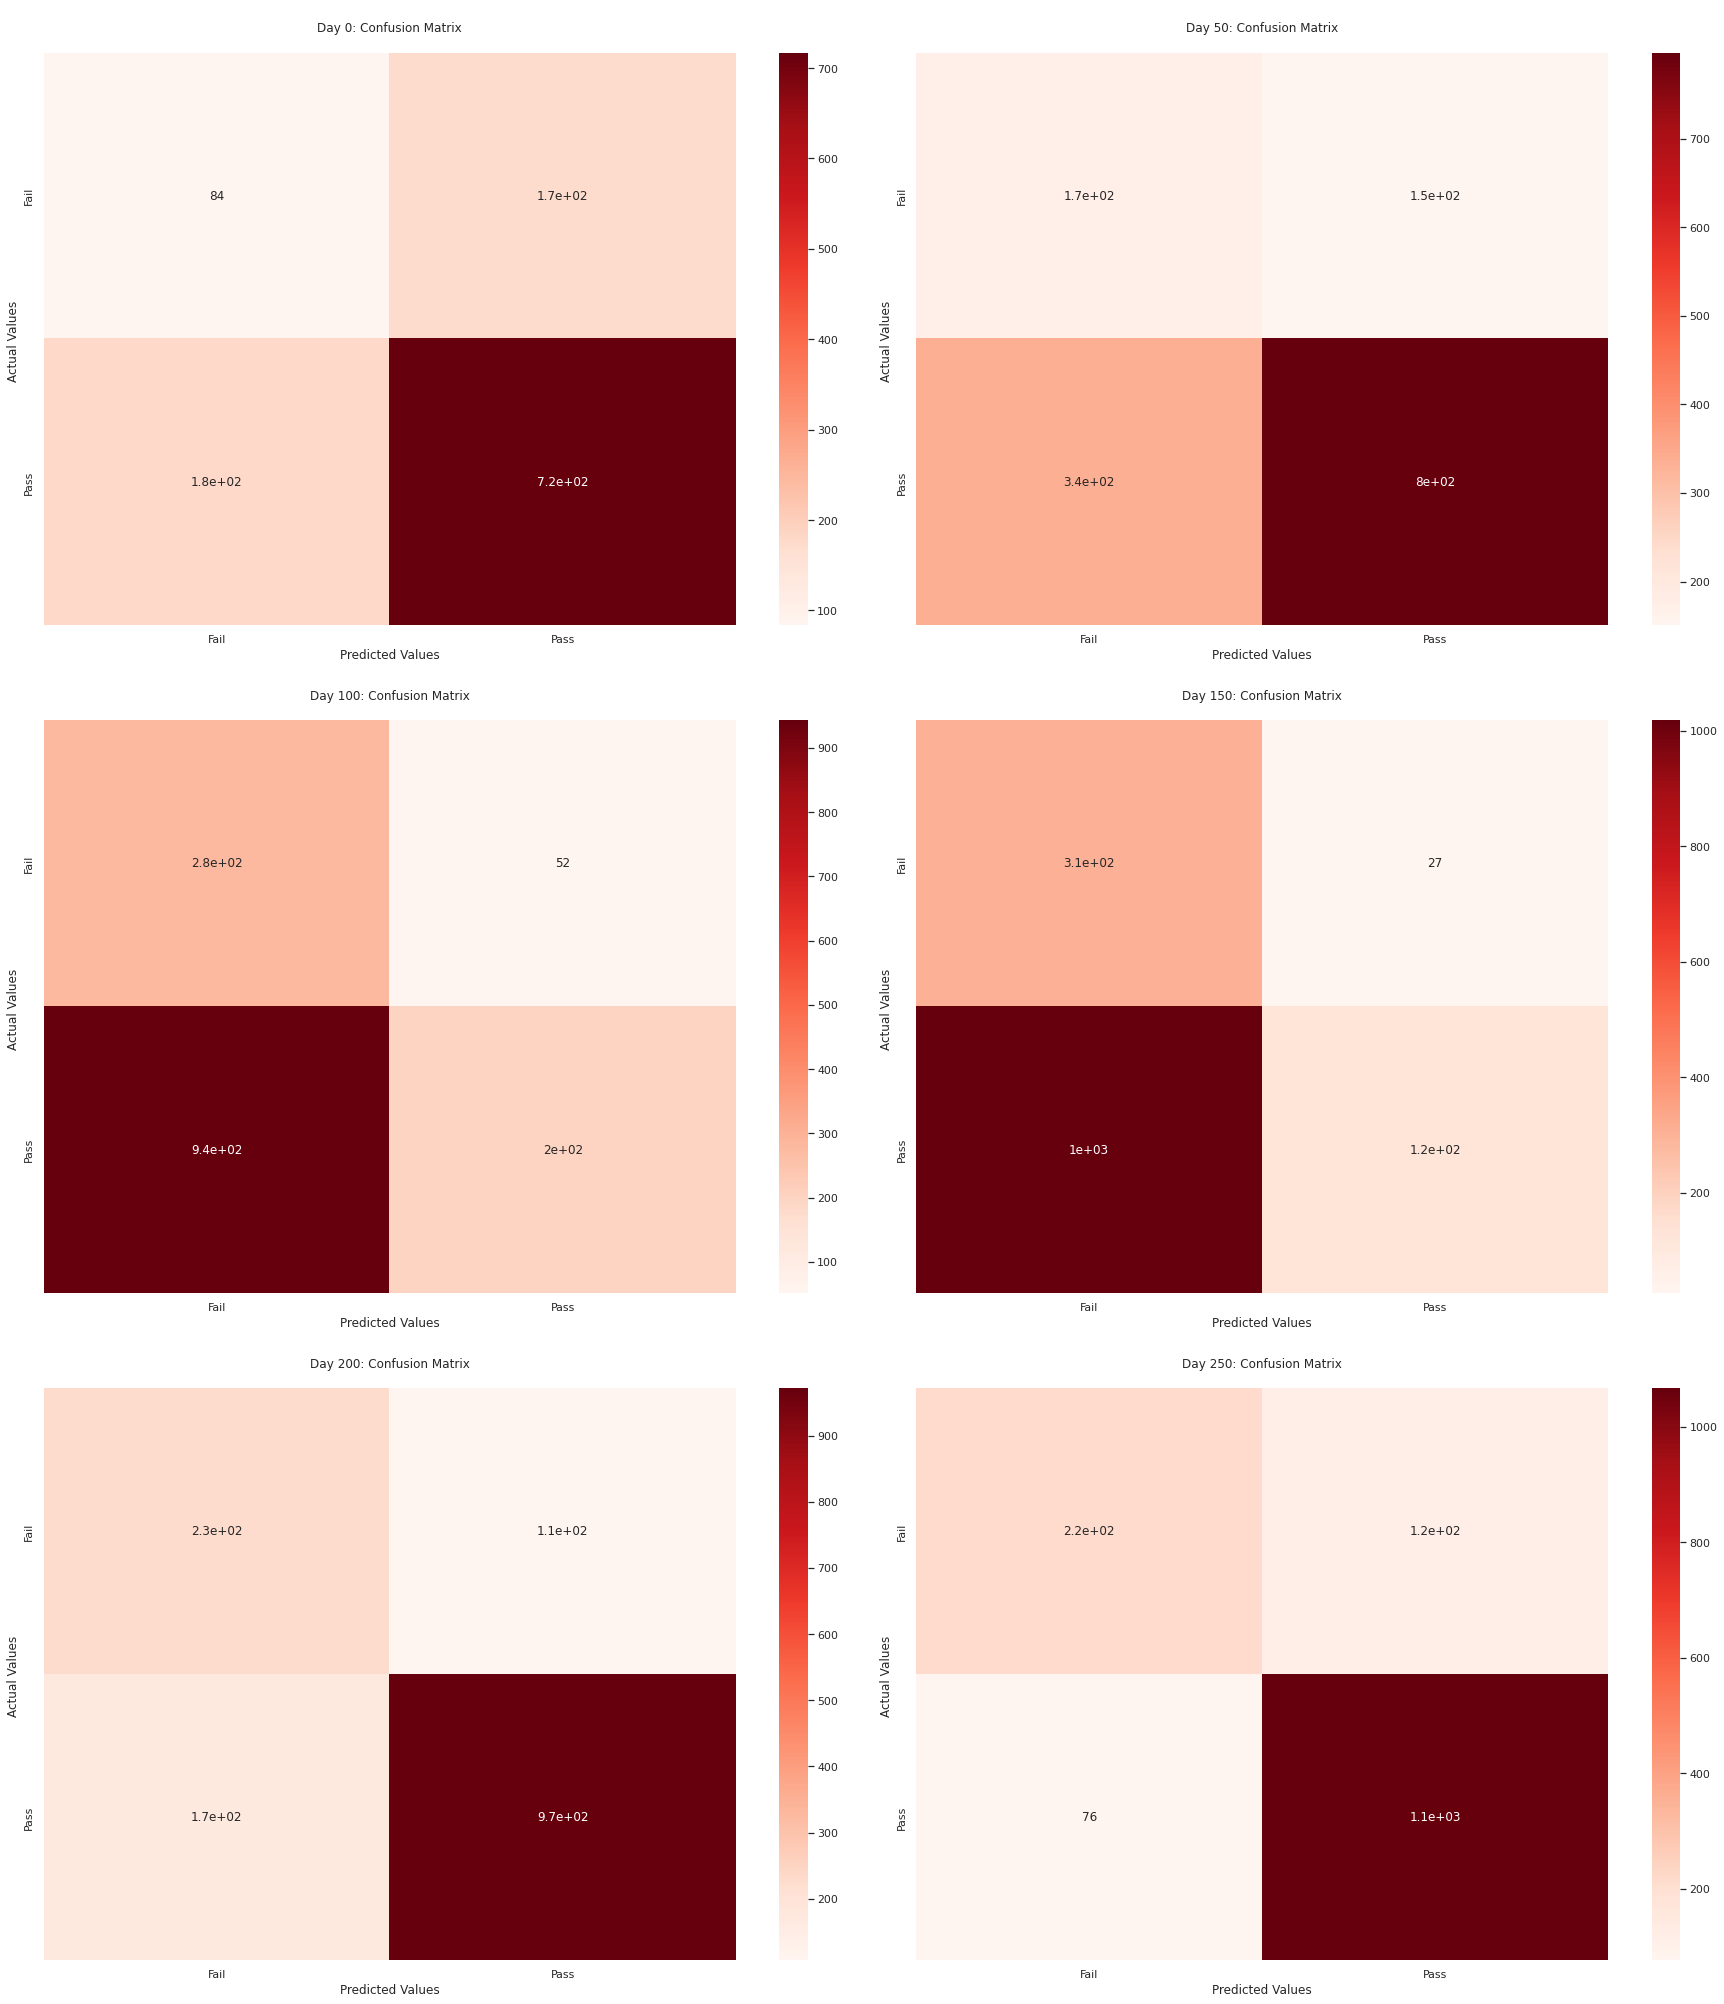

In [ ]:
plot_confusion_matrix(all_results_nb)

##### LogisticRegression

In [ ]:
from sklearn.linear_model import LogisticRegression

all_results_predict_proba_lr = []
all_results_predict_lr = []

all_results_lr = []

pipeline = Pipeline([
    ('clf', LogisticRegression(max_iter=1000)),
])

params = {
  'clf__penalty': ['l2', 'none']
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])
  predictions_proba = tuned_model.predict_proba(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  all_results_lr.append([acc, f1, prec, recall, conf])
  all_results_predict_proba_lr.append(predictions_proba)
  all_results_predict_lr.append(predictions)

  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.560
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.7593397046046916, F1 Score: 0.85489785227868, Precision: 0.8047337278106509, Recall: 0.911731843575419


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.608
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.7345679012345679, F1 Score: 0.8312254688181422, Precision: 0.821551724137931, Recall: 0.8411297440423654


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__penalty': ['l2', 'none']}
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best score: 0.633
Best parameters set:
	clf__penalty: 'none'
Accuracy: 0.7269647696476965, F1 Score: 0.8217602830605927, Precision: 0.830948121645796, Recall: 0.8127734033245845

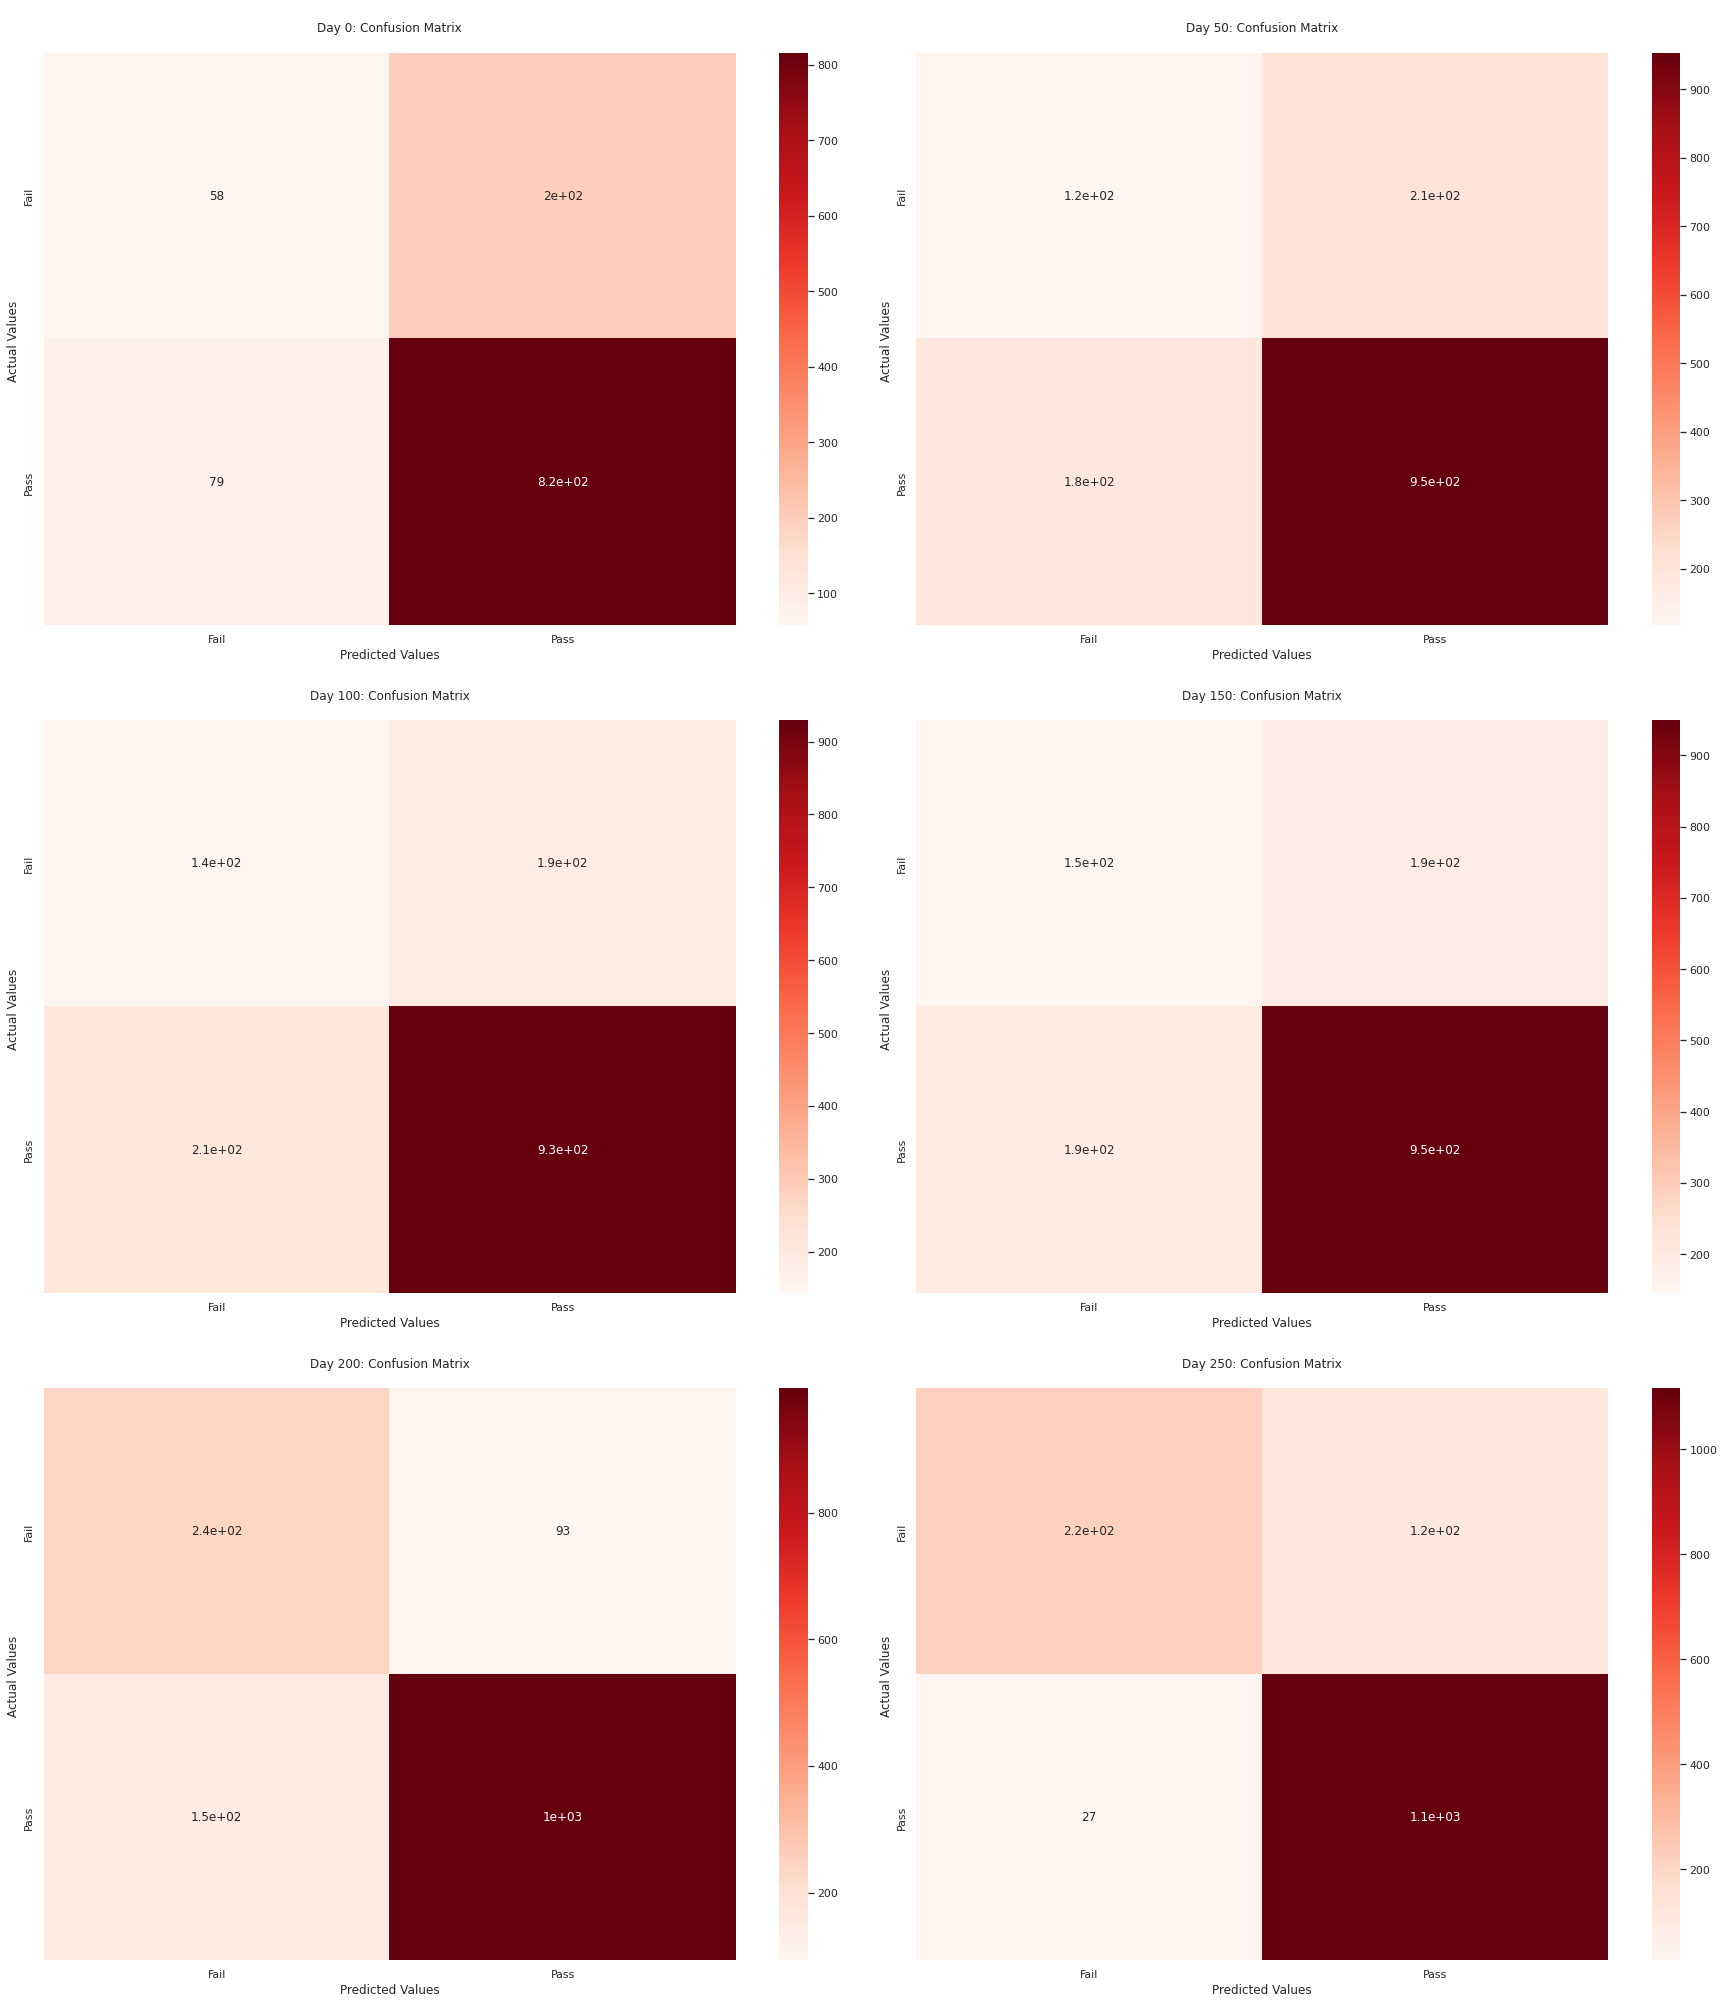

In [ ]:
plot_confusion_matrix(all_results_lr)

##### WeightedLogisticRegression

In [ ]:
all_results_lrw = []

pipeline = Pipeline([
    ('clf', LogisticRegression(max_iter=1000,class_weight = 'balanced')),
])

params = {
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  all_results_lrw.append([acc, f1, prec, recall, conf])
  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.600
Best parameters set:
Accuracy: 0.6116420503909644, F1 Score: 0.7045604758757436, Precision: 0.8624595469255664, Recall: 0.5955307262569832


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.627
Best parameters set:
Accuracy: 0.654320987654321, F1 Score: 0.753183153770813, Precision: 0.845984598459846, Recall: 0.678729037952339


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.642
Best parameters set:
Accuracy: 0.7073170731707317, F1 Score: 0.8016528925619835, Precision: 0.8434782608695652, Recall: 0.7637795275590551


Day 150
Performing grid search...
pipeline: ['clf']
parameters:
{}
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best score: 0.646
Best par

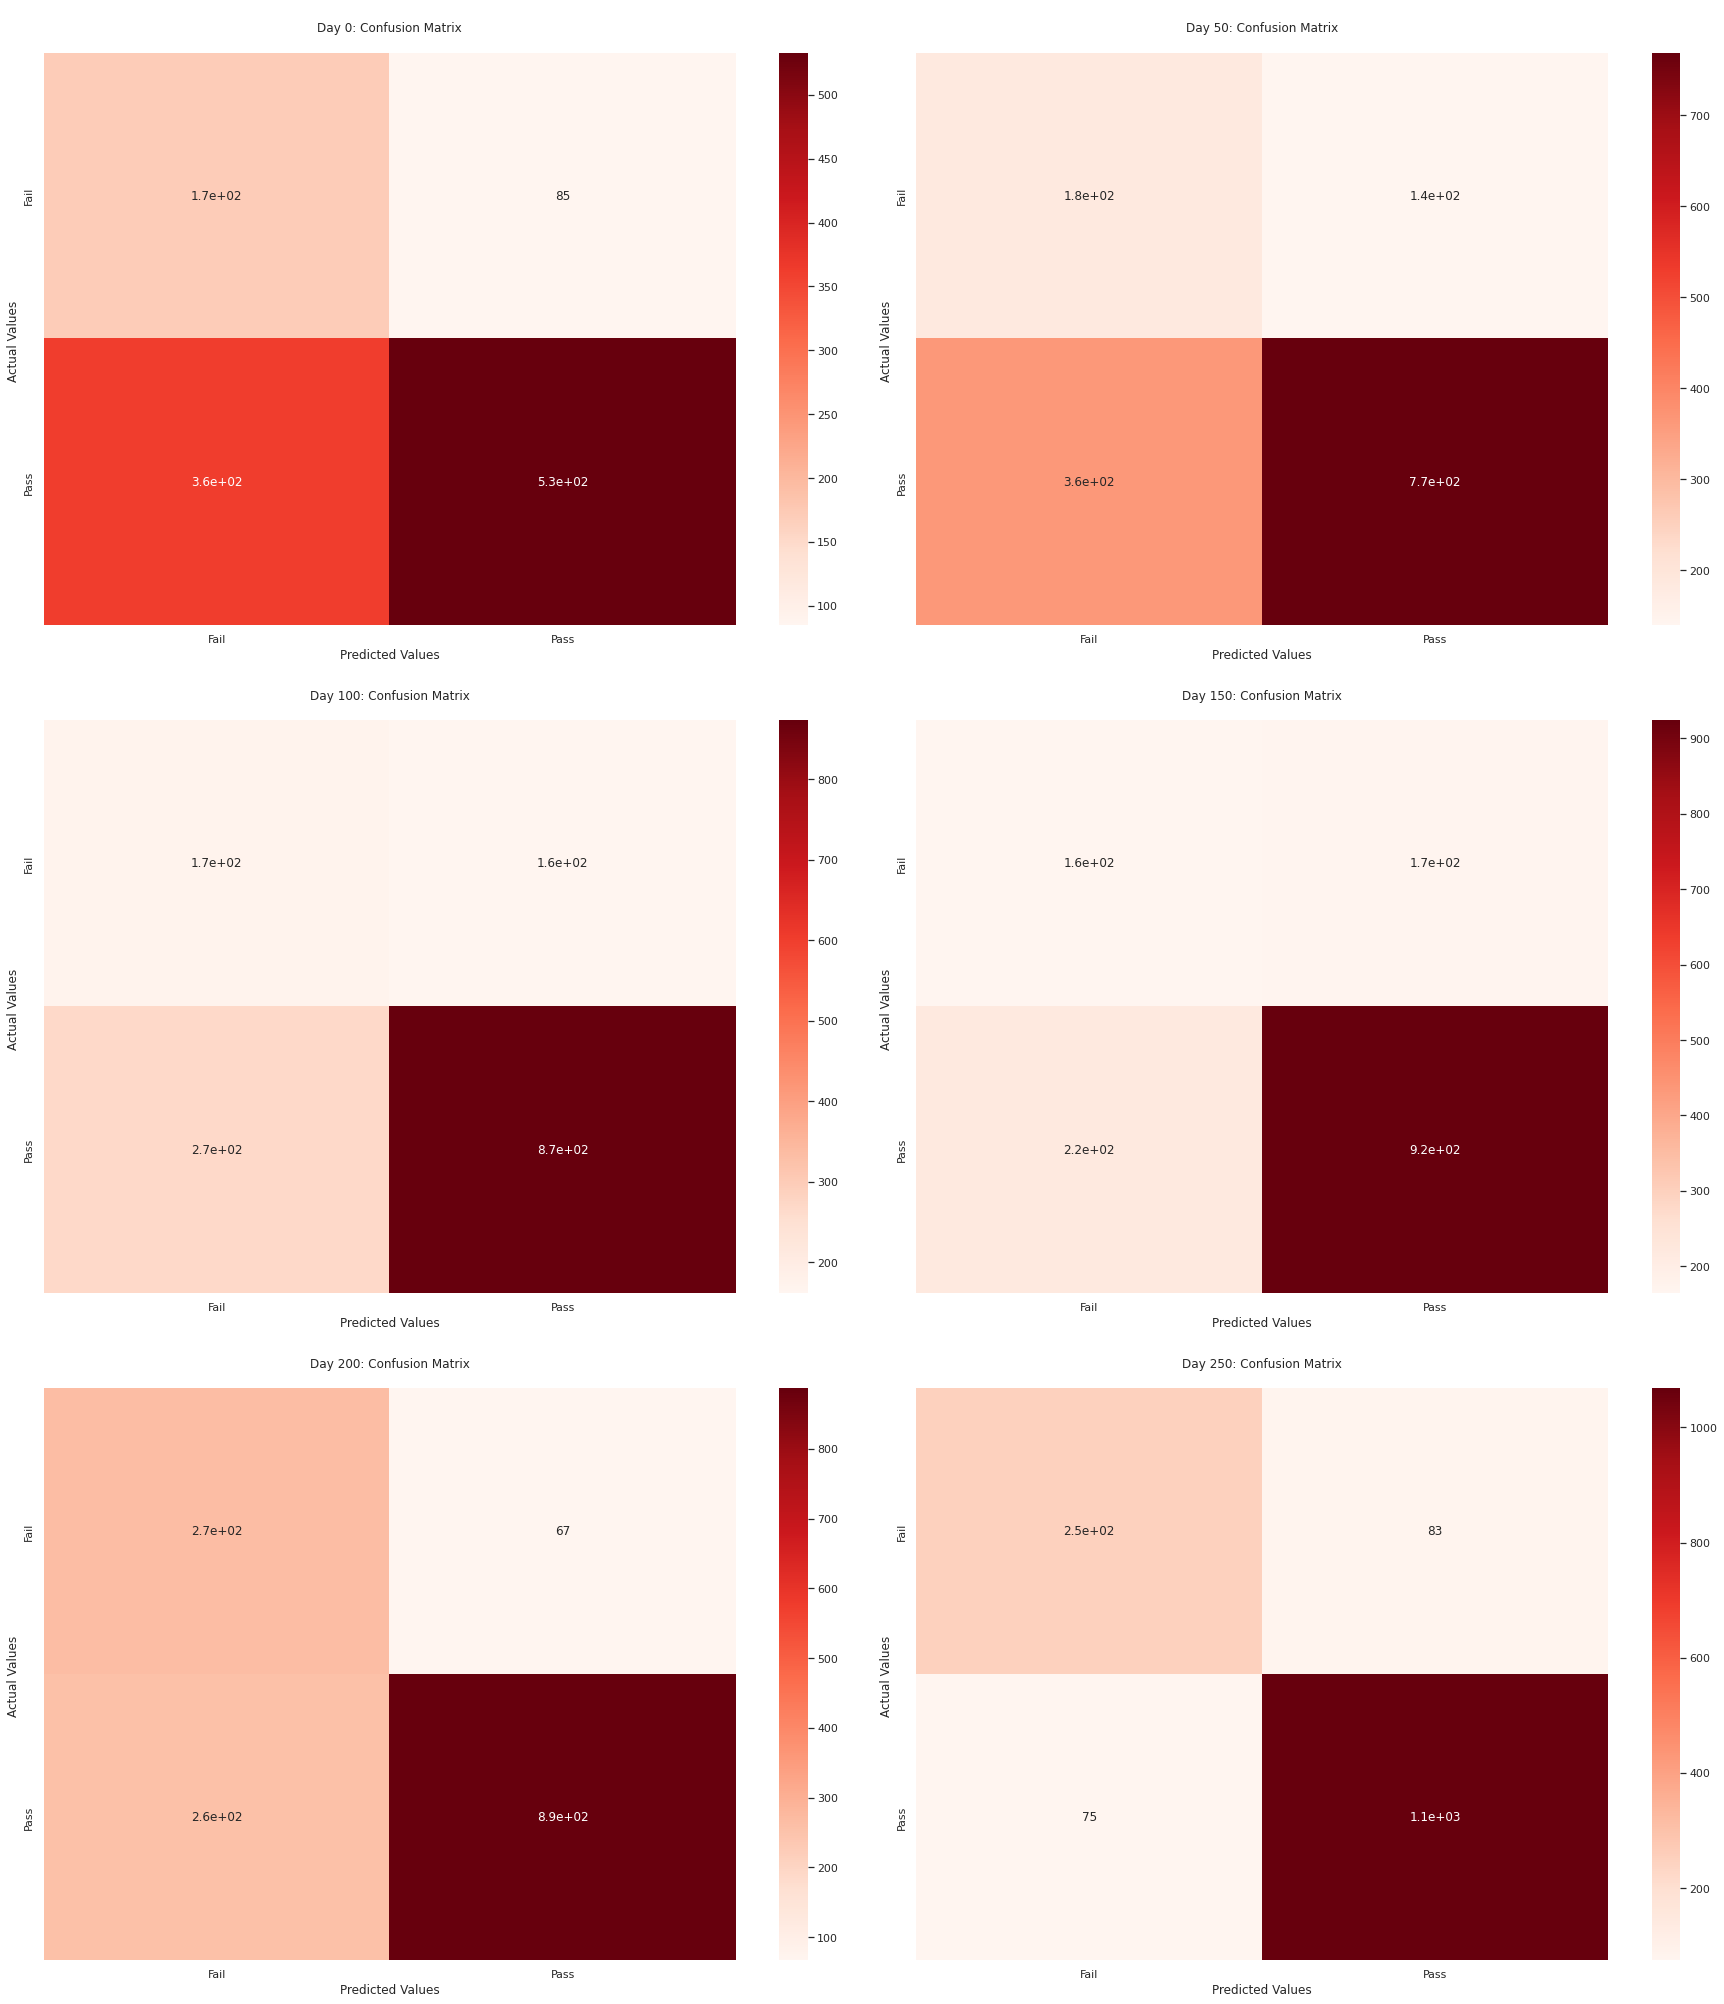

In [ ]:
plot_confusion_matrix(all_results_lrw)

##### RandomForest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

all_results_rf = []
all_results_predict_rf = []

pipeline = Pipeline([
    ('clf', RandomForestClassifier(random_state=RANDOM_SEED)),
])

params = {
  'clf__n_estimators': [x for x in range(50,150,10)]
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  all_results_rf.append([acc, f1, prec, recall, conf])
  all_results_predict_rf.append(predictions)

  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.566
Best parameters set:
	clf__n_estimators: 50
Accuracy: 0.7211120764552563, F1 Score: 0.8287999999999999, Precision: 0.7928571428571428, Recall: 0.8681564245810056


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.571
Best parameters set:
	clf__n_estimators: 70
Accuracy: 0.7071330589849109, F1 Score: 0.8132925229558372, Precision: 0.8058925476603119, Recall: 0.8208296557811121


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__n_estimators': [50, 60, 70, 80, 90, 100, 110, 120, 130, 140]}
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best score: 0.635
Best parameters set:
	clf__n_estimators

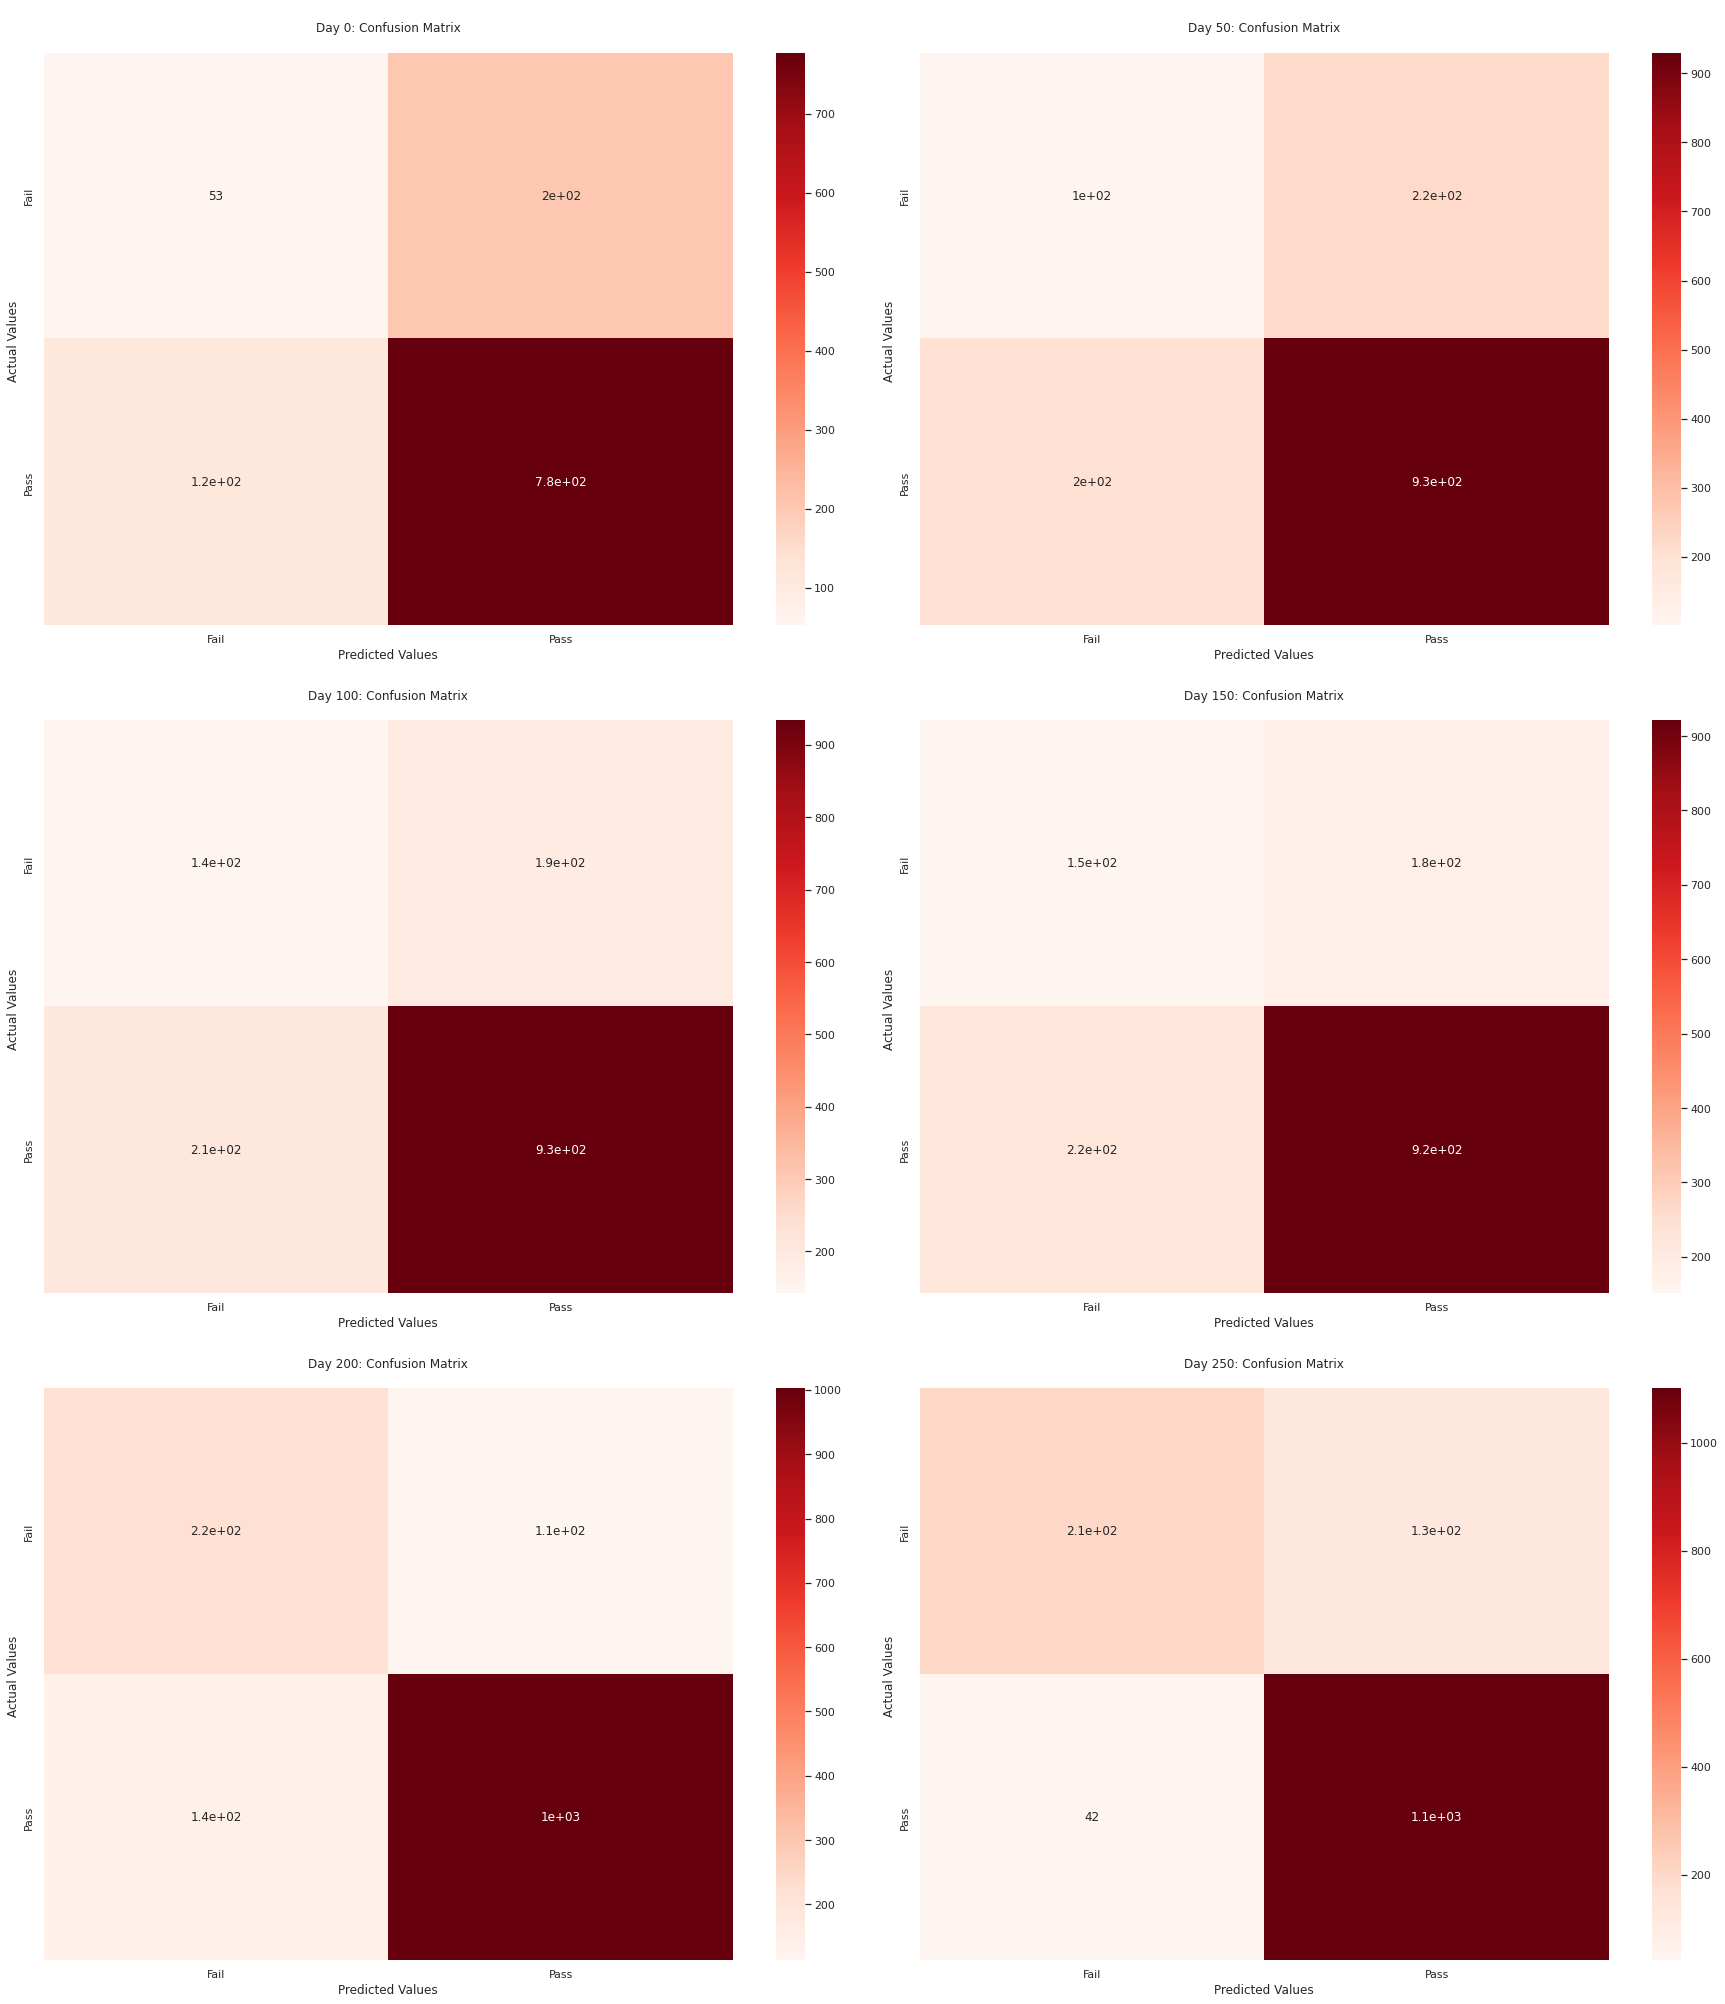

In [ ]:
plot_confusion_matrix(all_results_rf)

##### AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

all_results_ab = []
all_results_predict_ab = []

pipeline = Pipeline([
    ('clf', AdaBoostClassifier(random_state=RANDOM_SEED)),
])

params = {
  'clf__learning_rate':(0.5,0.85,1,1.25,1.5,1.75)
}

for i in df.keys():
  print(f"Day {i}")
  grid_search = GridSearchCV(pipeline , param_grid=params , n_jobs=-1, verbose=1, scoring='f1_macro', cv=3,)
  print("Performing grid search...")
  print("pipeline:", [name for name, _ in pipeline.steps])
  print("parameters:")
  print(params)
  tuned_model = grid_search.fit(X_train[i], Y_train[i])

  print("Best score: %0.3f" % grid_search.best_score_)
  print("Best parameters set:")
  best_parameters = grid_search.best_estimator_.get_params()
  for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

  predictions = tuned_model.predict(X_test[i])


  acc, f1, prec, recall, conf = evaluation_summary(predictions, Y_test[i])
  print(f"Accuracy: {acc}, F1 Score: {f1}, Precision: {prec}, Recall: {recall}")
  all_results_ab.append([acc, f1, prec, recall, conf])
  all_results_predict_ab.append(predictions)
  print("\n")

Day 0
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.592
Best parameters set:
	clf__learning_rate: 1.25
Accuracy: 0.6976542137271937, F1 Score: 0.8108695652173913, Precision: 0.7894179894179895, Recall: 0.8335195530726257


Day 50
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.613
Best parameters set:
	clf__learning_rate: 1.25
Accuracy: 0.6920438957475995, F1 Score: 0.7954441913439635, Precision: 0.8220338983050848, Recall: 0.7705207413945278


Day 100
Performing grid search...
pipeline: ['clf']
parameters:
{'clf__learning_rate': (0.5, 0.85, 1, 1.25, 1.5, 1.75)}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best score: 0.642
Best parameters set:
	clf__learning_rate: 1
Accuracy: 0.7222222222222222, F

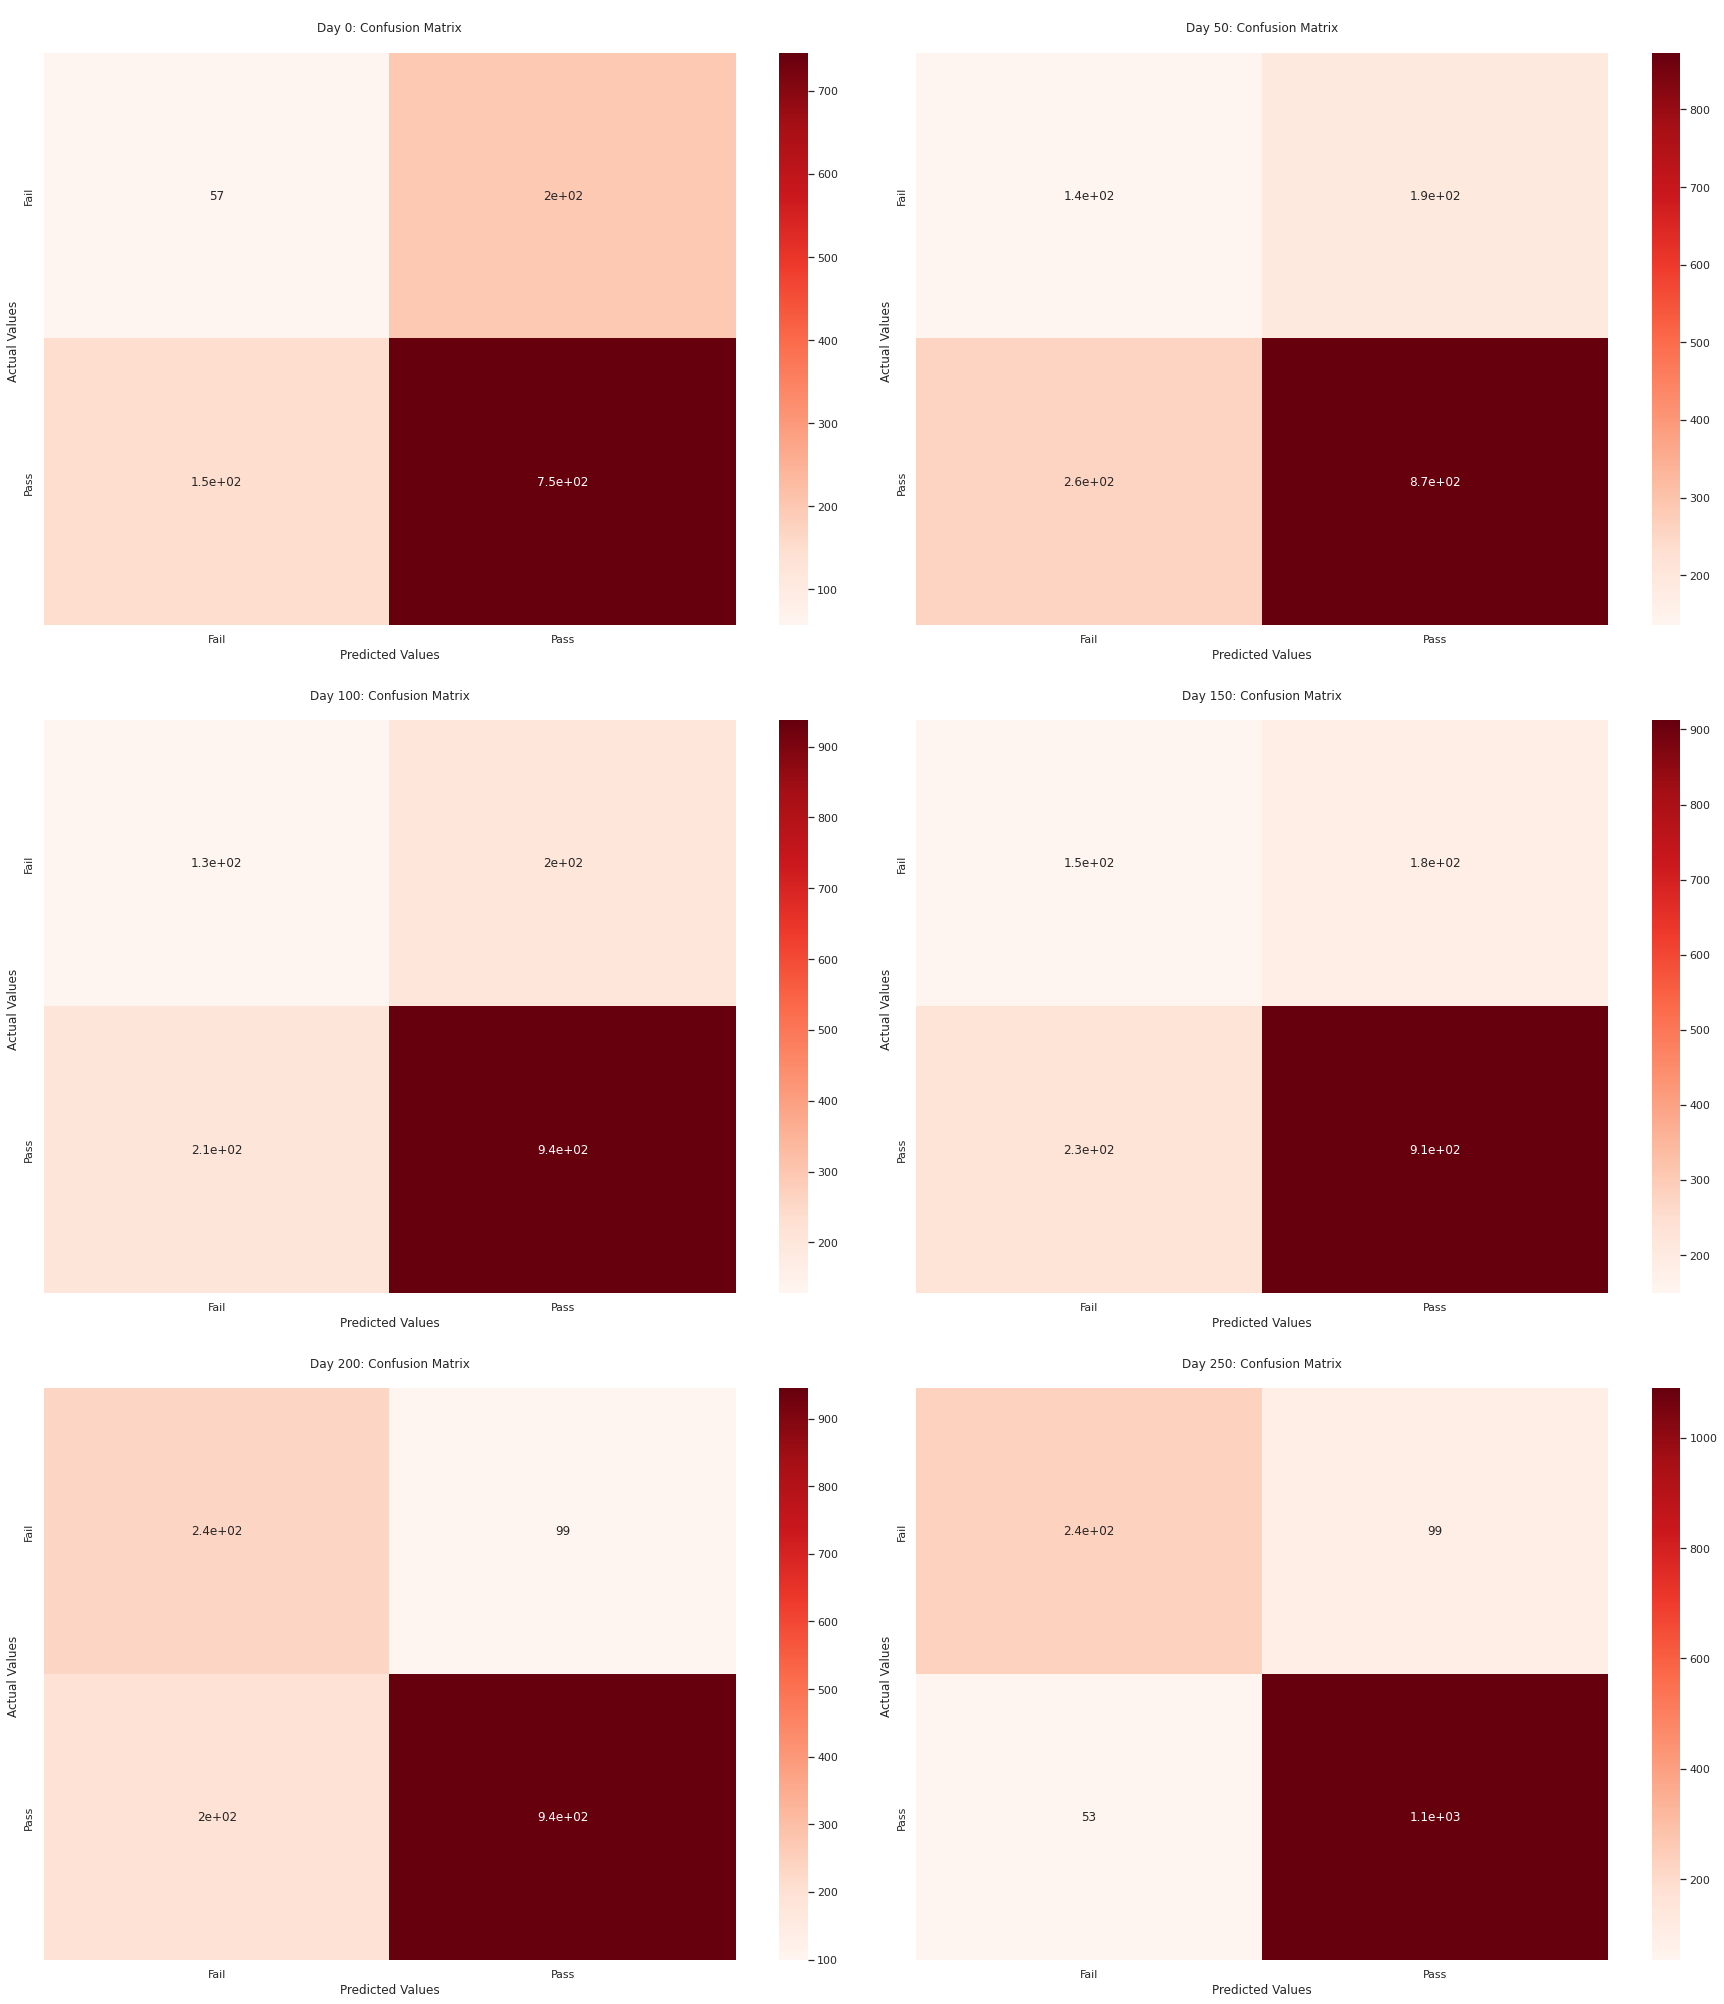

In [ ]:
plot_confusion_matrix(all_results_ab)

##### Plot results overview

In [ ]:
all_classifier_results = [all_results_du, all_results_nb, all_results_lr, all_results_lrw, all_results_rf, all_results_ab]
all_classifier_labels = ["Dummy Classifier", "Naive Bayes", "Logistic Regression", "Logistic Regression Weighted", "Random Forest", "AdaBoost"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-

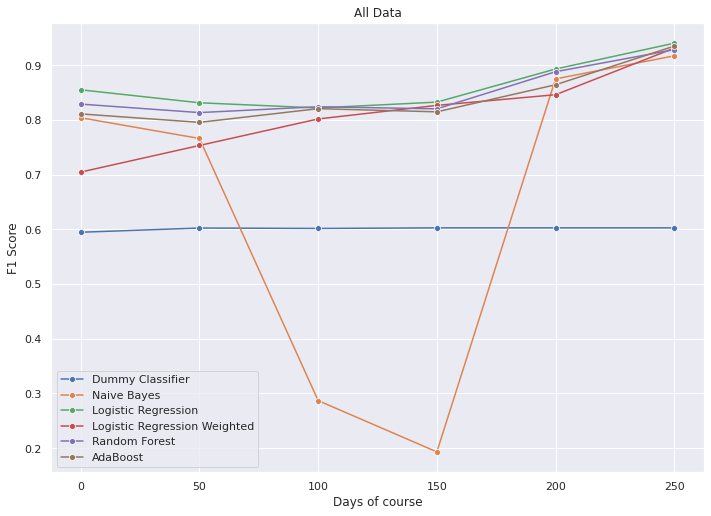

In [ ]:
plot_days_compare(deadline_list,all_classifier_results,all_classifier_labels, "All Data")

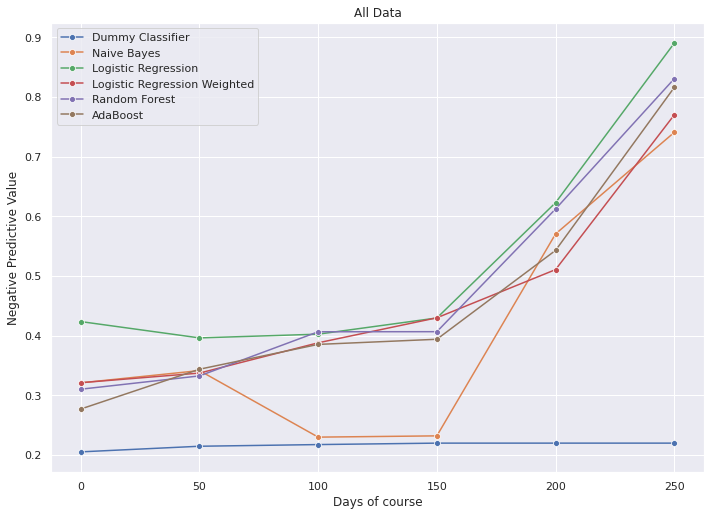

In [ ]:
plot_days_compare_npv(deadline_list,all_classifier_results,all_classifier_labels, "All Data")

#### Three classifiers

In [ ]:
confusion_matrix_combine_three = []
keys= list(df)

for i in range(len(df.keys())):
  print(i)

  test_results = pd.DataFrame(Y_test[keys[i]]).reset_index().to_numpy()[:,1]

  confusion_matrix_combine_three.append(np.zeros([2,2]))

  for j in range(len(all_results_predict_lr[i])):
    sum_predict = all_results_predict_lr[i][j] + all_results_predict_rf[i][j] + all_results_predict_ab[i][j]
    if sum_predict <= 1:
      prediction = 0
    else:
      prediction = 1

    if prediction == 0 and test_results[j] == 0:
      confusion_matrix_combine_three[i][0,0] += 1
    elif prediction == 0 and test_results[j] == 1:
      confusion_matrix_combine_three[i][1,0] += 1
    elif prediction == 1 and test_results[j] == 0:
      confusion_matrix_combine_three[i][0,1] += 1
    else:
      confusion_matrix_combine_three[i][1,1] += 1


0
1
2
3
4
5


In [ ]:
for i in range(len(confusion_matrix_combine_three)):
  print(confusion_matrix_combine_three[i])

[[ 51. 205.]
 [ 90. 805.]]
[[115. 210.]
 [179. 954.]]
[[147. 186.]
 [211. 932.]]
[[150. 184.]
 [209. 934.]]
[[229. 105.]
 [149. 994.]]
[[ 220.  114.]
 [  30. 1113.]]


51.0 205.0 90.0 805.0
115.0 210.0 179.0 954.0
147.0 186.0 211.0 932.0
150.0 184.0 209.0 934.0
229.0 105.0 149.0 994.0
220.0 114.0 30.0 1113.0


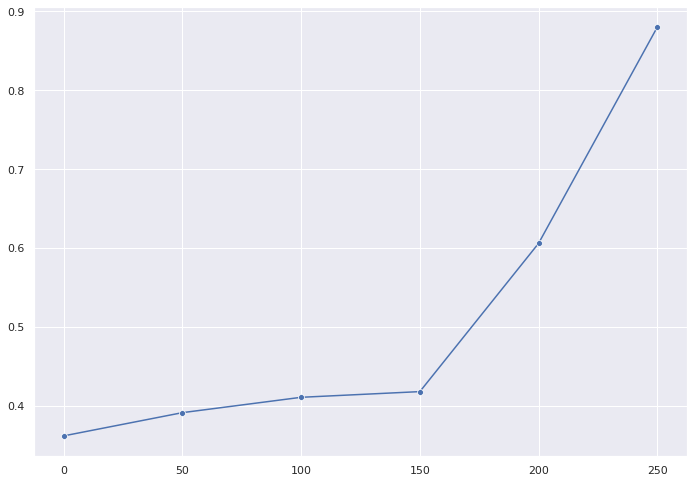

In [ ]:
npv = []
for i in confusion_matrix_combine_three:
  tn, fp, fn, tp = i.ravel()

  print(tn,fp,fn,tp)

  # Prevent zero division error
  if fn == 0:
    npv.append(0)
  else:
    npv.append(tn/(tn+fn))

plt_days = sns.lineplot(x=deadline_list,y=npv,marker="o")

#### Combine Classifier Results

In [ ]:
confusion_matrix_combine = []
performance_weight = [0,0,0,0.0,0.5,0.5]
keys= list(df)


for i in range(len(df.keys())):
  print(i)

  test_results = pd.DataFrame(Y_test[keys[i]]).reset_index().to_numpy()[:,1]

  confusion_matrix_combine.append(np.zeros([2,2]))
  for j in range(len(all_results_predict_proba_lr[i])):
    all_result = all_results_predict_proba_lr[i][j] * (1-performance_weight[i])

    if performance_weight[i] != 0:
      performance_result = performance_predict_proba_nb[i-1][j] * (performance_weight[i])
    else:
      performance_result = 0
    
    final_result = all_result + performance_result
    
    if final_result[0]>0.55:
      prediction = 0
    else:
      prediction = 1

    if prediction == 0 and test_results[j] == 0:
      confusion_matrix_combine[i][0,0] += 1
    elif prediction == 0 and test_results[j] == 1:
      confusion_matrix_combine[i][1,0] += 1
    elif prediction == 1 and test_results[j] == 0:
      confusion_matrix_combine[i][0,1] += 1
    else:
      confusion_matrix_combine[i][1,1] += 1


0
1
2
3
4
5


In [ ]:
for i in range(len(confusion_matrix_combine)):
  print(confusion_matrix_combine[i])

[[ 38. 218.]
 [ 59. 836.]]
[[  92.  233.]
 [ 133. 1000.]]
[[138. 195.]
 [188. 955.]]
[[139. 195.]
 [182. 961.]]
[[ 227.  107.]
 [  87. 1056.]]
[[ 205.  129.]
 [  12. 1131.]]
